In [1]:
import heapq as hq
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# für 
from random import shuffle 

class Event:
    def __init__(self, time, action, bm, passenger):
        self.time = time
        self.action = action
        self.bm = bm
        self.p = passenger
        #print(self.time)
    def __lt__(self, other):
        return (self.time, 
                self.bm,
                self.p) < (other.time,
                           other.bm,
                           other.p)
    def __le__(self, other):
        return (self.time,
                self.bm,
                self.p) <= (other.time, 
                            other.bm,
                            other.p)

class Passagier:
    def __init__(self, Ziel):
        self.ziel = Ziel
        #self.umstieg = {'Umstieg': False, 'Station': Station}
        self.umstieg = 8 #'dummy_place'
        self.time = 0
        self.bm = 'dummy'
    def __lt__(self, other):
        return (self.time,
                self.bm,
                self.ziel,
                self.umstieg) < (other.time,
                                 other.bm,
                                 other.ziel,
                                 other.umstieg)
    def __le__(self, other):
        return (self.time,
                self.bm, 
                self.ziel,
                self.umstieg) <= (other.time, 
                                  other.bm, 
                                  other.ziel,
                                  other.umstieg)
        
def shuffle0(passengers):
    for i in range(len(passengers)):
        x = [j for j in range(len(passengers[i]))]
        shuffle(x)
        passengers[i] = [passengers[i][k] for k in x]

def calc_pic(grah, ListeColor, ListeSize):
    nx.draw(graph, nx.get_node_attributes(graph,'pos'), with_labels = True, node_color = ListeColor, node_size = ListeSize)
    #nx.draw_kamada_kawai(graph, with_labels = True, node_color = ListeColor, node_size = ListeSize)
    
#default='#ecf2e3'
default='#cad3b8' #nice color

In [2]:
# Lösung für Passagier als Klasse
def solve(eventq, passengers, bms, graph):
    imglist = []
    v = [len([idx for idx, passenger in enumerate(passengers[n]) if passenger.ziel == n]) == 0 for n in range(len(passengers))]
    if not (v == [True]*len(passengers)):
        ErrorMessage = 'Bei Passengers/Netz sind an den Knoten {} Passagiere, die auf derselben Ziel untergebracht sind.'.format([idx for idx, boolean in enumerate(v) if boolean == False])
        raise Exception(ErrorMessage)
    
    if not (len(graph.node)) == (len(passengers)):
        ErrorMessage = 'Die Graphiken werden fehlerhaft berechnet.\n'
        if len(graph.node) < len(passengers):
            ErrorMessage += 'Es sind mehr Einträge in Passengers ({}) als Knoten im Graph ({})'.format(len(passengers),len(graph.node)) + '\n'
            ErrorMessage += 'Löschen/Fügen Sie ({}) Einträge/Knoten im Passengers/Graph /ein'.format(abs(len(passengers) - len(graph.node)))
        else:
            ErrorMessage += 'Es sind weniger Einträge in Passengers ({}) als Knoten im Graph ({})'.format(len(passengers),len(graph.node)) + '\n'
            ErrorMessage += 'Fügen/Löschen Sie ({}) Einträge/Knoten im Passengers/Graph /ein'.format(abs(len(passengers) - len(graph.node)))
        raise Exception(ErrorMessage)
    
    if not [len(bms[i]['itinerary']) == len(bms[i]['travel_times']) for i in range(len(bms))] == [True]*len(bms):
        raise Exception('In der Liste BMS sind itinerary und travel_times nicht gleich groß.')
    ####
    # Visualisierung
    ListeNodes = list(graph.node)
    ListeColor = [default]*len(ListeNodes)
    ####
    
    zykel = 0
    while eventq:
        print('\n Durchläuft die While-Schleife zum {}. Mal'.format(zykel))
       
        #'''
        m='Länge der Queue: {} '.format(len(eventq))
        for element in eventq:
            p = element.p
            m += 'aktion:{}, time:{}.{}, bm:{}.{}; '.format(element.action,
                                                           element.time,
                                                           element.time==p.time,
                                                           #p.time,
                                                           element.bm,
                                                           element.bm==p.bm)
        print(m)
        #'''
        
        # Abbruchbedingung
        if ([len(passengers[i]) == 0 for i in range(len(passengers))] == [True]*len(passengers)) and ([len(bms[i]['n_passengers']) == 0 for i in range(len(bms))] == [True]*len(bms)):
            print('ENDE')
            return imglist
        
        event = hq.heappop(eventq)
        
        Bahnen = [idx for idx, bahn in enumerate(bms) if bahn['name'] == event.bm]
        if not Bahnen:
            raise Exception('Fehler')
        if len(Bahnen)>1:
            raise Exception('Fehler')
        bm = bms[Bahnen[0]]

        itinerary_len = len(bm['itinerary'])
        current_node = bm['itinerary'][bm['stop'] % itinerary_len]
        cn_number = [idx for idx, station in enumerate(bm['itinerary']) if station == current_node][0] #Current Node Number
        
        next_node = bm['itinerary'][(bm['stop']+1) % itinerary_len]
        nn_number = [idx for idx, station in enumerate(bm['itinerary']) if station == next_node][0]
        print('Fahrzeug {} ist am Knoten {}, der nächste Halt {}, die aktuelle Zeit: {}'.format(bm['name'],ListeNodes[current_node], ListeNodes[next_node], event.time))
        print('und {} Stopp zum {}. Mal, Runden: {}, Rest: {}'.format(bm['name'],bm['stop'],int(bm['stop']/itinerary_len),bm['stop']%itinerary_len))
        stop = bm['stop']
        
        ####
        # Visualisierung
        ListeSize = [len(i)*100 for i in passengers]
        ListeColor[current_node] = bm['color']
        calc_pic(graph, ListeColor, ListeSize)
        #plt.savefig("img/{}.png".format(event.time))
        plt.savefig("img/file%05d.png" % event.time)
        imglist += ["img/file%05d.png" % event.time]
        print("Graph gespeichert als file%05d.png, wird in imglist hinzugefügt" % event.time)
        plt.show()
        ListeColor[current_node] = default
        ####
        
        if event.action == 'load':
            print('Fahrzeug {} load'.format(bm['name']))
            print('Fahrzeug {} hat {} Plätze frei'.format(bm['name'],bm['capacity']-len(bm['n_passengers'])))
            dummy = event.p
            umstieg = []
            print(len(passengers[current_node]))
            # Konventionelles Auffüllen
            while len(bm['n_passengers']) < bm['capacity']:
                
                if not current_node < len(passengers):
                    raise Exception('Die Länge von passengers {} ist <= current_node {}'.format(len(passengers),current_node))
                
                waiting = [idx for idx, passenger in enumerate(passengers[current_node]) if passenger.ziel in bm['itinerary']]
                if not waiting:
                    break
                
                passenger = passengers[current_node].pop(waiting[0])
                passenger.bm = bm['name']
                
                exit_node = passenger.ziel
                en_number = [idx for idx, station in enumerate(bm['itinerary']) if station == exit_node][0]
                
                ListExit = []    
                for i in range((en_number-cn_number)% itinerary_len):
                    ListExit += [ bm['travel_times'][(cn_number + i) % itinerary_len] ]
                ExitTime = event.time - 2
                for i in ListExit:
                    ExitTime += (i)
                print('ExitTime: {}, ListExit: {}'.format(ExitTime,ListExit))
                
                passenger.time = ExitTime
                hq.heappush(bm['n_passengers'], ExitTime)
                bm['n_passengers'].sort()
                event_neu = Event(ExitTime,'exit', bm['name'], passenger)
                if not event_neu.time == passenger.time:
                    raise Exception('Fehler beim Setzen der Event Time')
                if not event_neu.bm == passenger.bm:
                    raise Exception('Fehler beim Setzen des Namens des Beförderungsmittels')
                hq.heappush(eventq, event_neu)
            print('Berechne, wer zukünftig umsteigen soll')
            while len(bm['n_passengers']) < bm['capacity']:
                if not current_node < len(passengers):
                    raise Exception('Die Länge von passengers {} ist <= current_node {}'.format(len(passengers),current_node))
                waiting = [idx for idx, passenger in enumerate(passengers[current_node]) if passenger.ziel in bm['itinerary']]
                umstieg = passengers[current_node][:]
                waiting2 = waiting[:]
                counter = 0
                while len(waiting2) != 0:
                    temp = waiting2.pop(0) - counter
                    umstieg.pop(temp)
                    counter += 1
                umstieg = [idx for idx, passenger in enumerate(umstieg) if passenger in passengers[current_node] and passenger.umstieg != current_node]
                
                if not passengers[current_node]:
                    break
                if not umstieg:
                    break
                
                p = passengers[current_node][umstieg[0]]
                protect = [bm['name'] for bm in bms if p.ziel in bm['itinerary'] and current_node in bm['itinerary']]
                temp = [i for i in umstieghilfe if current_node in i or p.ziel in i]
                print('Protect: ',protect)
                print('Temp: ', temp)
                # Anfang der Schutzfunktion
                if not protect:
                    path = []
                    path0 = []
                    for i in [[i for i in um if i != current_node and i != p.ziel] for um in temp]:
                        path0 += i
                    print('path ',path0)
                    path1 = [current_node]
                    if len(temp) ==2:
                        path1 += [i for i in temp[1] if i != p.ziel]
                    ##
                    # Hack
                    print('path1', path1)
                    print('PATH0 ',[[bm['name'] for bm in bms if node in bm['itinerary']] for node in path0])
                    print('PATH1 ',[[bm['name'] for bm in bms if node in bm['itinerary']] for node in path1])
                    PATH0 = [[bm['name'] for bm in bms if node in bm['itinerary']] for node in path0]
                    PATH1 = [[bm['name'] for bm in bms if node in bm['itinerary']] for node in path0]
                    #
                    # Hack gilt nur für dieses Szenario
                    print([node in bms[0]['itinerary'] for node in path0 ])
                    print([node in bms[0]['itinerary'] for node in path1 ])
                    print(p.bm)
                    if not ([node in bms[0]['itinerary'] for node in path0 ] == [True]*len(PATH0)):
                        if bm['name'] in ['zykel0', 'zykel1']:
                            path = path1
                            print(path)
                        else:
                            break
                    else:
                        path = path0
                    print(path)
                    # Ende des Hacks
                else:
                    if not bm['name'] in protect:
                        break
                # Ende der Schutzfunktion
                
                passenger = passengers[current_node].pop(umstieg.pop(0))
                if not p == passenger: raise Exception('Gedankenfehler')
                
                print(passenger)
                passenger.bm = bm['name']
                
                # Das Setzen des Umstiegs ist vermutlich vom Hack abhängig
                print('Temp: ',temp)
                if len(path) == 1:
                    passenger.umstieg = path[0]
                elif len(path) == 2:
                    l = [i for i in path if current_node != i]
                    passenger.umstieg = l[0]
                else:
                    raise Exception('Gedankenfehler')
                
                exit_node = passenger.umstieg
                print('exit_node ',exit_node)
                en_number = [idx for idx, station in enumerate(bm['itinerary']) if station == exit_node][0]
                
                ListExit = []    
                for i in range((en_number-cn_number)% itinerary_len):
                    ListExit += [ bm['travel_times'][(cn_number + i) % itinerary_len] ]
                ExitTime = event.time - 1
                for i in ListExit:
                    ExitTime += (i)
                print('ExitTime: {}, ListExit: {}'.format(ExitTime,ListExit))
                
                passenger.time = ExitTime
                #hq.heappush(bm['n_passengers'], passenger)
                #bm['n_passengers'].sort()
                hq.heappush(bm['n_passengers'], ExitTime)
                bm['n_passengers'].sort()
                event_neu = Event(ExitTime,'exit', bm['name'], passenger)
                if not event_neu.time == passenger.time:
                    raise Exception('Fehler beim Setzen der Event Time')
                if not event_neu.bm == passenger.bm:
                    raise Exception('Fehler beim Setzen des Namens des Beförderungsmittels')
                hq.heappush(eventq, event_neu)
                
                 
                
            #hq.heappush(eventq, Event(event.time + bm['travel_times'][nn_number], 'load',bm['name'], Passagier(_)))
            Time = event.time + bm['travel_times'][nn_number]
            #print(Time)
            dummy.time = Time
            #print(dummy.time)
            hq.heappush(eventq, Event(Time, 'load', bm['name'], dummy))
            bm['stop'] += 1
            
            #bm['stop'] = stop + 1
            print('Es warten noch {} Fahrgäste an Knoten {}'.format(len(passengers[current_node]),ListeNodes[current_node]))
        
        # Generate events for exiting passengers
        
        elif event.action == 'exit':
            passenger = event.p
            ExitTime = hq.heappop(bm['n_passengers'])
            print('PassagierStation:{}, PassagierTime:{}, steigt aus, EventTime {}'.format(passenger.ziel, passenger.time,event.time))
            print('Ist EventTime == PassagierTime: {}'.format(passenger.time == event.time))
            if not passenger.time == event.time:
                print(passenger)
                bahn = passenger.bm
                Bahnen = [idx for idx, bahn in enumerate(bms) if bahn['name'] == passenger.bm]
                if not Bahnen:
                    raise Exception('Fehler')
                if len(Bahnen)>1:
                    raise Exception('Fehler')
                bm0 = bms[Bahnen[0]]
                print('Passenger BM:{} CList: {}'.format(bahn, bm0['n_passengers']))
                print('Event BM: {} CList: {}'.format(bm['name'],bm['n_passengers']))
               
            print('Passagier am richtigen Ort: {}'.format([passenger.ziel == current_node,passenger.umstieg == current_node]))
            if [passenger.ziel == current_node,passenger.umstieg == current_node] == [False]*2:
                print(passenger)
                bahn = passenger.bm
                print(bahn,bm['name'])
            if [passenger.ziel == current_node,passenger.umstieg == current_node] == [False]*2:
                passengers[current_node] += [passenger]
                shuffle0(passengers)
                print('Passagier mit Ziel: {} wurde falsch berechnet.'.format(passenger.ziel))
                
            if passenger.umstieg == current_node:
                n = len(passengers[current_node])
                passengers[current_node] += [passenger]
                shuffle0(passengers)
                m = len(passengers[current_node])
                if not (m-n) ==1:
                    raise Exception('kann nicht')
                print('Passagier mit Ziel: {} steigt um.'.format(passenger.ziel))
                passenger.umstieg = 8
                
            print('Es sind {} Passagiere in der Bahn'.format(len(bm['n_passengers'])))
            
        else:
            raise Exception('Unknown event action')
        eventq.sort()
        zykel += 1

/home/phil/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


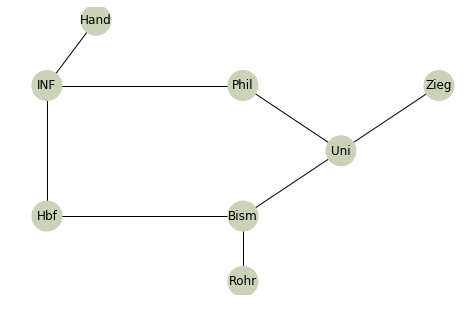

In [3]:
graph = nx.Graph()

graph.add_node('Hbf', pos=(10,10))  #0
graph.add_node('INF', pos=(10,30))  #1
graph.add_node('Phil', pos=(30,30))  #2
graph.add_node('Uni', pos=(40,20))  #3
graph.add_node('Bism', pos=(30,10))  #4
graph.add_node('Rohr', pos=(30,0))  #5
graph.add_node('Hand', pos=(15,40))  #6
graph.add_node('Zieg', pos=(50,30))  #7

ListeNodes = list(graph.node)
#Rundfahrt 
graph.add_edge(ListeNodes[0],ListeNodes[1])
graph.add_edge(ListeNodes[1],ListeNodes[0])
graph.add_edge(ListeNodes[1],ListeNodes[2])
graph.add_edge(ListeNodes[2],ListeNodes[1])
##
#graph.add_edge(ListeNodes[0],ListeNodes[2])
##
graph.add_edge(ListeNodes[2],ListeNodes[3])
graph.add_edge(ListeNodes[3],ListeNodes[2])
graph.add_edge(ListeNodes[3],ListeNodes[4])
graph.add_edge(ListeNodes[4],ListeNodes[3])
graph.add_edge(ListeNodes[4],ListeNodes[0])
graph.add_edge(ListeNodes[0],ListeNodes[4])

#Zubringer
graph.add_edge(ListeNodes[4],ListeNodes[5])
graph.add_edge(ListeNodes[5],ListeNodes[4])
graph.add_edge(ListeNodes[1],ListeNodes[6])
graph.add_edge(ListeNodes[6],ListeNodes[1])
graph.add_edge(ListeNodes[3],ListeNodes[7])
graph.add_edge(ListeNodes[7],ListeNodes[3])

ListeNodes = list(graph.node)
ListeColor = [default]*len(ListeNodes)
nx.draw(graph, nx.get_node_attributes(graph,'pos'), with_labels = True, node_color = ListeColor, node_size = 900)

In [4]:
'''
bms = [{'color': '#f0f000', 'n_passengers': [], 'capacity': 10, 'stop': 0, 'itinerary': [4, 3, 2, 1, 0], 'name': 'zykel0', 'travel_times': [5, 5, 6, 6, 7]},
    {'color': '#f000f0', 'n_passengers': [], 'capacity': 10, 'stop': 0, 'itinerary': [0, 1, 2, 3, 4], 'name': 'zykel1', 'travel_times': [7, 7, 6, 6, 5]},
    {'color': '#ff0000', 'n_passengers': [], 'capacity': 10, 'stop': 0, 'itinerary': [4,5], 'name': 'zubinger0', 'travel_times': [5, 5]},
    {'color': '#00ff00', 'n_passengers': [], 'capacity': 10, 'stop': 0, 'itinerary': [1,6], 'name': 'zubinger1', 'travel_times': [5, 6]},
    {'color': '#0000ff', 'n_passengers': [], 'capacity': 10, 'stop': 0, 'itinerary': [3,7], 'name': 'zubinger2', 'travel_times': [6, 5]}
       ]#
'''
bms = [{'color': '#f0f000', 'n_passengers': [], 'capacity': 15, 'stop': 0, 'itinerary': [4, 3, 2, 1, 0], 'name': 'zykel0', 'travel_times': [10, 10, 10, 10, 10]},
    {'color': '#f000f0', 'n_passengers': [], 'capacity': 15, 'stop': 0, 'itinerary': [0, 1, 2, 3, 4], 'name': 'zykel1', 'travel_times': [5, 5, 5, 5, 5]},
    {'color': '#ff0000', 'n_passengers': [], 'capacity': 15, 'stop': 0, 'itinerary': [4,5], 'name': 'zubinger0', 'travel_times': [5, 5]},
    {'color': '#00ff00', 'n_passengers': [], 'capacity': 15, 'stop': 0, 'itinerary': [1,6], 'name': 'zubinger1', 'travel_times': [5, 5]},
    {'color': '#0000ff', 'n_passengers': [], 'capacity': 15, 'stop': 0, 'itinerary': [3,7], 'name': 'zubinger2', 'travel_times': [5, 5]}
       ]#'''

bm = bms[0]

#'''
passengers = [#
    [Passagier(1)]*20 +[Passagier(2)]*10 +[Passagier(3)]*10 +[Passagier(4)]
    +[Passagier(5)]*10 +[Passagier(6)]*10 +[Passagier(7)]*0, # 'Zubringer Bahnhof' #0
    [Passagier(0)]*10 +[Passagier(2)]*10 +[Passagier(3)]*10 +[Passagier(4)]
    +[Passagier(5)]*0 +[Passagier(6)]*0 +[Passagier(7)]*0, # 'Zubringer Bahnhof' #1
    [Passagier(0)]*10 +[Passagier(1)]*10  +[Passagier(3)]*10 +[Passagier(4)]
    +[Passagier(5)]*0 +[Passagier(6)]*0 +[Passagier(7)]*0, # 'Zubringer Bahnhof' #2
    [Passagier(0)]*10 +[Passagier(2)]*10 +[Passagier(1)]*10 +[Passagier(4)]
    +[Passagier(5)]*0 +[Passagier(6)]*0 +[Passagier(7)]*0, # 'Zubringer Bahnhof' #3
    [Passagier(0)]*10 +[Passagier(1)]*10 +[Passagier(2)]*10 +[Passagier(3)]*10
    +[Passagier(5)]*0 +[Passagier(6)]*0 +[Passagier(7)]*10, # 'Zubringer Bahnhof' #4
    [Passagier(4)]*10 +[Passagier(7)]*10 +[Passagier(0)]*10, # Umsteigen nicht da #5
    [Passagier(1)]*10, # Umsteigen nicht da #6
    [Passagier(3)]*10  # Umsteigen nicht da #7
               ]
'''
passengers = [#
    [Passagier(7)],#    [Passagier(1)]*0 +[Passagier(2)]*1 +[Passagier(3)]*1, #0
    [Passagier(2)],#    [Passagier(0)]*100 +[Passagier(2)]*10 +[Passagier(3)]*10, #1
    [],#    [Passagier(0)]*10 +[Passagier(1)]*10  +[Passagier(3)]*10, #2
    [],#    [Passagier(0)]*10 +[Passagier(2)]*10 +[Passagier(1)]*10, #3
    [Passagier(7)],#    [Passagier(0)]*10 +[Passagier(2)]*10 +[Passagier(3)]*10, #4
    [Passagier(7)],#    [Passagier(4)]*0 +[Passagier(2)]*1, #5
    [], #[Passagier(1)]*0, #6
    [], #[Passagier(3)]*0  #7
               ]#'''

umstieghilfe = [[4,5],[1,6],[3,7]]


# shuffle passengers
shuffle0(passengers)
sums=0
for node in passengers:
    sums += len(node)
print(sums)
'''
for station in range(len(passengers)):
    #print(station)
    for bm in bms:
        if station in bm['itinerary']:
            print( station , bm['name'])
#p = Passagier(7)
[bm['name'] for bm in bms if 1 in bm['itinerary']]
'''

254


"\nfor station in range(len(passengers)):\n    #print(station)\n    for bm in bms:\n        if station in bm['itinerary']:\n            print( station , bm['name'])\n#p = Passagier(7)\n[bm['name'] for bm in bms if 1 in bm['itinerary']]\n"


 Durchläuft die While-Schleife zum 0. Mal
Länge der Queue: 5 aktion:load, time:0.True, bm:zubinger0.True; aktion:load, time:0.True, bm:zubinger1.True; aktion:load, time:0.True, bm:zykel0.True; aktion:load, time:0.True, bm:zykel1.True; aktion:load, time:0.True, bm:zubinger2.True; 
Fahrzeug zubinger0 ist am Knoten Bism, der nächste Halt Rohr, die aktuelle Zeit: 0
und zubinger0 Stopp zum 0. Mal, Runden: 0, Rest: 0
Graph gespeichert als file00000.png, wird in imglist hinzugefügt


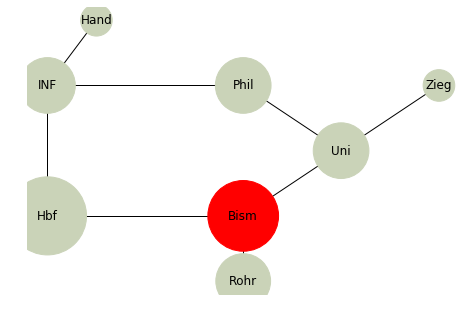

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
50
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 50 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 1. Mal
Länge der Queue: 5 aktion:load, time:0.True, bm:zubinger1.True; aktion:load, time:0.True, bm:zubinger2.True; aktion:load, time:0.True, bm:zykel0.True; aktion:load, time:0.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; 
Fahrzeug zubinger1 ist am Knoten INF, der nächste Halt Hand, die aktuelle Zeit: 0
und zubinger1 Stopp zum 0. Mal, Runden: 0, Rest: 0
Graph gespeichert als file00000.png, wird in imglist hinzugefügt


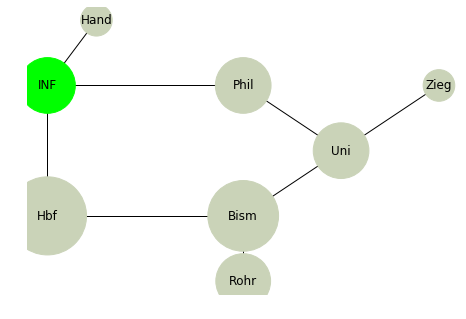

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
31
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6]]
Es warten noch 31 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 2. Mal
Länge der Queue: 5 aktion:load, time:0.True, bm:zubinger2.True; aktion:load, time:0.True, bm:zykel0.True; aktion:load, time:0.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; 
Fahrzeug zubinger2 ist am Knoten Uni, der nächste Halt Zieg, die aktuelle Zeit: 0
und zubinger2 Stopp zum 0. Mal, Runden: 0, Rest: 0
Graph gespeichert als file00000.png, wird in imglist hinzugefügt


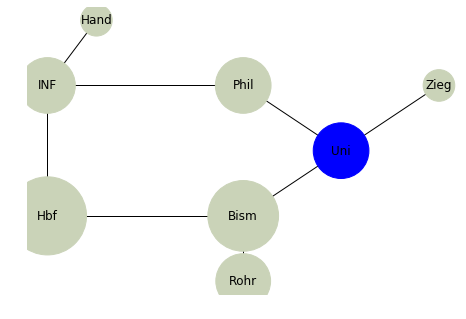

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
31
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[3, 7]]
Es warten noch 31 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 3. Mal
Länge der Queue: 5 aktion:load, time:0.True, bm:zykel0.True; aktion:load, time:0.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; 
Fahrzeug zykel0 ist am Knoten Bism, der nächste Halt Uni, die aktuelle Zeit: 0
und zykel0 Stopp zum 0. Mal, Runden: 0, Rest: 0
Graph gespeichert als file00000.png, wird in imglist hinzugefügt


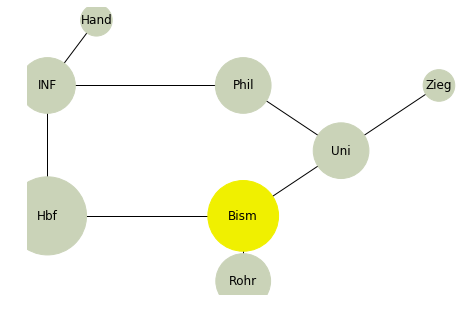

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 15 Plätze frei
50
ExitTime: 18, ListExit: [10, 10]
ExitTime: 28, ListExit: [10, 10, 10]
ExitTime: 38, ListExit: [10, 10, 10, 10]
ExitTime: 28, ListExit: [10, 10, 10]
ExitTime: 38, ListExit: [10, 10, 10, 10]
ExitTime: 38, ListExit: [10, 10, 10, 10]
ExitTime: 8, ListExit: [10]
ExitTime: 28, ListExit: [10, 10, 10]
ExitTime: 28, ListExit: [10, 10, 10]
ExitTime: 8, ListExit: [10]
ExitTime: 38, ListExit: [10, 10, 10, 10]
ExitTime: 18, ListExit: [10, 10]
ExitTime: 38, ListExit: [10, 10, 10, 10]
ExitTime: 28, ListExit: [10, 10, 10]
ExitTime: 18, ListExit: [10, 10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 35 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 4. Mal
Länge der Queue: 20 aktion:load, time:0.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zyk

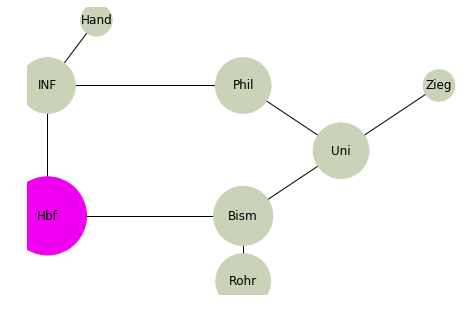

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 15 Plätze frei
61
ExitTime: 3, ListExit: [5]
ExitTime: 3, ListExit: [5]
ExitTime: 13, ListExit: [5, 5, 5]
ExitTime: 8, ListExit: [5, 5]
ExitTime: 3, ListExit: [5]
ExitTime: 8, ListExit: [5, 5]
ExitTime: 13, ListExit: [5, 5, 5]
ExitTime: 8, ListExit: [5, 5]
ExitTime: 3, ListExit: [5]
ExitTime: 8, ListExit: [5, 5]
ExitTime: 13, ListExit: [5, 5, 5]
ExitTime: 8, ListExit: [5, 5]
ExitTime: 3, ListExit: [5]
ExitTime: 3, ListExit: [5]
ExitTime: 3, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 46 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 5. Mal
Länge der Queue: 35 aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time

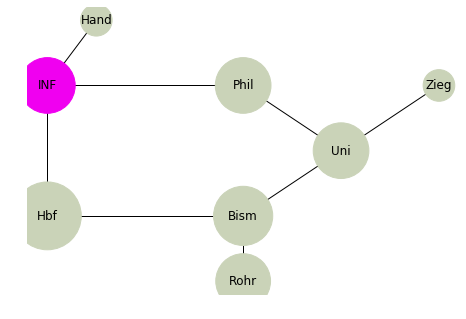

PassagierStation:1, PassagierTime:3, steigt aus, EventTime 3
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 6. Mal
Länge der Queue: 34 aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:load, time:10.True, bm:zykel0.Tru

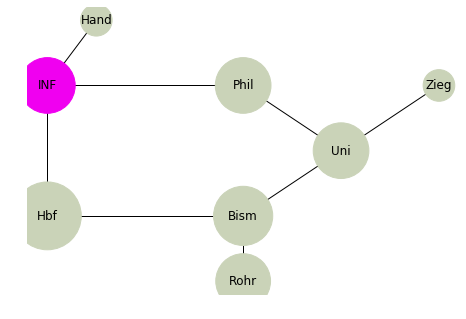

PassagierStation:1, PassagierTime:3, steigt aus, EventTime 3
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 7. Mal
Länge der Queue: 33 aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:load, time:10.True, bm:zykel0.True; aktion:exit, time:13.True, bm:zykel1.Tr

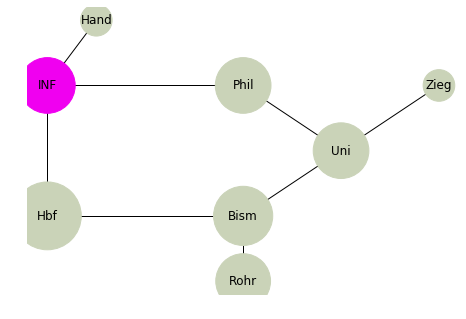

PassagierStation:1, PassagierTime:3, steigt aus, EventTime 3
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 8. Mal
Länge der Queue: 32 aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:load, time:10.True, bm:zykel0.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.T

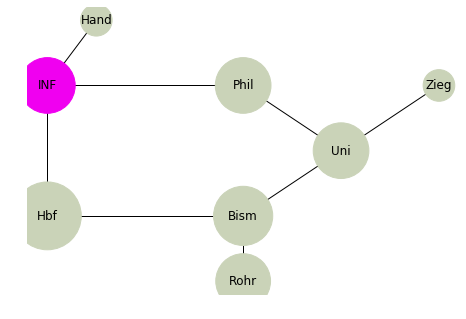

PassagierStation:1, PassagierTime:3, steigt aus, EventTime 3
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 9. Mal
Länge der Queue: 31 aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:load, time:10.True, bm:zykel0.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.

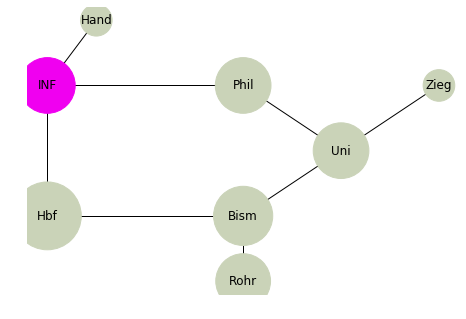

PassagierStation:1, PassagierTime:3, steigt aus, EventTime 3
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 10. Mal
Länge der Queue: 30 aktion:exit, time:3.True, bm:zykel1.True; aktion:exit, time:3.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:load, time:10.True, bm:zykel0.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel

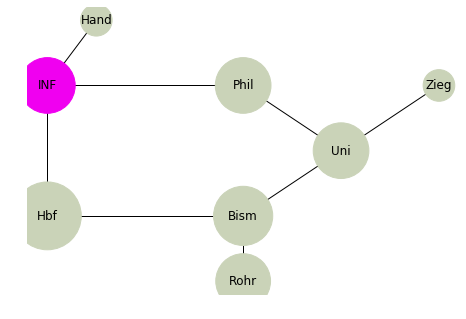

PassagierStation:1, PassagierTime:3, steigt aus, EventTime 3
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 11. Mal
Länge der Queue: 29 aktion:exit, time:3.True, bm:zykel1.True; aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:load, time:10.True, bm:zykel0.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel

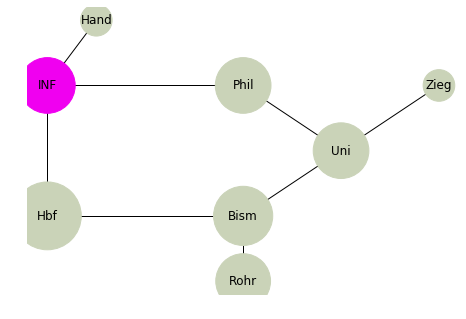

PassagierStation:1, PassagierTime:3, steigt aus, EventTime 3
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 12. Mal
Länge der Queue: 28 aktion:load, time:5.True, bm:zubinger0.True; aktion:load, time:5.True, bm:zubinger1.True; aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:load, time:10.True, bm:zykel0.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zyke

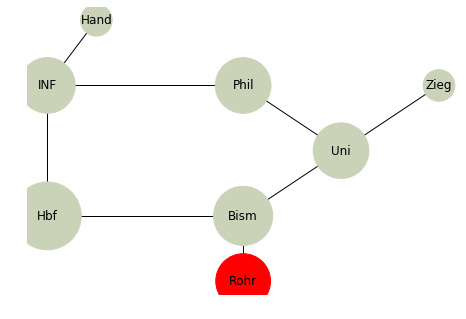

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
30
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [5]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zubinger0']]
[True]
[False]
dummy
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 9, ListExit: [5]
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [4, 3]
path1 [5, 3]
PATH0  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[True, True]
[False, True]
dummy
[4, 3]
Temp:  [[4, 5], [3, 7]]
exit_node  4
ExitTime: 9, ListExit: [5]
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [5]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zubinger0']]
[True]
[Fals

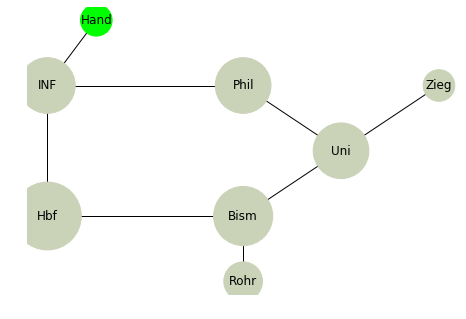

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
10
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 14. Mal
Länge der Queue: 53 aktion:load, time:5.True, bm:zubinger2.True; aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm

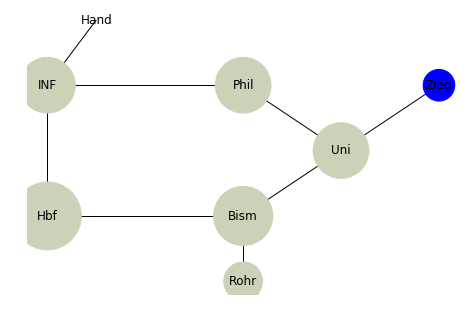

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
10
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
ExitTime: 8, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 15. Mal
Länge der Queue: 63 aktion:load, time:5.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm

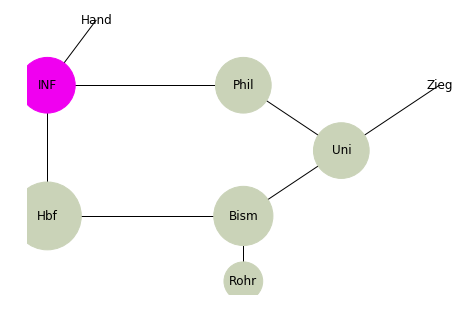

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 7 Plätze frei
31
ExitTime: 23, ListExit: [5, 5, 5, 5]
ExitTime: 8, ListExit: [5]
ExitTime: 13, ListExit: [5, 5]
ExitTime: 8, ListExit: [5]
ExitTime: 23, ListExit: [5, 5, 5, 5]
ExitTime: 23, ListExit: [5, 5, 5, 5]
ExitTime: 13, ListExit: [5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 24 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 16. Mal
Länge der Queue: 70 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:z

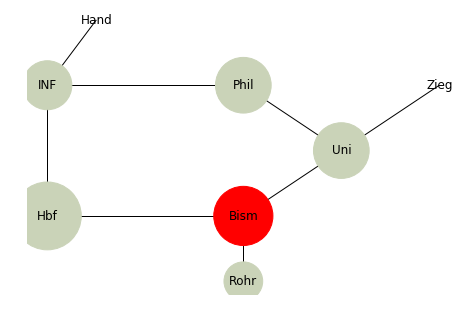

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 17. Mal
Länge der Queue: 69 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.Tru

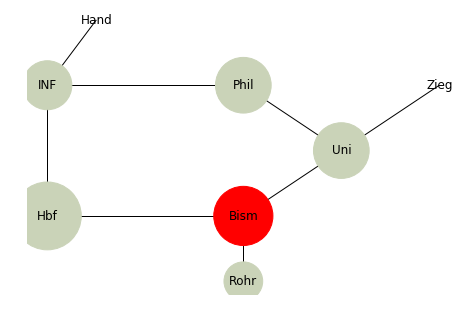

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 18. Mal
Länge der Queue: 68 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.Tru

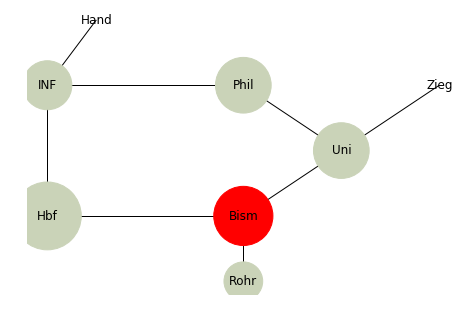

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 19. Mal
Länge der Queue: 67 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.Tru

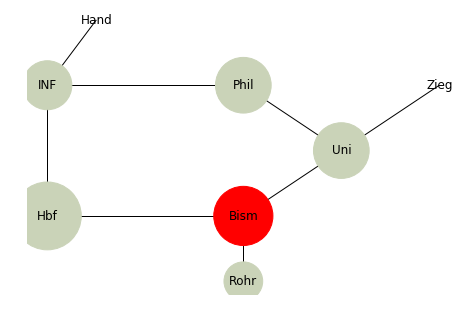

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 20. Mal
Länge der Queue: 66 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.Tru

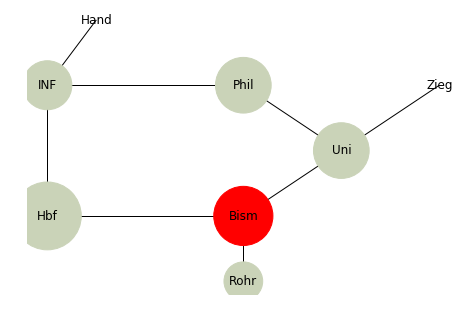

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 21. Mal
Länge der Queue: 65 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.Tru

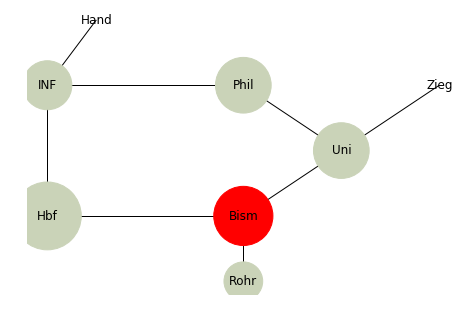

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 22. Mal
Länge der Queue: 64 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

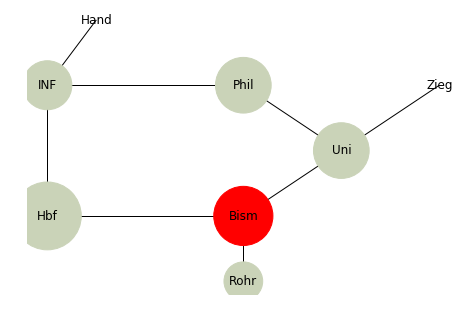

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 23. Mal
Länge der Queue: 63 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

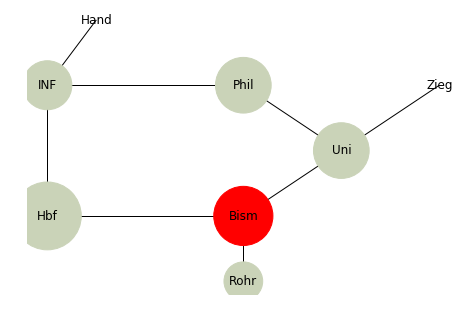

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 24. Mal
Länge der Queue: 62 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

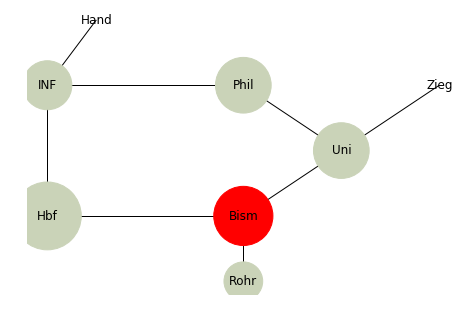

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 25. Mal
Länge der Queue: 61 aktion:exit, time:8.True, bm:zubinger0.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

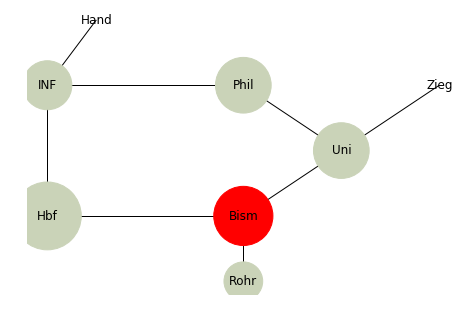

PassagierStation:4, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 26. Mal
Länge der Queue: 60 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

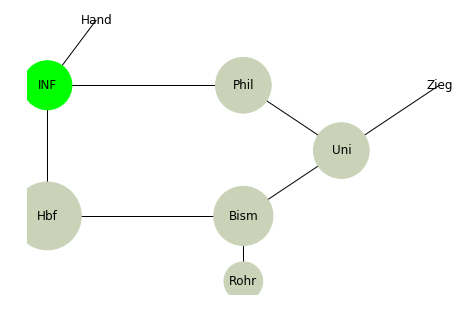

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 27. Mal
Länge der Queue: 59 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

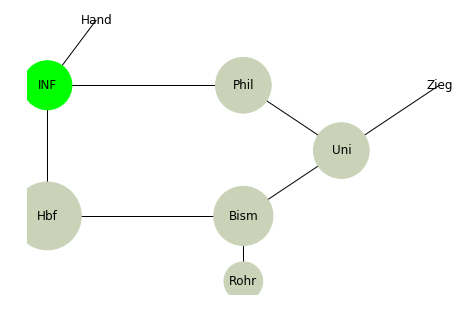

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 28. Mal
Länge der Queue: 58 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

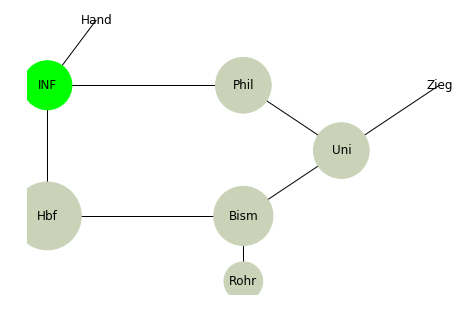

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 29. Mal
Länge der Queue: 57 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True

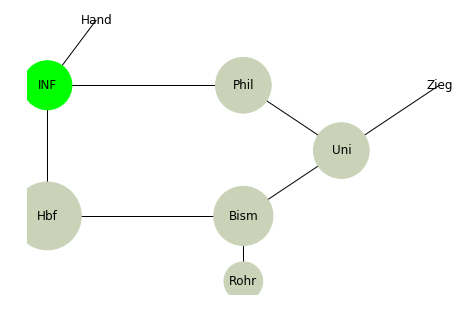

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 30. Mal
Länge der Queue: 56 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; a

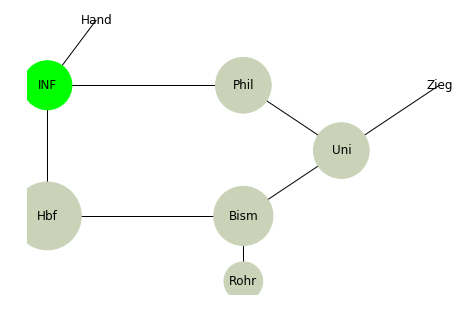

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 31. Mal
Länge der Queue: 55 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; akti

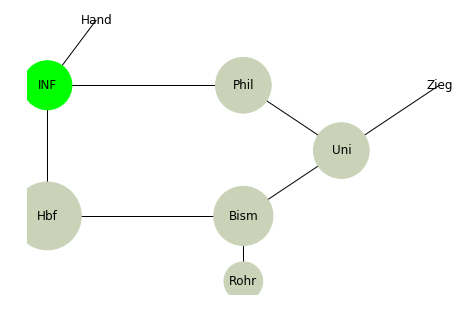

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 32. Mal
Länge der Queue: 54 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:

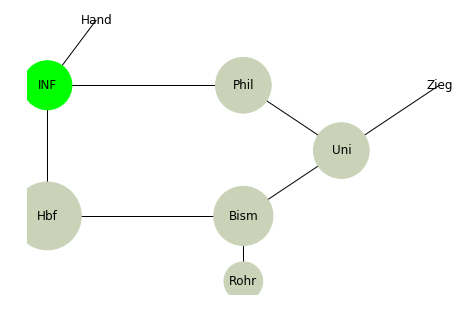

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 33. Mal
Länge der Queue: 53 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exi

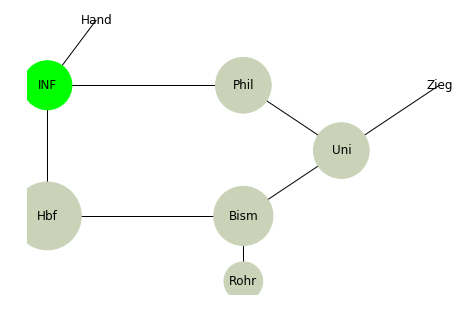

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 34. Mal
Länge der Queue: 52 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, 

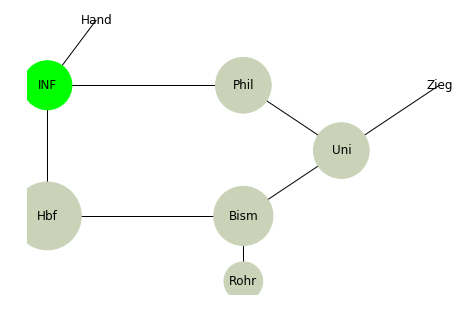

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 35. Mal
Länge der Queue: 51 aktion:exit, time:8.True, bm:zubinger1.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, tim

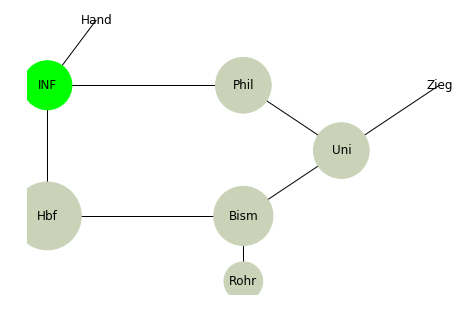

PassagierStation:1, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 36. Mal
Länge der Queue: 50 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8

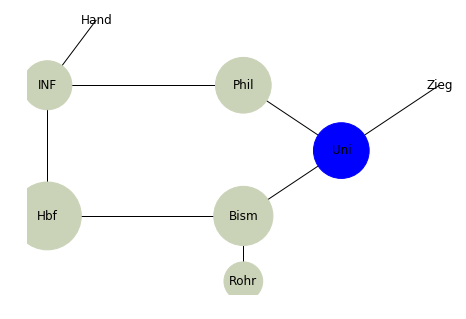

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 37. Mal
Länge der Queue: 49 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.Tr

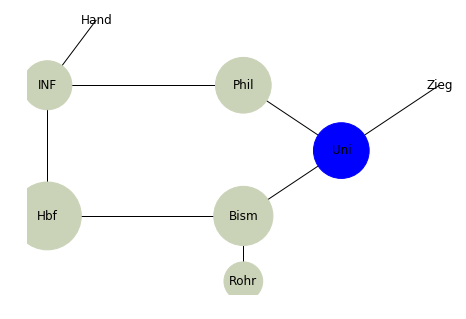

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 38. Mal
Länge der Queue: 48 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True,

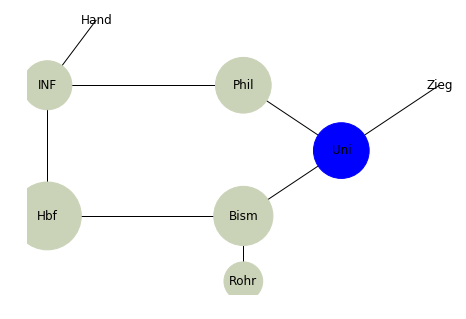

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 39. Mal
Länge der Queue: 47 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True,

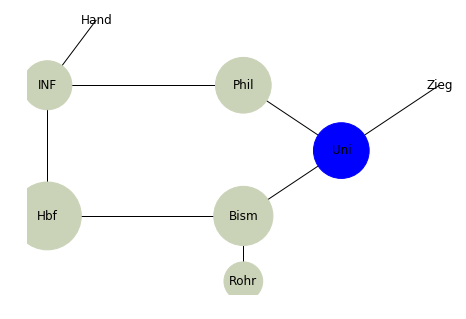

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 40. Mal
Länge der Queue: 46 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True,

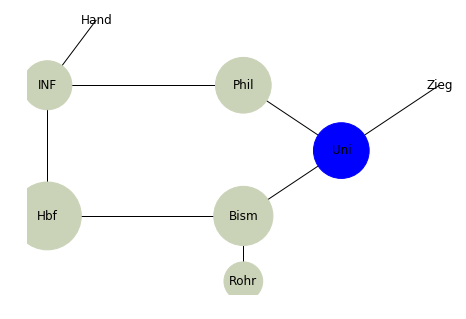

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 41. Mal
Länge der Queue: 45 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True,

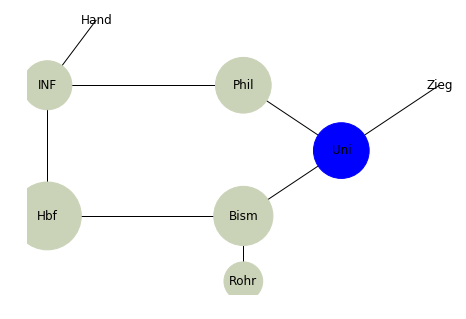

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 42. Mal
Länge der Queue: 44 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True,

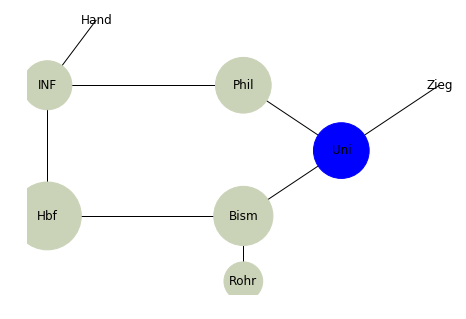

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 43. Mal
Länge der Queue: 43 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True

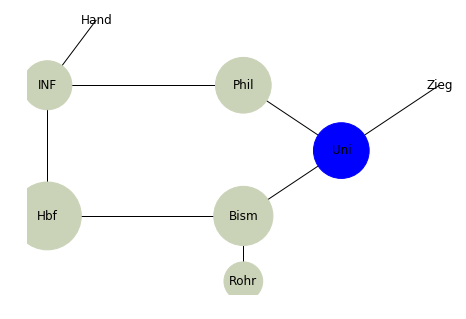

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 44. Mal
Länge der Queue: 42 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.Tru

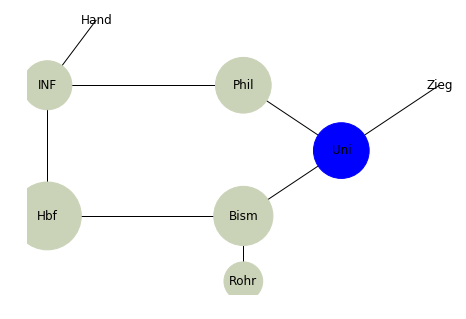

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 45. Mal
Länge der Queue: 41 aktion:exit, time:8.True, bm:zubinger2.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.Tr

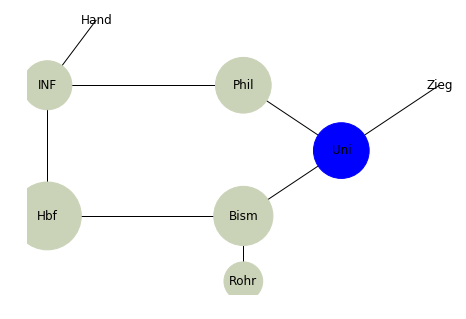

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 46. Mal
Länge der Queue: 40 aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.T

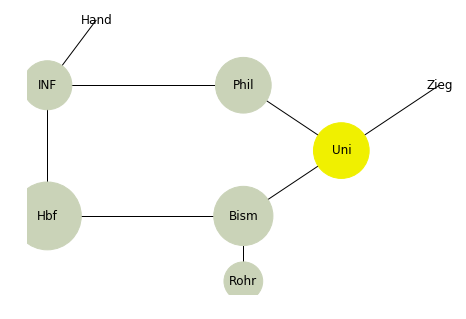

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 47. Mal
Länge der Queue: 39 aktion:exit, time:8.True, bm:zykel0.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10

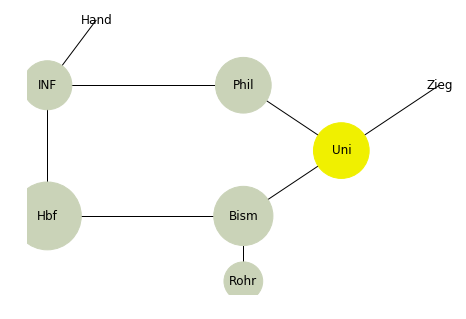

PassagierStation:3, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 48. Mal
Länge der Queue: 38 aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:1

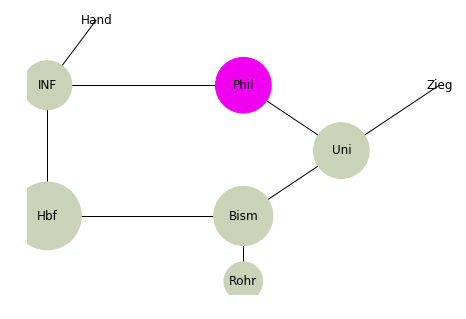

PassagierStation:2, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 49. Mal
Länge der Queue: 37 aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:

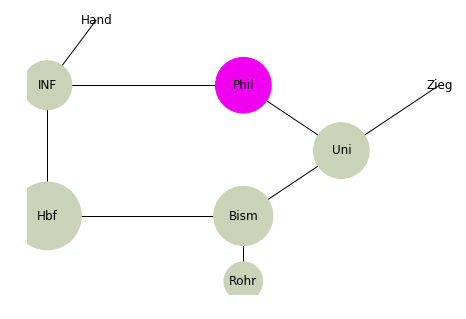

PassagierStation:2, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 50. Mal
Länge der Queue: 36 aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time

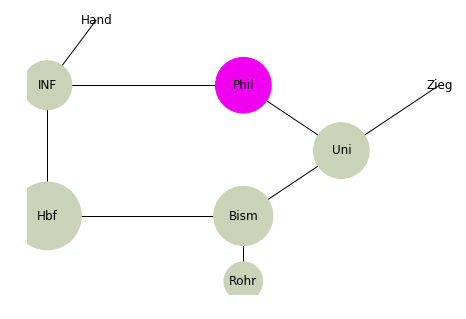

PassagierStation:2, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 51. Mal
Länge der Queue: 35 aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, tim

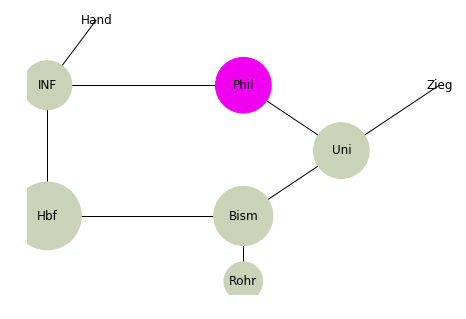

PassagierStation:2, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 52. Mal
Länge der Queue: 34 aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, ti

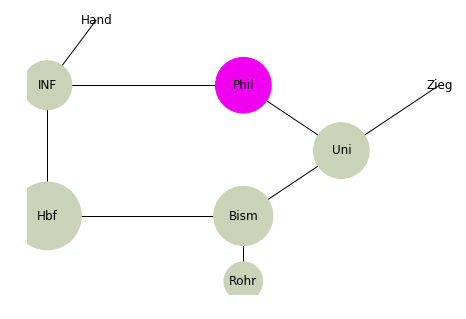

PassagierStation:2, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 53. Mal
Länge der Queue: 33 aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, t

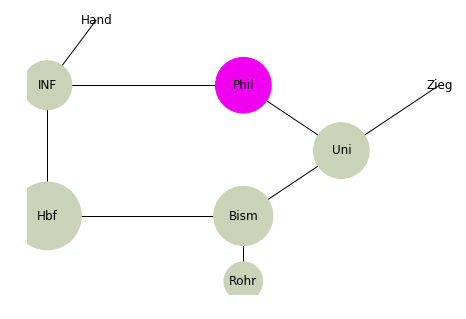

PassagierStation:2, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 54. Mal
Länge der Queue: 32 aktion:exit, time:8.True, bm:zykel1.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, t

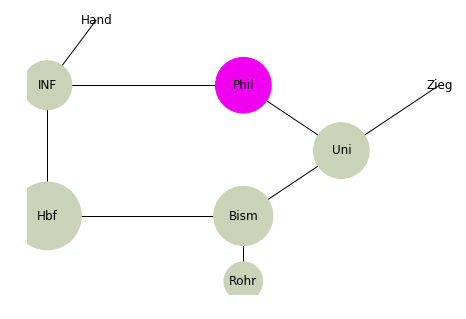

PassagierStation:2, PassagierTime:8, steigt aus, EventTime 8
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 55. Mal
Länge der Queue: 31 aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, 

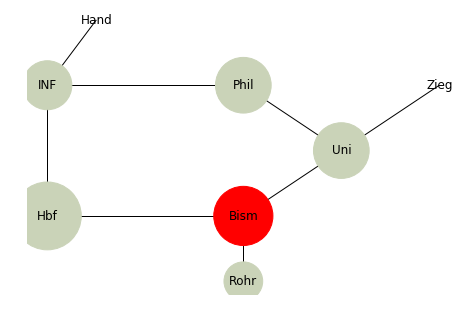

PassagierStation:0, PassagierTime:9, steigt aus, EventTime 9
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 0 steigt um.
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 56. Mal
Länge der Queue: 30 aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True

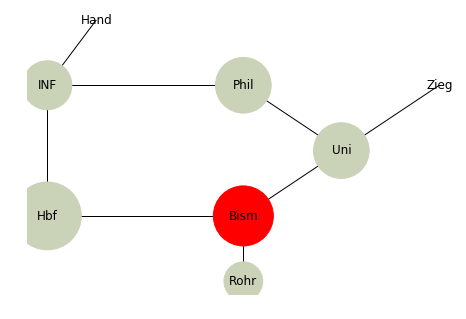

PassagierStation:0, PassagierTime:9, steigt aus, EventTime 9
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 57. Mal
Länge der Queue: 29 aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0

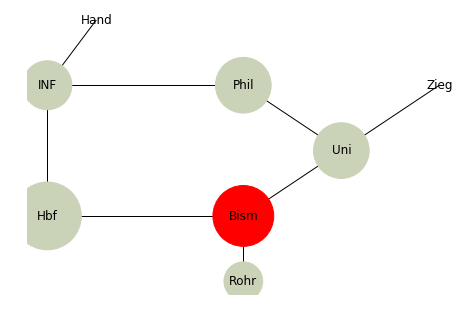

PassagierStation:0, PassagierTime:9, steigt aus, EventTime 9
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 58. Mal
Länge der Queue: 28 aktion:exit, time:9.True, bm:zubinger0.True; aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.T

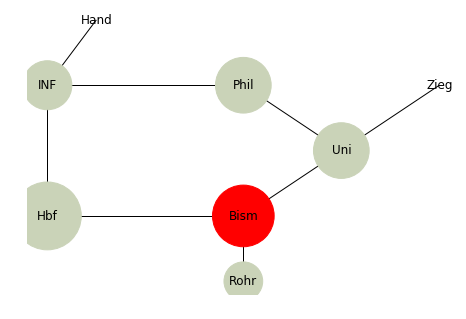

PassagierStation:7, PassagierTime:9, steigt aus, EventTime 9
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 7 steigt um.
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 59. Mal
Länge der Queue: 27 aktion:exit, time:9.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:z

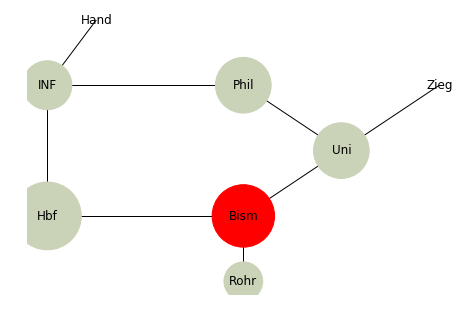

PassagierStation:7, PassagierTime:9, steigt aus, EventTime 9
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 60. Mal
Länge der Queue: 26 aktion:load, time:10.True, bm:zubinger0.True; aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True;

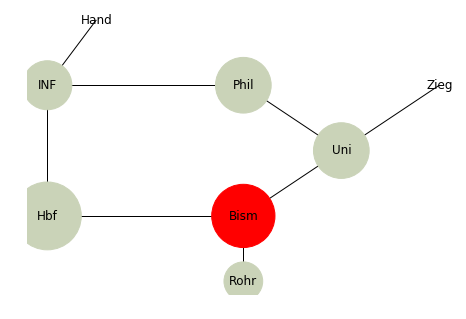

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
40
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
dummy
Es warten noch 40 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 61. Mal
Länge der Queue: 26 aktion:load, time:10.True, bm:zubinger1.True; aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zy

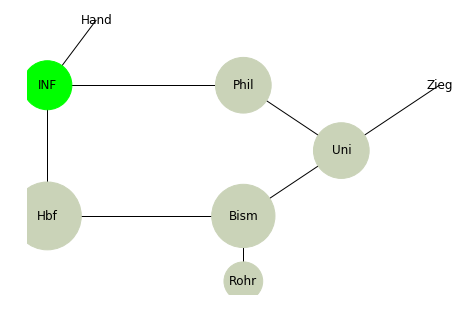

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
24
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6], [3, 7]]
Es warten noch 24 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 62. Mal
Länge der Queue: 26 aktion:load, time:10.True, bm:zubinger2.True; aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.T

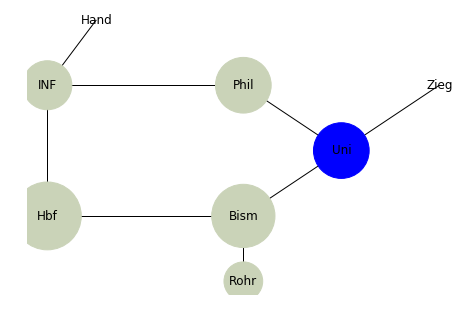

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
31
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6], [3, 7]]
Es warten noch 31 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 63. Mal
Länge der Queue: 26 aktion:load, time:10.True, bm:zykel0.True; aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.T

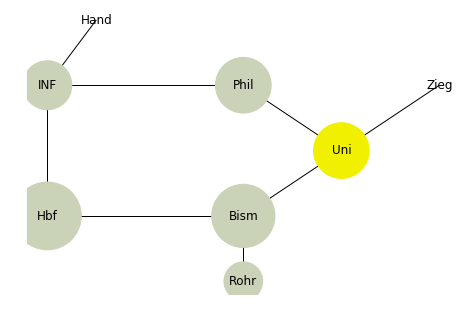

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 2 Plätze frei
31
ExitTime: 28, ListExit: [10, 10]
ExitTime: 38, ListExit: [10, 10, 10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 29 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 64. Mal
Länge der Queue: 28 aktion:load, time:10.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:

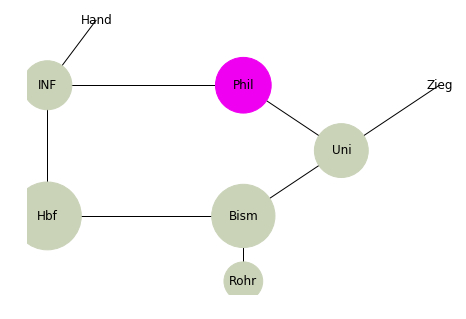

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 7 Plätze frei
31
ExitTime: 13, ListExit: [5]
ExitTime: 18, ListExit: [5, 5]
ExitTime: 28, ListExit: [5, 5, 5, 5]
ExitTime: 13, ListExit: [5]
ExitTime: 28, ListExit: [5, 5, 5, 5]
ExitTime: 23, ListExit: [5, 5, 5]
ExitTime: 28, ListExit: [5, 5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 24 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 65. Mal
Länge der Queue: 35 aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.Tr

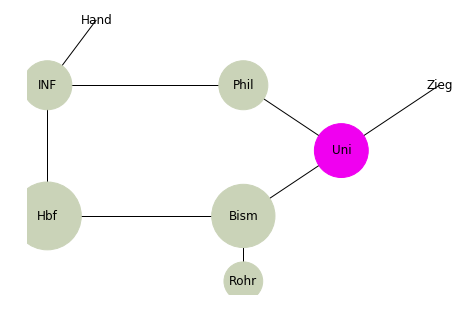

PassagierStation:3, PassagierTime:13, steigt aus, EventTime 13
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 66. Mal
Länge der Queue: 34 aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23

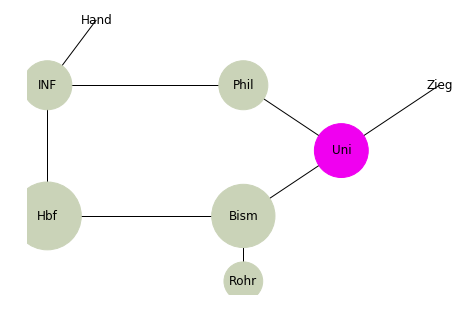

PassagierStation:3, PassagierTime:13, steigt aus, EventTime 13
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 67. Mal
Länge der Queue: 33 aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23

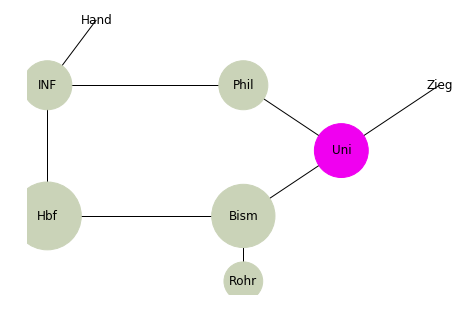

PassagierStation:3, PassagierTime:13, steigt aus, EventTime 13
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 68. Mal
Länge der Queue: 32 aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28

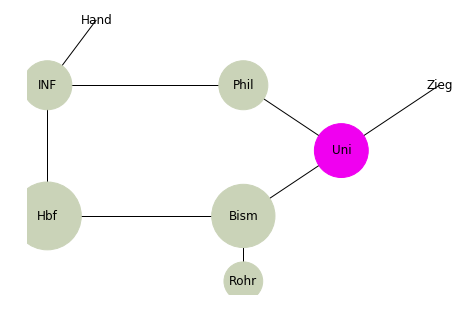

PassagierStation:3, PassagierTime:13, steigt aus, EventTime 13
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 69. Mal
Länge der Queue: 31 aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28

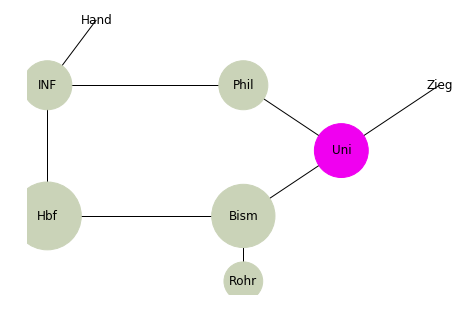

PassagierStation:3, PassagierTime:13, steigt aus, EventTime 13
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 70. Mal
Länge der Queue: 30 aktion:exit, time:13.True, bm:zykel1.True; aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28

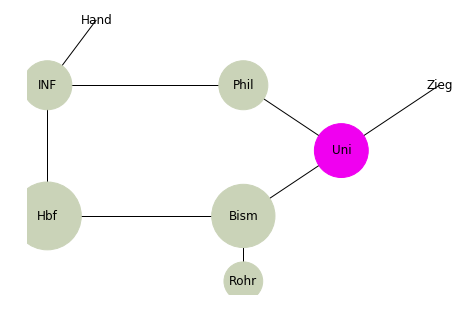

PassagierStation:3, PassagierTime:13, steigt aus, EventTime 13
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 71. Mal
Länge der Queue: 29 aktion:exit, time:13.True, bm:zykel1.True; aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.

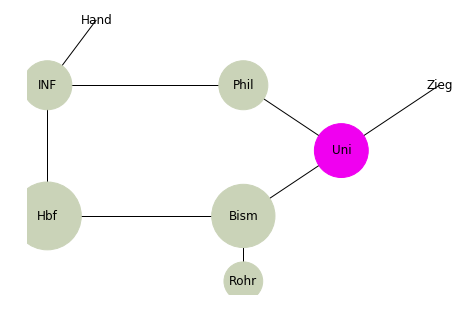

PassagierStation:3, PassagierTime:13, steigt aus, EventTime 13
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 72. Mal
Länge der Queue: 28 aktion:load, time:15.True, bm:zubinger0.True; aktion:load, time:15.True, bm:zubinger1.True; aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:load, time:20.True, bm:zykel0.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.

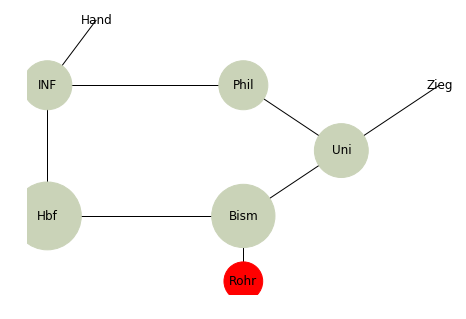

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
15
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [5]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zubinger0']]
[True]
[False]
zubinger0
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 19, ListExit: [5]
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [4, 3]
path1 [5, 3]
PATH0  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[True, True]
[False, True]
zubinger0
[4, 3]
Temp:  [[4, 5], [3, 7]]
exit_node  4
ExitTime: 19, ListExit: [5]
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [5]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zubinger0']]
[True]
[False]
zubinger0
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 19, ListExit: [5]
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [4, 3]
path1 [5, 3]
PATH0  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zubinger0'], ['zykel0', 'zykel1', '

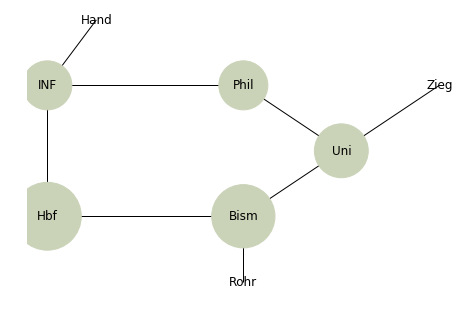

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 74. Mal
Länge der Queue: 43 aktion:load, time:15.True, bm:zubinger2.True; aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.Tru

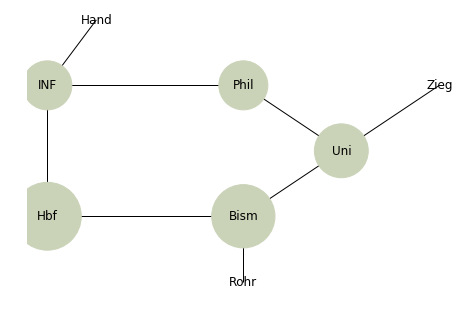

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 75. Mal
Länge der Queue: 43 aktion:load, time:15.True, bm:zykel1.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.Tru

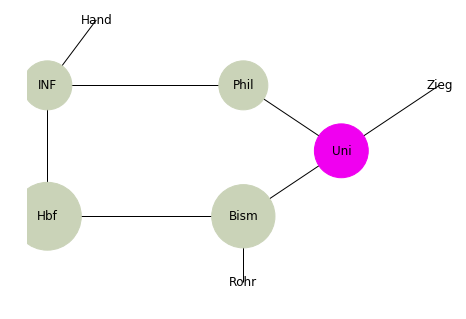

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 7 Plätze frei
29
ExitTime: 23, ListExit: [5, 5]
ExitTime: 23, ListExit: [5, 5]
ExitTime: 23, ListExit: [5, 5]
ExitTime: 23, ListExit: [5, 5]
ExitTime: 33, ListExit: [5, 5, 5, 5]
ExitTime: 28, ListExit: [5, 5, 5]
ExitTime: 33, ListExit: [5, 5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 22 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 76. Mal
Länge der Queue: 50 aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True

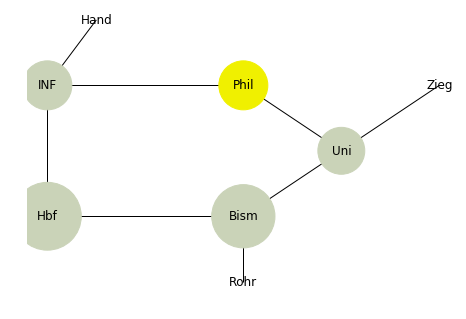

PassagierStation:2, PassagierTime:18, steigt aus, EventTime 18
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 77. Mal
Länge der Queue: 49 aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zub

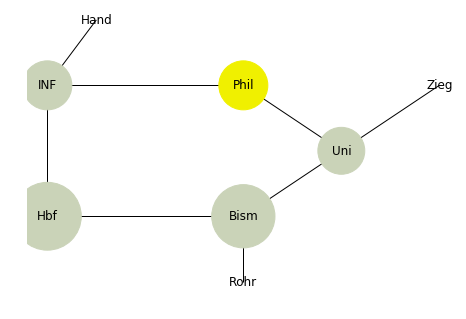

PassagierStation:2, PassagierTime:18, steigt aus, EventTime 18
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 78. Mal
Länge der Queue: 48 aktion:exit, time:18.True, bm:zykel0.True; aktion:exit, time:18.True, bm:zykel1.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:

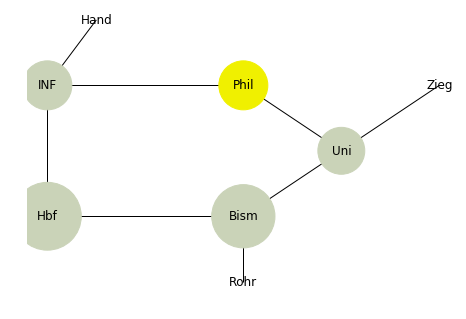

PassagierStation:2, PassagierTime:18, steigt aus, EventTime 18
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 79. Mal
Länge der Queue: 47 aktion:exit, time:18.True, bm:zykel1.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, 

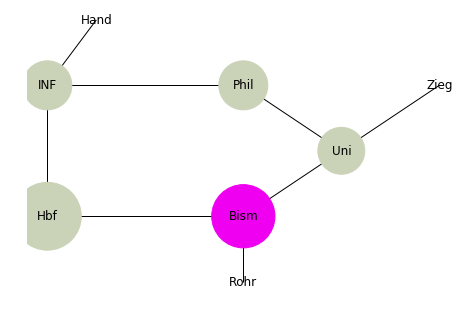

PassagierStation:4, PassagierTime:18, steigt aus, EventTime 18
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 80. Mal
Länge der Queue: 46 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.Tru

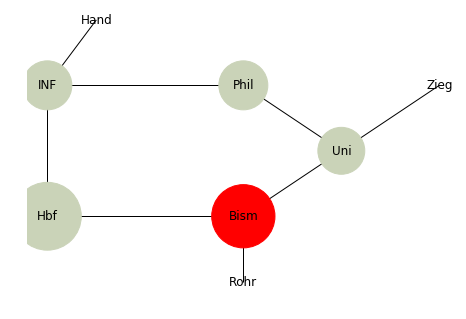

PassagierStation:0, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 0 steigt um.
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 81. Mal
Länge der Queue: 45 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinge

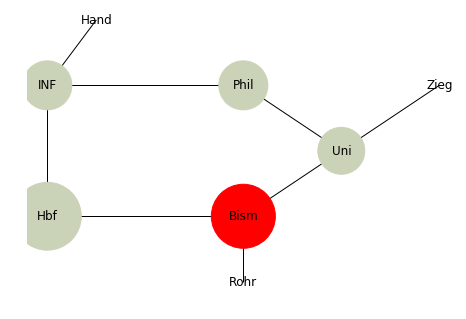

PassagierStation:0, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 82. Mal
Länge der Queue: 44 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; akt

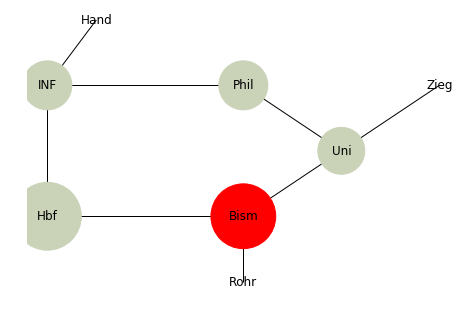

PassagierStation:0, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 83. Mal
Länge der Queue: 43 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; akt

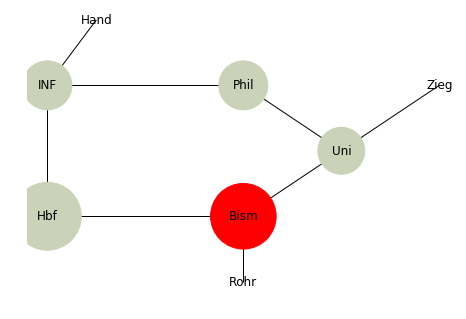

PassagierStation:0, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 84. Mal
Länge der Queue: 42 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion

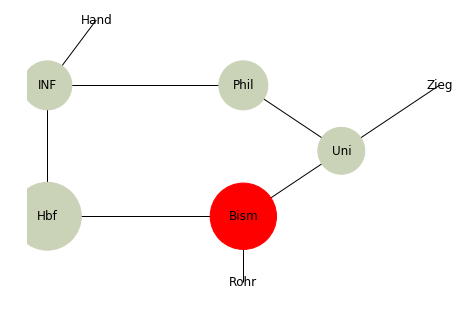

PassagierStation:0, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 85. Mal
Länge der Queue: 41 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:ex

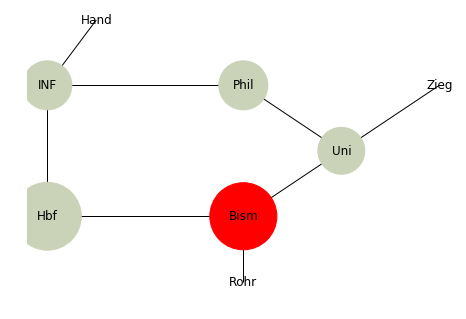

PassagierStation:0, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 86. Mal
Länge der Queue: 40 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, 

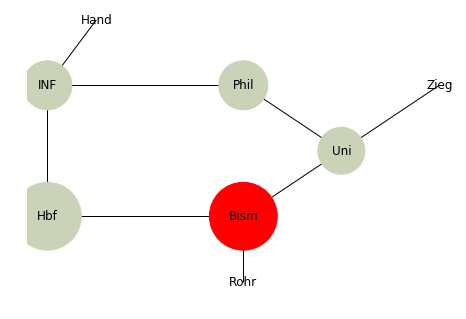

PassagierStation:0, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 0 wurde falsch berechnet.
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 87. Mal
Länge der Queue: 39 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, tim

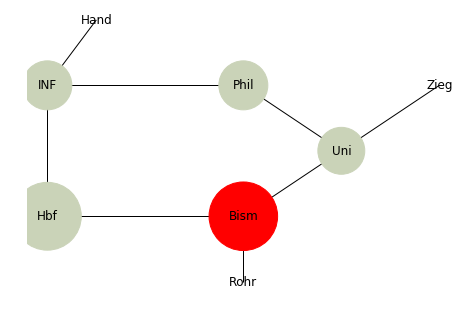

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 7 steigt um.
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 88. Mal
Länge der Queue: 38 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exi

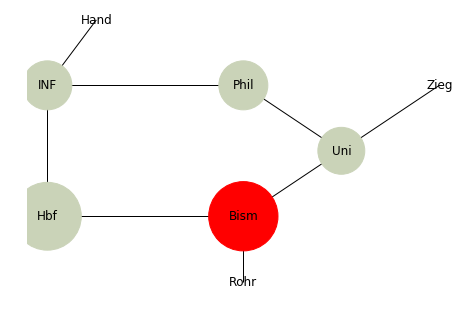

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 89. Mal
Länge der Queue: 37 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.T

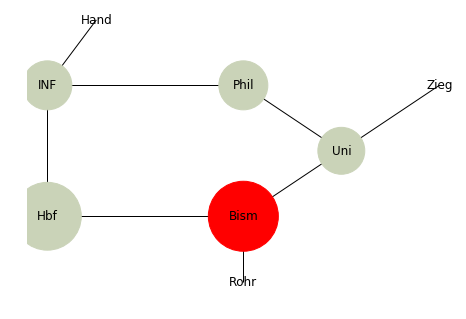

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 90. Mal
Länge der Queue: 36 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True

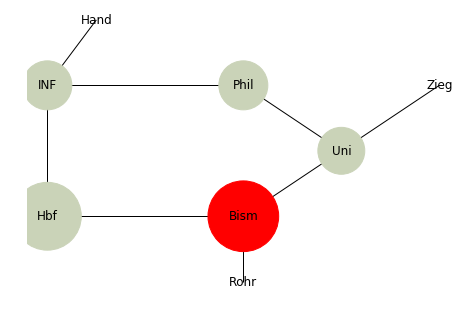

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 91. Mal
Länge der Queue: 35 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, b

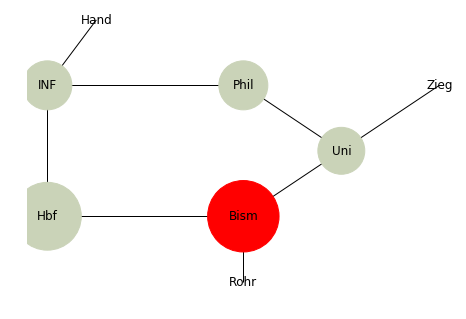

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 92. Mal
Länge der Queue: 34 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:z

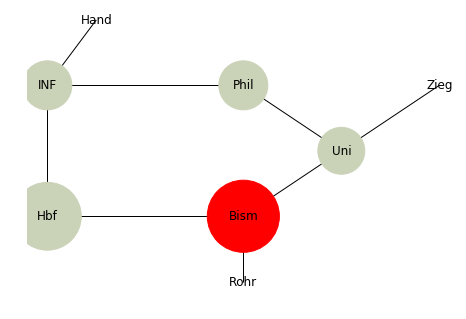

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 93. Mal
Länge der Queue: 33 aktion:exit, time:19.True, bm:zubinger0.True; aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zyke

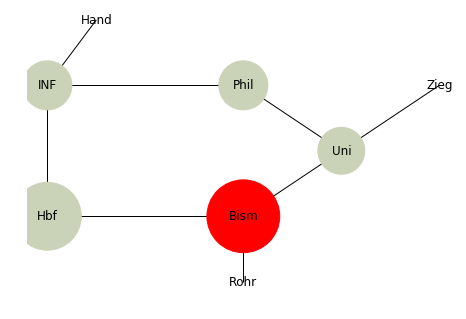

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 94. Mal
Länge der Queue: 32 aktion:exit, time:19.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.

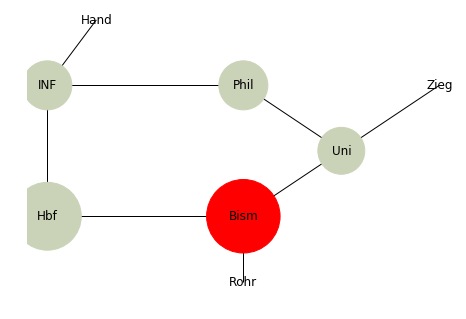

PassagierStation:7, PassagierTime:19, steigt aus, EventTime 19
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zubinger0 zubinger0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 95. Mal
Länge der Queue: 31 aktion:load, time:20.True, bm:zubinger0.True; aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.Tru

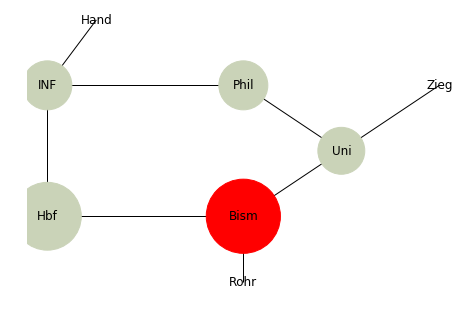

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
55
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5], [3, 7]]
Es warten noch 55 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 96. Mal
Länge der Queue: 31 aktion:load, time:20.True, bm:zubinger1.True; aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:load, time:25.True, bm:zubinger0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.

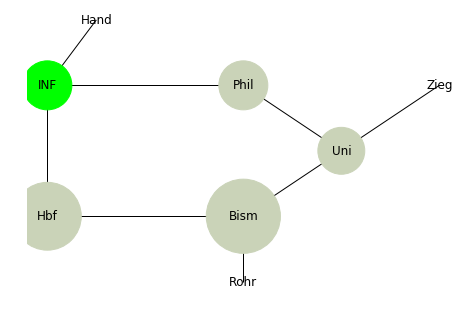

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
24
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6]]
Es warten noch 24 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 97. Mal
Länge der Queue: 31 aktion:load, time:20.True, bm:zubinger2.True; aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; akt

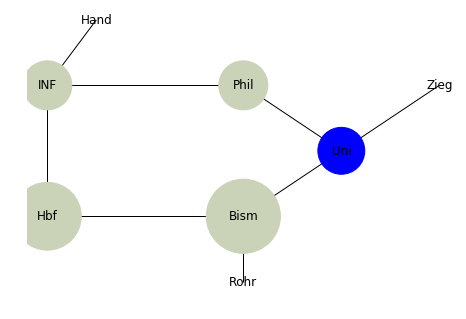

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
22
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6], [3, 7]]
Es warten noch 22 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 98. Mal
Länge der Queue: 31 aktion:load, time:20.True, bm:zykel0.True; aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.T

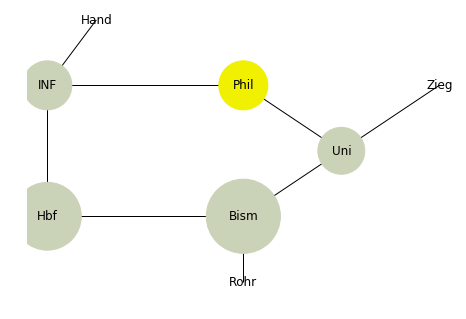

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 3 Plätze frei
24
ExitTime: 38, ListExit: [10, 10]
ExitTime: 28, ListExit: [10]
ExitTime: 28, ListExit: [10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 21 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 99. Mal
Länge der Queue: 34 aktion:load, time:20.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion

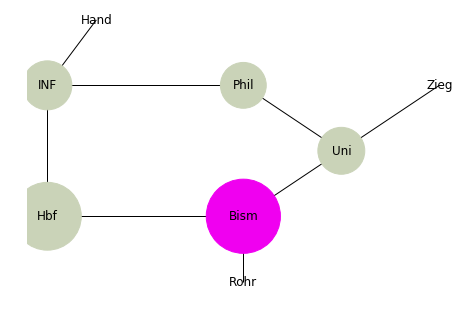

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 1 Plätze frei
55
ExitTime: 38, ListExit: [5, 5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 54 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 100. Mal
Länge der Queue: 35 aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, tim

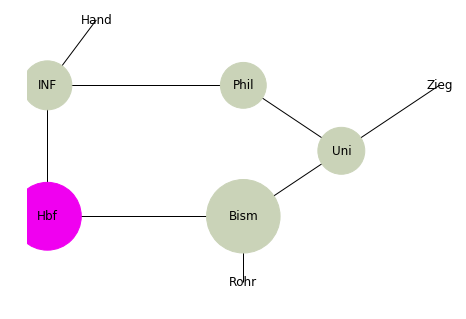

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 23
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 101. Mal
Länge der Queue: 34 aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time

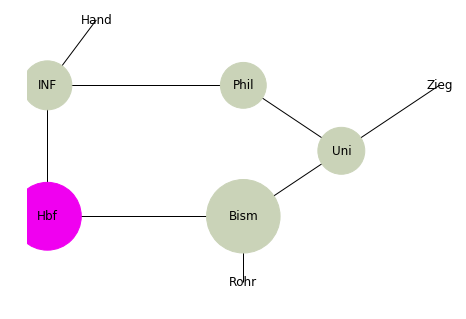

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 23
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 102. Mal
Länge der Queue: 33 aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time

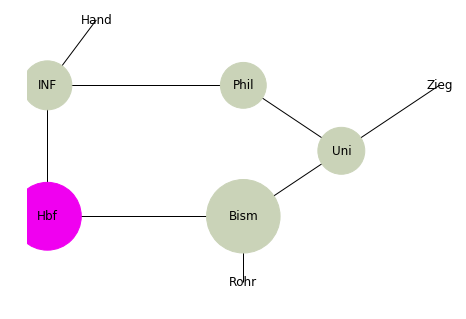

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 23
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 103. Mal
Länge der Queue: 32 aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, tim

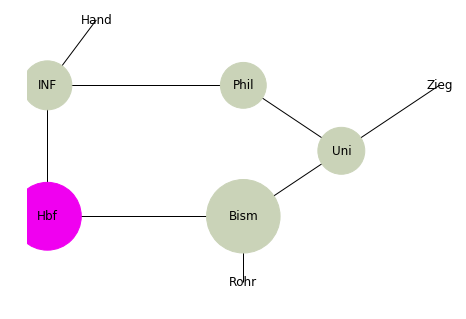

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 23
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 104. Mal
Länge der Queue: 31 aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, ti

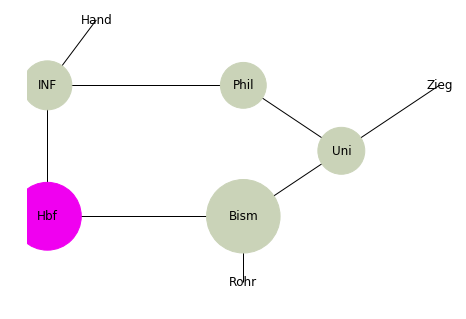

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 23
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 105. Mal
Länge der Queue: 30 aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, t

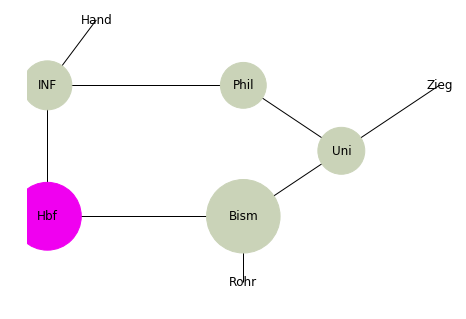

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 23
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 106. Mal
Länge der Queue: 29 aktion:exit, time:23.True, bm:zykel1.True; aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, t

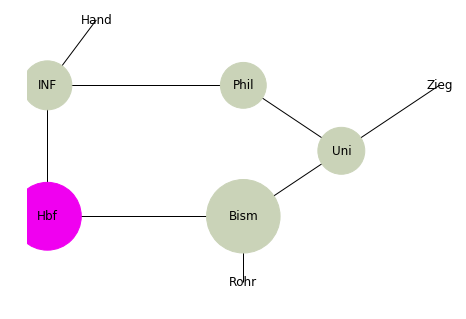

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 23
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 107. Mal
Länge der Queue: 28 aktion:exit, time:23.False, bm:zykel1.False; aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, t

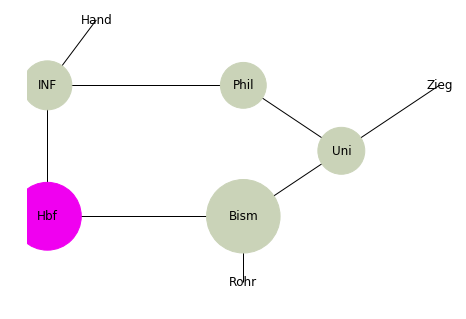

PassagierStation:0, PassagierTime:38, steigt aus, EventTime 23
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [28, 28, 28, 28, 28, 28, 28, 28, 38, 38, 38, 38, 38, 38, 38]
Event BM: zykel1 CList: [28, 28, 33, 28, 28, 33, 38]
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 108. Mal
Länge der Queue: 27 aktion:load, time:25.True, bm:zubinger0.True; aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; akti

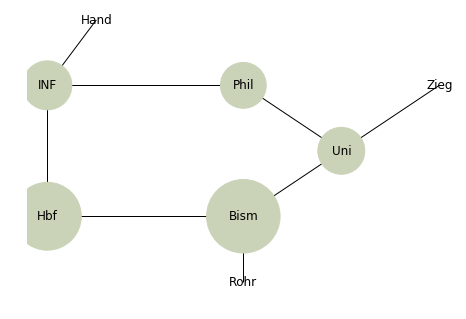

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 109. Mal
Länge der Queue: 27 aktion:load, time:25.True, bm:zubinger1.True; aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zykel0.True; aktion:exit, time:33.True, bm:zykel1.True; akt

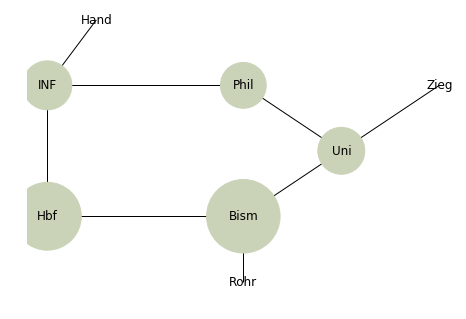

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 110. Mal
Länge der Queue: 27 aktion:load, time:25.True, bm:zubinger2.True; aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zykel0.True; aktion:exit, time:33.True, bm:zykel1.True; akt

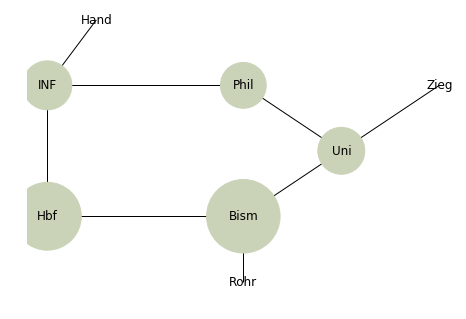

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 111. Mal
Länge der Queue: 27 aktion:load, time:25.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:exit, time:33.True, bm:zykel1.True; akt

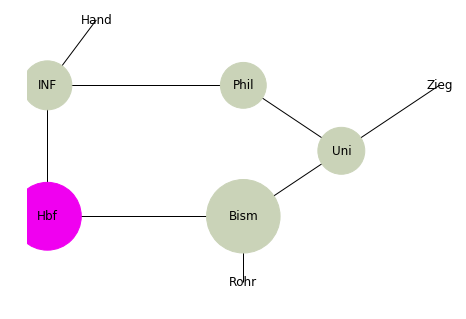

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 8 Plätze frei
46
ExitTime: 43, ListExit: [5, 5, 5, 5]
ExitTime: 38, ListExit: [5, 5, 5]
ExitTime: 28, ListExit: [5]
ExitTime: 33, ListExit: [5, 5]
ExitTime: 28, ListExit: [5]
ExitTime: 28, ListExit: [5]
ExitTime: 33, ListExit: [5, 5]
ExitTime: 38, ListExit: [5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 38 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 112. Mal
Länge der Queue: 35 aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True

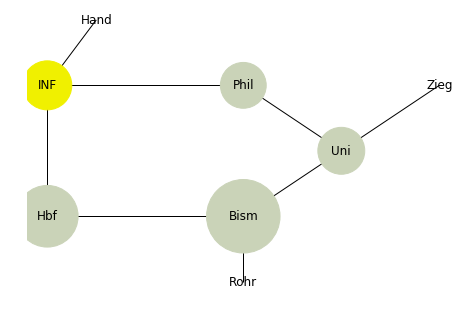

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 113. Mal
Länge der Queue: 34 aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, ti

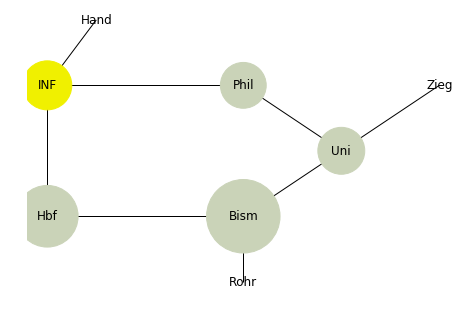

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 114. Mal
Länge der Queue: 33 aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, ti

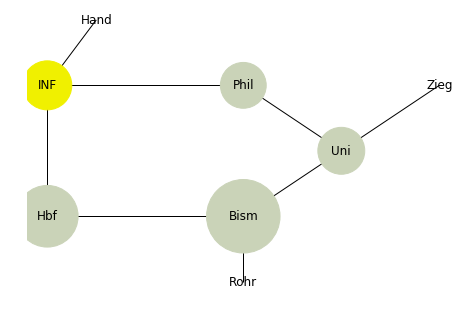

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 115. Mal
Länge der Queue: 32 aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, ti

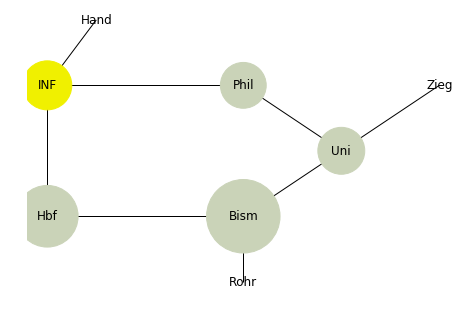

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 116. Mal
Länge der Queue: 31 aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, ti

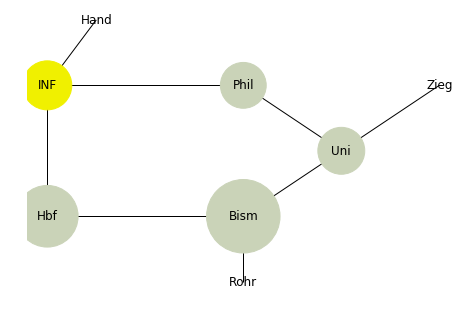

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 117. Mal
Länge der Queue: 30 aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, ti

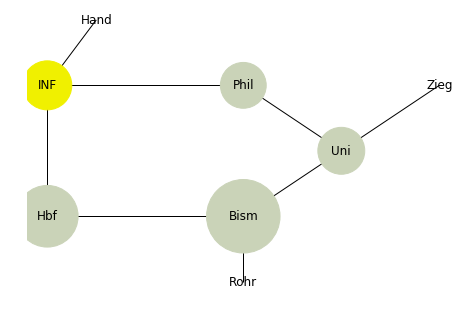

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 118. Mal
Länge der Queue: 29 aktion:exit, time:28.True, bm:zykel0.True; aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, tim

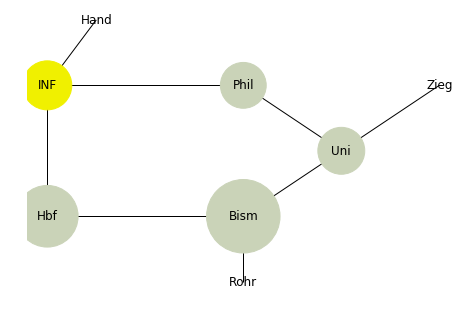

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 119. Mal
Länge der Queue: 28 aktion:exit, time:28.True, bm:zykel0.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, tim

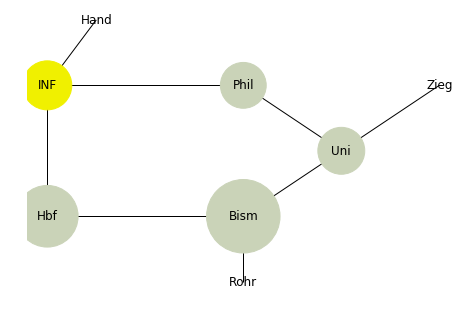

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 120. Mal
Länge der Queue: 27 aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, ti

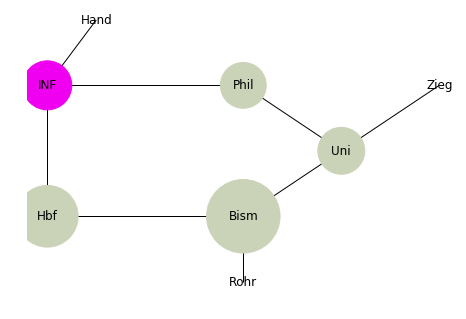

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 121. Mal
Länge der Queue: 26 aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, ti

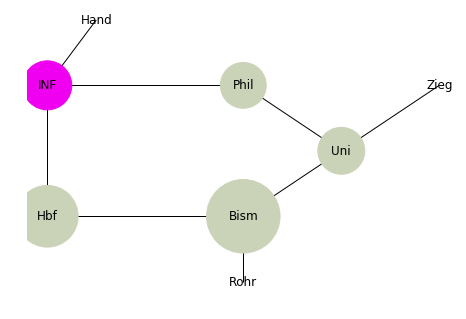

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 122. Mal
Länge der Queue: 25 aktion:exit, time:28.True, bm:zykel1.False; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, tim

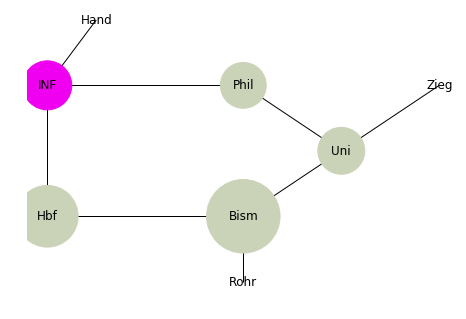

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 123. Mal
Länge der Queue: 24 aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time

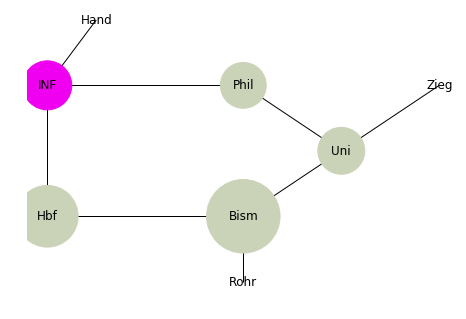

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 124. Mal
Länge der Queue: 23 aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time

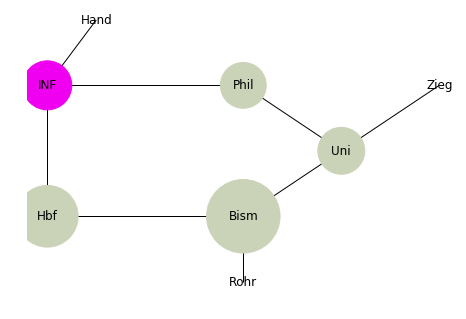

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 125. Mal
Länge der Queue: 22 aktion:exit, time:28.True, bm:zykel1.True; aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time

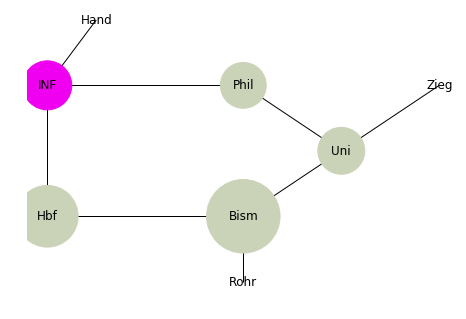

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 126. Mal
Länge der Queue: 21 aktion:exit, time:28.True, bm:zykel1.True; aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:

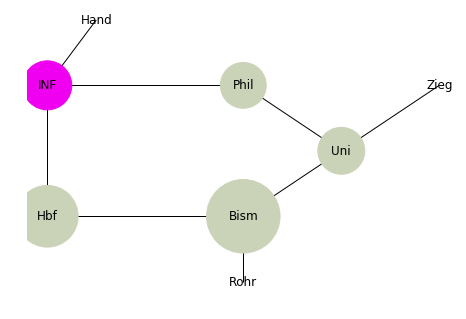

PassagierStation:1, PassagierTime:28, steigt aus, EventTime 28
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 127. Mal
Länge der Queue: 20 aktion:load, time:30.True, bm:zubinger0.True; aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:

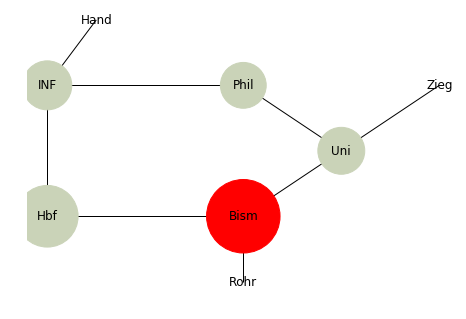

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
54
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 54 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 128. Mal
Länge der Queue: 20 aktion:load, time:30.True, bm:zubinger1.True; aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel1.True;

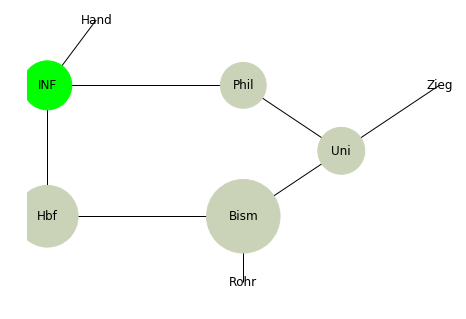

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
24
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6]]
Es warten noch 24 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 129. Mal
Länge der Queue: 20 aktion:load, time:30.True, bm:zubinger2.True; aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel1.True; 

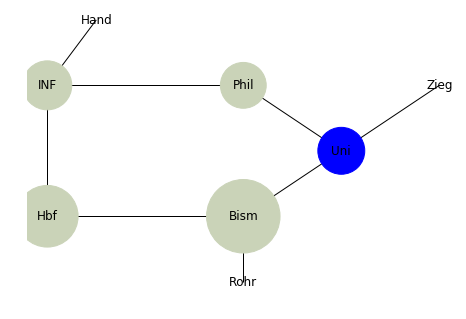

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
22
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6], [3, 7]]
Es warten noch 22 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 130. Mal
Länge der Queue: 20 aktion:load, time:30.True, bm:zykel0.True; aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel

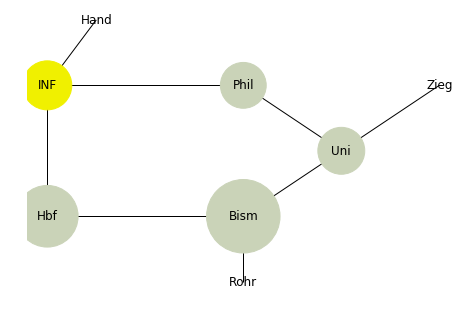

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 8 Plätze frei
24
ExitTime: 38, ListExit: [10]
ExitTime: 68, ListExit: [10, 10, 10, 10]
ExitTime: 68, ListExit: [10, 10, 10, 10]
ExitTime: 38, ListExit: [10]
ExitTime: 58, ListExit: [10, 10, 10]
ExitTime: 68, ListExit: [10, 10, 10, 10]
ExitTime: 58, ListExit: [10, 10, 10]
ExitTime: 58, ListExit: [10, 10, 10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 16 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 131. Mal
Länge der Queue: 28 aktion:load, time:30.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38

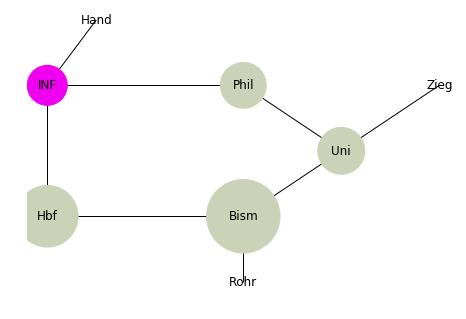

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 7 Plätze frei
16
ExitTime: 43, ListExit: [5, 5, 5]
ExitTime: 33, ListExit: [5]
ExitTime: 38, ListExit: [5, 5]
ExitTime: 38, ListExit: [5, 5]
ExitTime: 38, ListExit: [5, 5]
ExitTime: 48, ListExit: [5, 5, 5, 5]
ExitTime: 48, ListExit: [5, 5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 9 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 132. Mal
Länge der Queue: 35 aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True

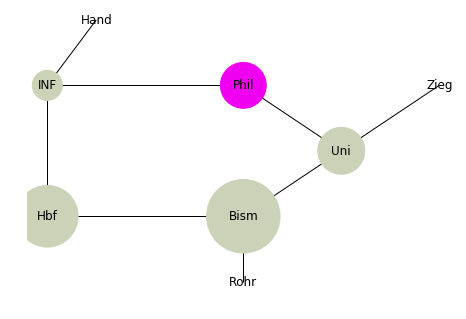

PassagierStation:2, PassagierTime:33, steigt aus, EventTime 33
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 133. Mal
Länge der Queue: 34 aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, 

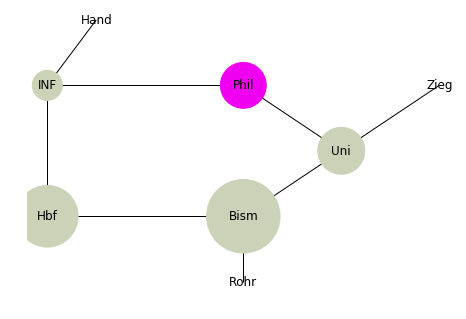

PassagierStation:2, PassagierTime:33, steigt aus, EventTime 33
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 134. Mal
Länge der Queue: 33 aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, 

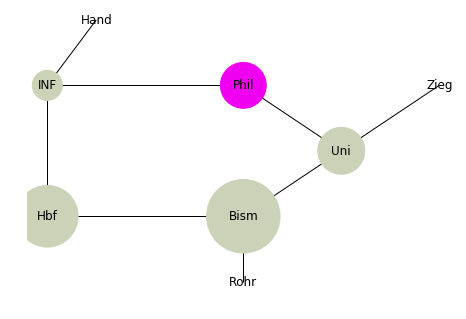

PassagierStation:2, PassagierTime:33, steigt aus, EventTime 33
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 135. Mal
Länge der Queue: 32 aktion:exit, time:33.True, bm:zykel1.True; aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, 

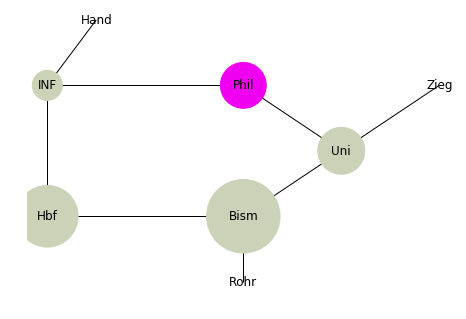

PassagierStation:2, PassagierTime:33, steigt aus, EventTime 33
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 136. Mal
Länge der Queue: 31 aktion:exit, time:33.True, bm:zykel1.True; aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, 

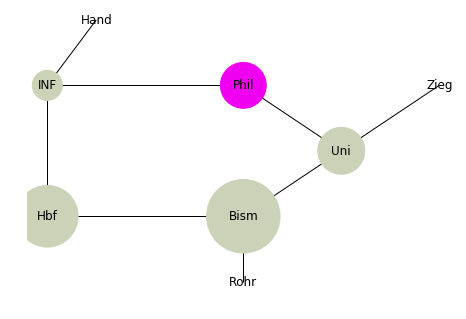

PassagierStation:2, PassagierTime:33, steigt aus, EventTime 33
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 137. Mal
Länge der Queue: 30 aktion:load, time:35.True, bm:zubinger0.True; aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, 

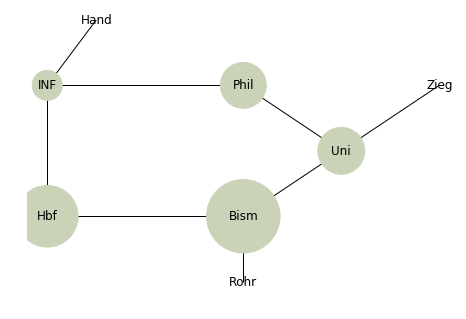

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 138. Mal
Länge der Queue: 30 aktion:load, time:35.True, bm:zubinger1.True; aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; akti

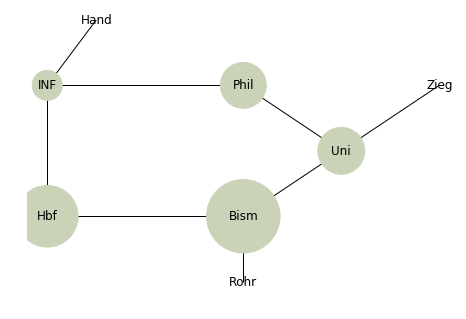

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 139. Mal
Länge der Queue: 30 aktion:load, time:35.True, bm:zubinger2.True; aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; akti

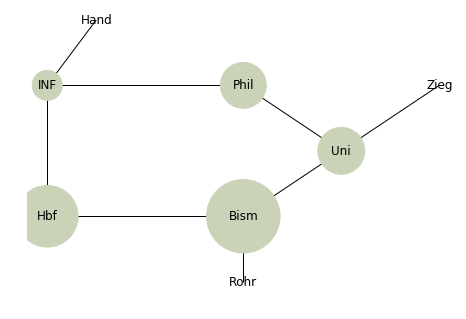

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 140. Mal
Länge der Queue: 30 aktion:load, time:35.True, bm:zykel1.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; akti

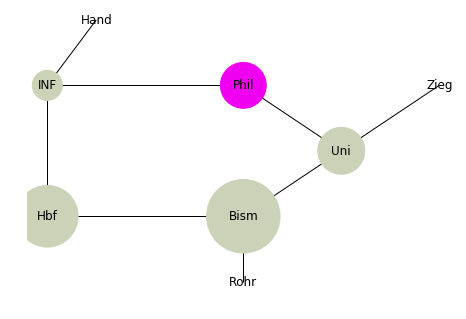

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 5 Plätze frei
21
ExitTime: 53, ListExit: [5, 5, 5, 5]
ExitTime: 38, ListExit: [5]
ExitTime: 53, ListExit: [5, 5, 5, 5]
ExitTime: 48, ListExit: [5, 5, 5]
ExitTime: 38, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 16 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 141. Mal
Länge der Queue: 35 aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.

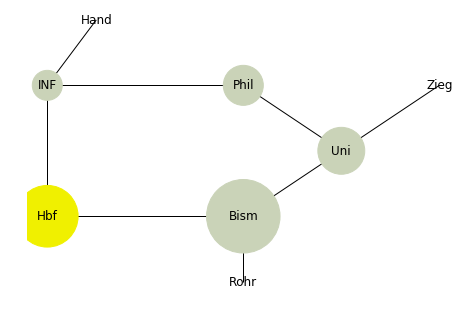

PassagierStation:0, PassagierTime:23, steigt aus, EventTime 38
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [38, 38, 38, 38, 38, 38, 38, 38, 43, 43, 48, 48, 48, 53, 53]
Event BM: zykel0 CList: [38, 38, 38, 38, 38, 38, 68, 38, 38, 58, 58, 58, 68, 68]
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 142. Mal
Länge der Queue: 34 aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.Tru

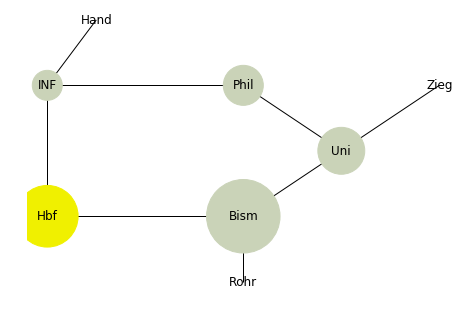

PassagierStation:0, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 143. Mal
Länge der Queue: 33 aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, tim

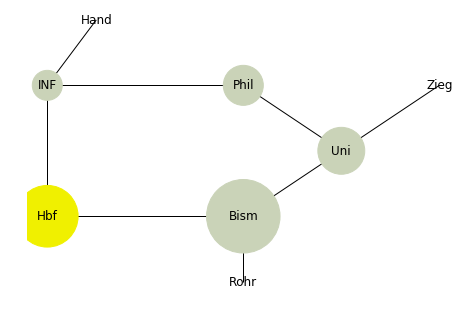

PassagierStation:0, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 144. Mal
Länge der Queue: 32 aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, 

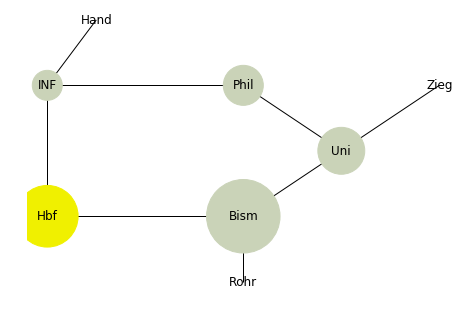

PassagierStation:0, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 145. Mal
Länge der Queue: 31 aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, 

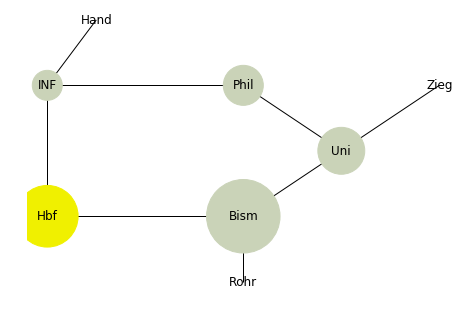

PassagierStation:0, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 146. Mal
Länge der Queue: 30 aktion:exit, time:38.True, bm:zykel0.True; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, 

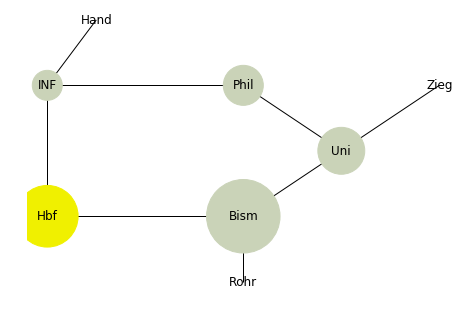

PassagierStation:0, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 147. Mal
Länge der Queue: 29 aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, t

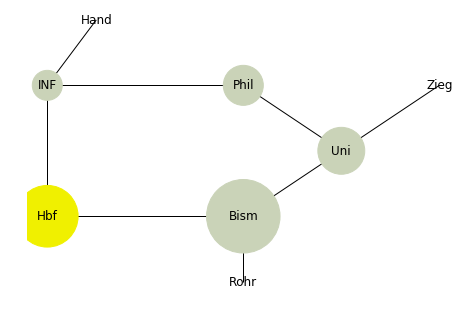

PassagierStation:0, PassagierTime:48, steigt aus, EventTime 38
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [38, 38, 38, 38, 38, 38, 38, 38, 43, 43, 48, 48, 48, 53, 53]
Event BM: zykel0 CList: [38, 38, 58, 58, 58, 68, 68, 68]
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 148. Mal
Länge der Queue: 28 aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True;

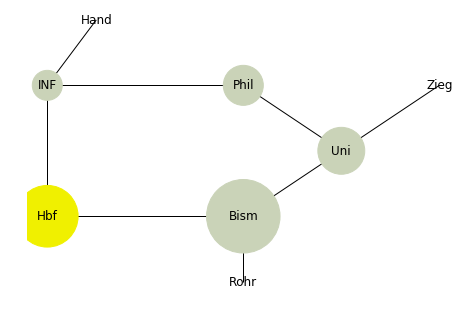

PassagierStation:0, PassagierTime:48, steigt aus, EventTime 38
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [38, 38, 38, 38, 38, 38, 38, 38, 43, 43, 48, 48, 48, 53, 53]
Event BM: zykel0 CList: [38, 58, 58, 58, 68, 68, 68]
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 149. Mal
Länge der Queue: 27 aktion:exit, time:38.False, bm:zykel0.False; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktio

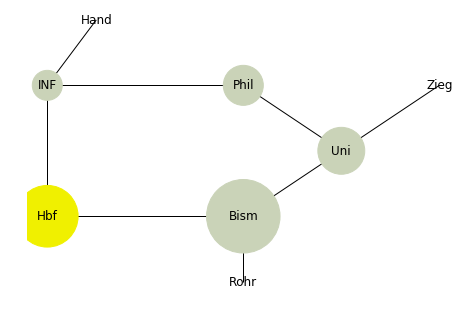

PassagierStation:0, PassagierTime:48, steigt aus, EventTime 38
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [38, 38, 38, 38, 38, 38, 38, 38, 43, 43, 48, 48, 48, 53, 53]
Event BM: zykel0 CList: [58, 58, 68, 58, 68, 68]
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 150. Mal
Länge der Queue: 26 aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit

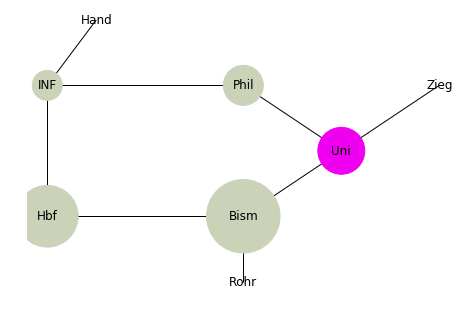

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 151. Mal
Länge der Queue: 25 aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:5

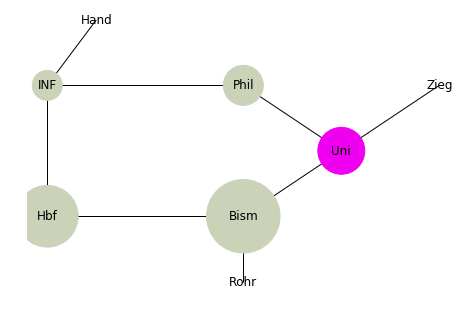

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 152. Mal
Länge der Queue: 24 aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:5

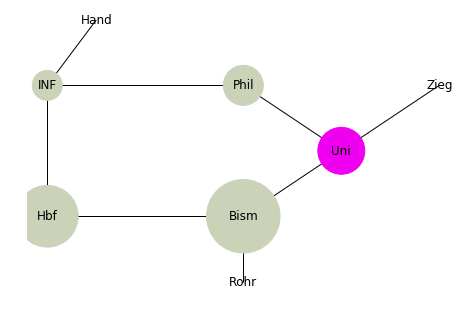

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 153. Mal
Länge der Queue: 23 aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:5

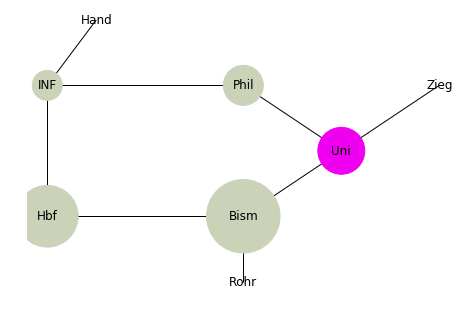

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 154. Mal
Länge der Queue: 22 aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time

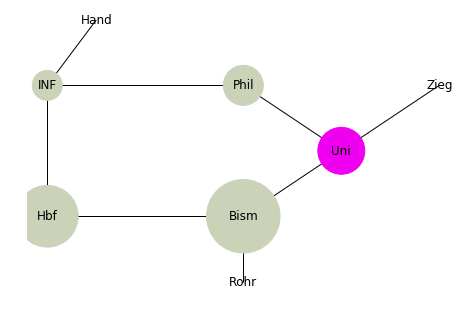

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 155. Mal
Länge der Queue: 21 aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, ti

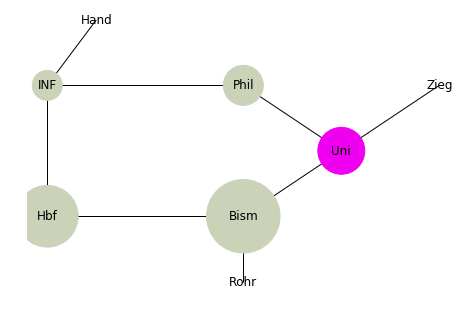

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 156. Mal
Länge der Queue: 20 aktion:exit, time:38.True, bm:zykel1.True; aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, t

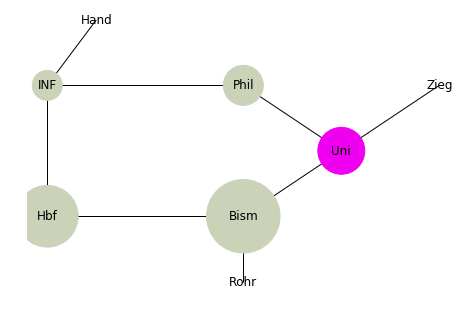

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 157. Mal
Länge der Queue: 19 aktion:exit, time:38.True, bm:zykel1.True; aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit,

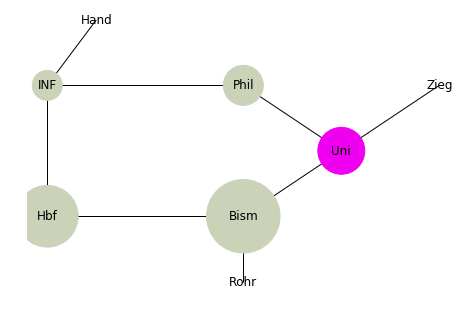

PassagierStation:3, PassagierTime:38, steigt aus, EventTime 38
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 158. Mal
Länge der Queue: 18 aktion:load, time:40.True, bm:zubinger0.True; aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exi

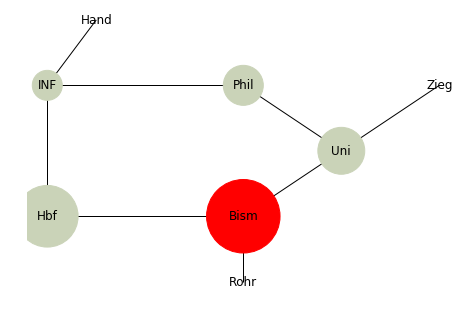

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
54
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 54 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 159. Mal
Länge der Queue: 18 aktion:load, time:40.True, bm:zubinger1.True; aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:load, time:45.True, bm:zubinger0.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel

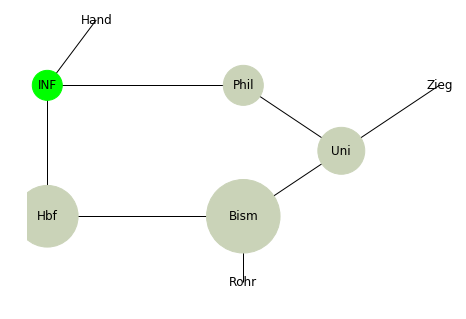

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
9
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6], [3, 7]]
Es warten noch 9 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 160. Mal
Länge der Queue: 18 aktion:load, time:40.True, bm:zubinger2.True; aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:load, time:45.True, bm:zubinger0.True; aktion:load, time:45.True, bm:zubinger1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:

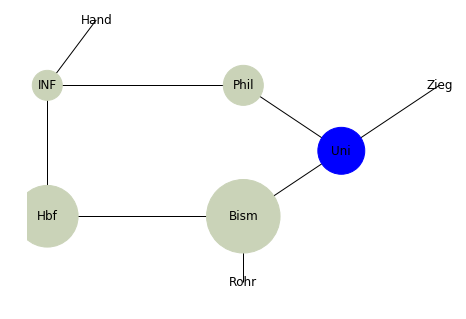

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
22
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6], [3, 7]]
Es warten noch 22 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 161. Mal
Länge der Queue: 18 aktion:load, time:40.True, bm:zykel0.True; aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:load, time:45.True, bm:zubinger0.True; aktion:load, time:45.True, bm:zubinger1.True; aktion:load, time:45.True, bm:zubinger2.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, b

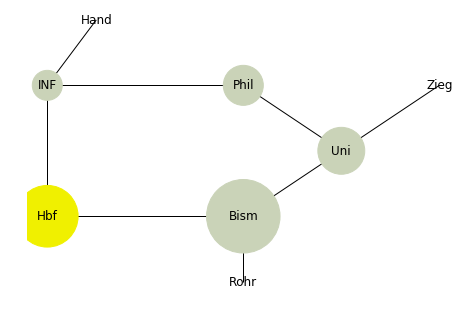

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 9 Plätze frei
38
ExitTime: 78, ListExit: [10, 10, 10, 10]
ExitTime: 78, ListExit: [10, 10, 10, 10]
ExitTime: 58, ListExit: [10, 10]
ExitTime: 58, ListExit: [10, 10]
ExitTime: 78, ListExit: [10, 10, 10, 10]
ExitTime: 68, ListExit: [10, 10, 10]
ExitTime: 78, ListExit: [10, 10, 10, 10]
ExitTime: 68, ListExit: [10, 10, 10]
ExitTime: 78, ListExit: [10, 10, 10, 10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 29 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 162. Mal
Länge der Queue: 27 aktion:load, time:40.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:load, time:45.True, bm:zubinger0.True; aktion:load, time:45.True, bm:zubinger1.True; aktion:load, time:45.True, bm:zubinger2.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zykel0.True; aktion:exit,

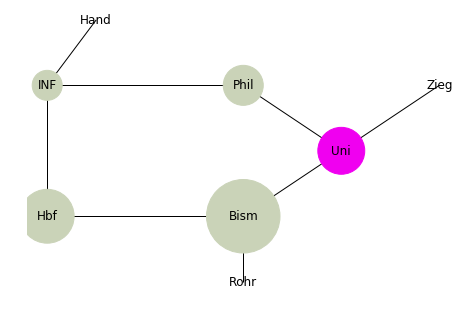

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 8 Plätze frei
22
ExitTime: 53, ListExit: [5, 5, 5]
ExitTime: 58, ListExit: [5, 5, 5, 5]
ExitTime: 58, ListExit: [5, 5, 5, 5]
ExitTime: 53, ListExit: [5, 5, 5]
ExitTime: 53, ListExit: [5, 5, 5]
ExitTime: 53, ListExit: [5, 5, 5]
ExitTime: 58, ListExit: [5, 5, 5, 5]
ExitTime: 53, ListExit: [5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 14 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 163. Mal
Länge der Queue: 35 aktion:exit, time:43.True, bm:zykel1.True; aktion:exit, time:43.True, bm:zykel1.True; aktion:load, time:45.True, bm:zubinger0.True; aktion:load, time:45.True, bm:zubinger1.True; aktion:load, time:45.True, bm:zubinger2.True; aktion:load, time:45.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zykel0.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zyk

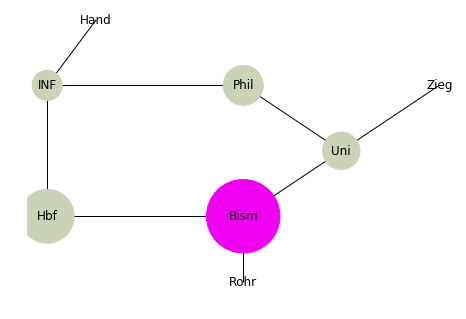

PassagierStation:4, PassagierTime:43, steigt aus, EventTime 43
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 164. Mal
Länge der Queue: 34 aktion:exit, time:43.True, bm:zykel1.True; aktion:load, time:45.True, bm:zubinger0.True; aktion:load, time:45.True, bm:zubinger1.True; aktion:load, time:45.True, bm:zubinger2.True; aktion:load, time:45.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zykel0.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time

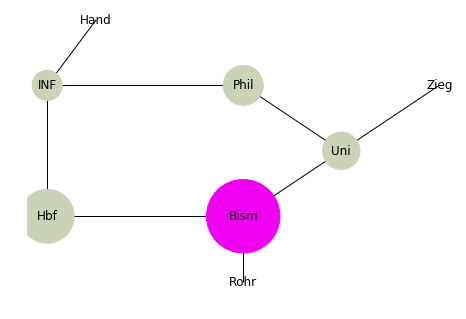

PassagierStation:4, PassagierTime:43, steigt aus, EventTime 43
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 165. Mal
Länge der Queue: 33 aktion:load, time:45.True, bm:zubinger0.True; aktion:load, time:45.True, bm:zubinger1.True; aktion:load, time:45.True, bm:zubinger2.True; aktion:load, time:45.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zykel0.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, ti

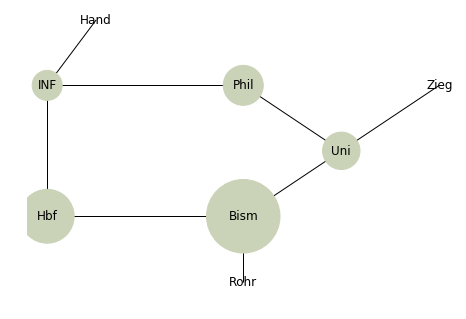

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 166. Mal
Länge der Queue: 33 aktion:load, time:45.True, bm:zubinger1.True; aktion:load, time:45.True, bm:zubinger2.True; aktion:load, time:45.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zykel0.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; a

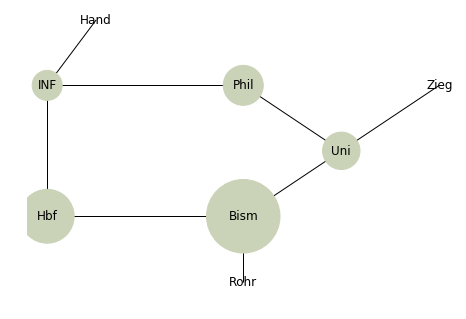

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 167. Mal
Länge der Queue: 33 aktion:load, time:45.True, bm:zubinger2.True; aktion:load, time:45.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zykel0.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; a

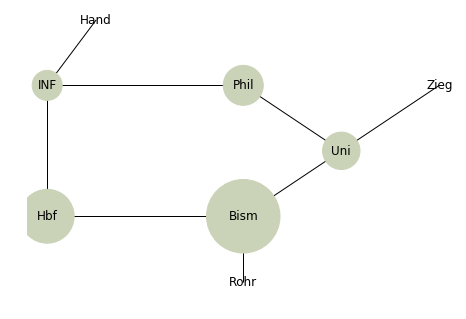

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 168. Mal
Länge der Queue: 33 aktion:load, time:45.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; a

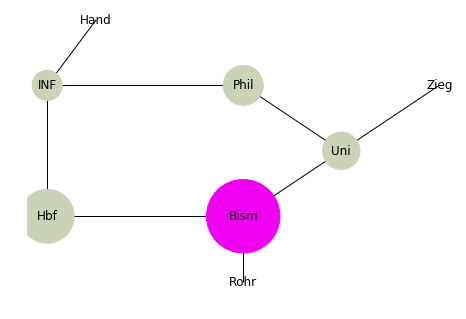

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 2 Plätze frei
54
ExitTime: 48, ListExit: [5]
ExitTime: 53, ListExit: [5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 169. Mal
Länge der Queue: 35 aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.Tr

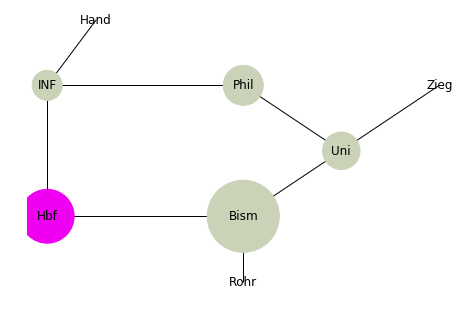

PassagierStation:0, PassagierTime:48, steigt aus, EventTime 48
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 170. Mal
Länge der Queue: 34 aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time

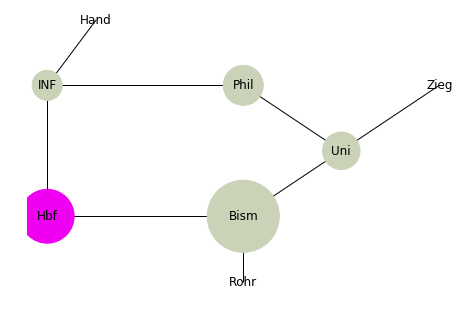

PassagierStation:0, PassagierTime:48, steigt aus, EventTime 48
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 171. Mal
Länge der Queue: 33 aktion:exit, time:48.True, bm:zykel1.True; aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, ti

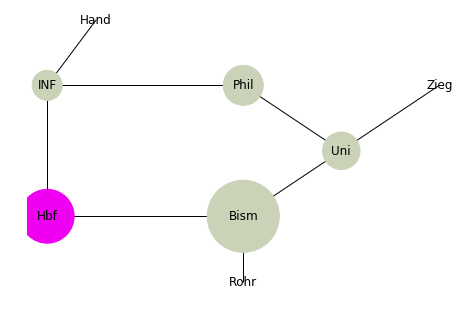

PassagierStation:0, PassagierTime:48, steigt aus, EventTime 48
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 172. Mal
Länge der Queue: 32 aktion:exit, time:48.True, bm:zykel1.True; aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, 

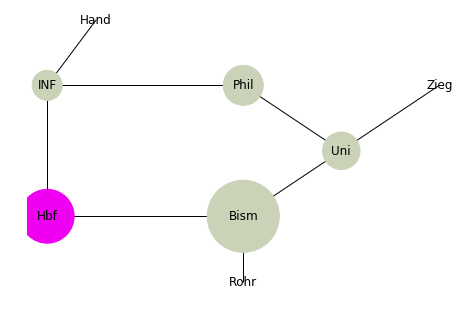

PassagierStation:0, PassagierTime:48, steigt aus, EventTime 48
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 173. Mal
Länge der Queue: 31 aktion:load, time:50.True, bm:zubinger0.True; aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel0.True; aktion:exit, 

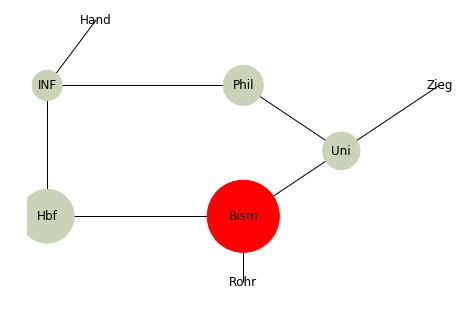

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
52
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 174. Mal
Länge der Queue: 31 aktion:load, time:50.True, bm:zubinger1.True; aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel0.T

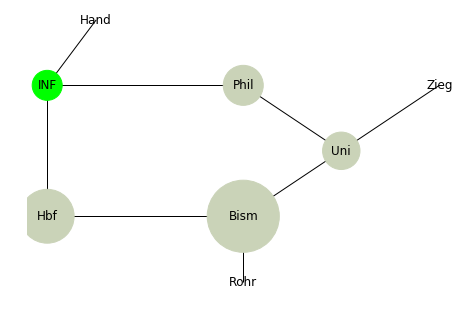

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
9
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[1, 6], [3, 7]]
Es warten noch 9 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 175. Mal
Länge der Queue: 31 aktion:load, time:50.True, bm:zubinger2.True; aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zyk

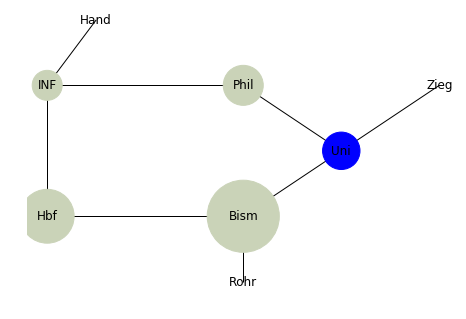

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
14
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5], [3, 7]]
Es warten noch 14 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 176. Mal
Länge der Queue: 31 aktion:load, time:50.True, bm:zykel0.True; aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:z

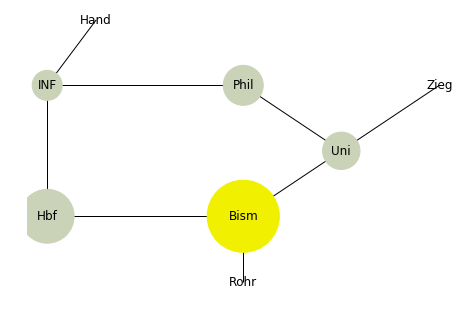

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 0 Plätze frei
52
Berechne, wer zukünftig umsteigen soll
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 177. Mal
Länge der Queue: 31 aktion:load, time:50.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel0.True; aktion:exit, time:58.True, bm:zykel0.True; aktion:exit, time:58.True, bm:zykel1.True; aktion

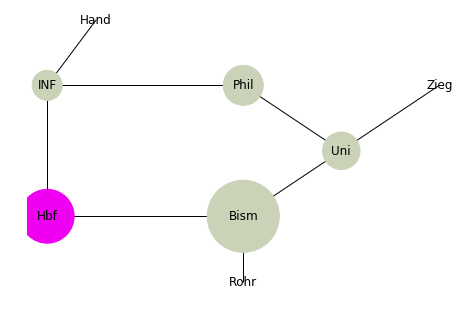

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 4 Plätze frei
29
ExitTime: 63, ListExit: [5, 5, 5]
ExitTime: 58, ListExit: [5, 5]
ExitTime: 53, ListExit: [5]
ExitTime: 63, ListExit: [5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 25 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 178. Mal
Länge der Queue: 35 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit

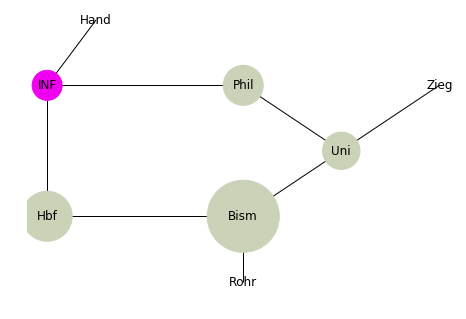

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 179. Mal
Länge der Queue: 34 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:ex

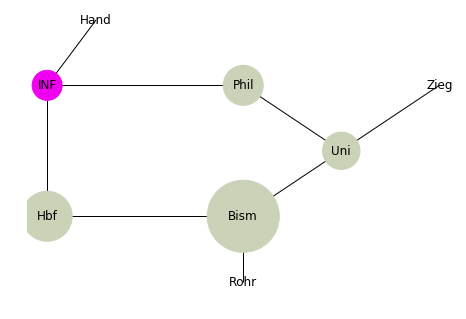

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 180. Mal
Länge der Queue: 33 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:ex

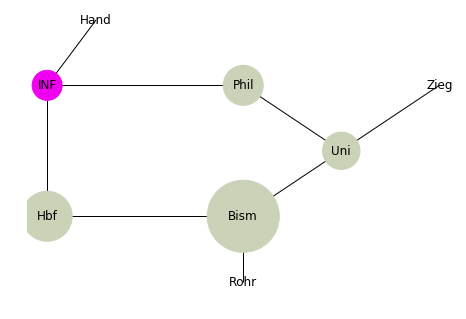

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 181. Mal
Länge der Queue: 32 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:ex

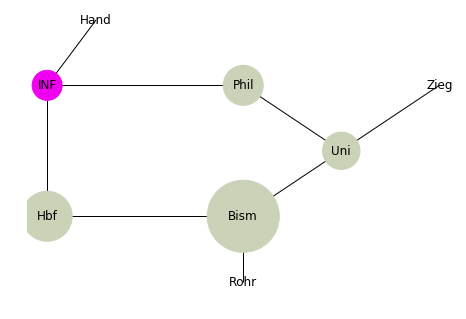

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 182. Mal
Länge der Queue: 31 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:ex

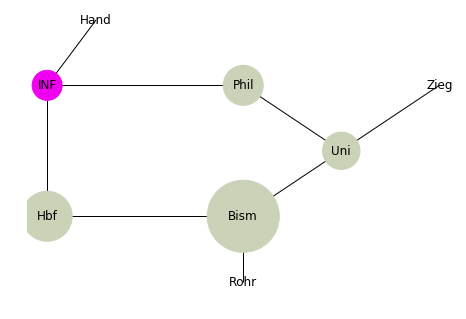

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 183. Mal
Länge der Queue: 30 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:lo

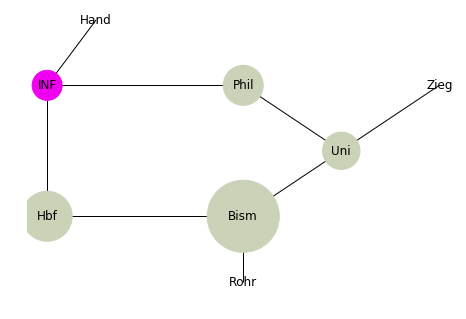

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 184. Mal
Länge der Queue: 29 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zykel0.True; aktion:exi

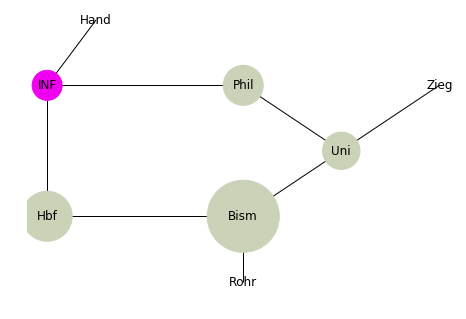

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 185. Mal
Länge der Queue: 28 aktion:exit, time:53.True, bm:zykel1.True; aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zykel0.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exi

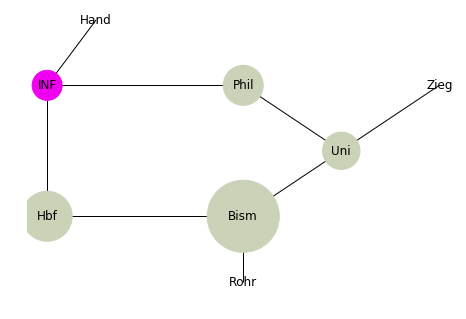

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 186. Mal
Länge der Queue: 27 aktion:exit, time:53.True, bm:zykel1.True; aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zykel0.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exi

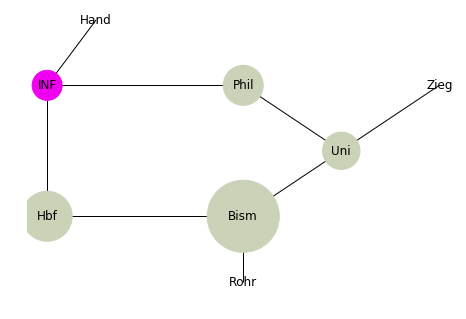

PassagierStation:1, PassagierTime:53, steigt aus, EventTime 53
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 187. Mal
Länge der Queue: 26 aktion:load, time:55.True, bm:zubinger0.True; aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zykel0.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:e

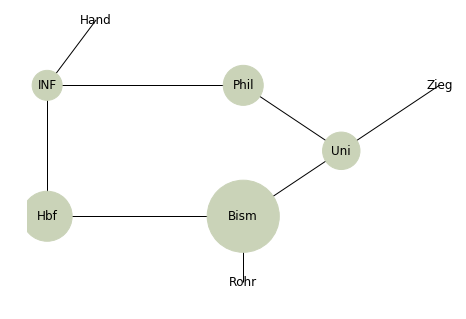

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 188. Mal
Länge der Queue: 26 aktion:load, time:55.True, bm:zubinger1.True; aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zykel0.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.

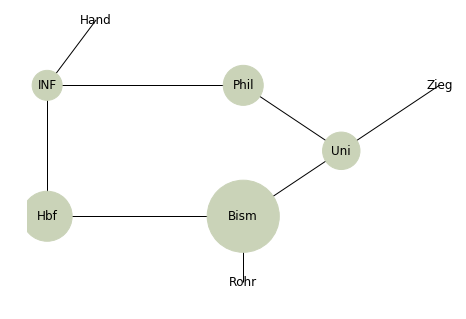

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 189. Mal
Länge der Queue: 26 aktion:load, time:55.True, bm:zubinger2.True; aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zykel0.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.

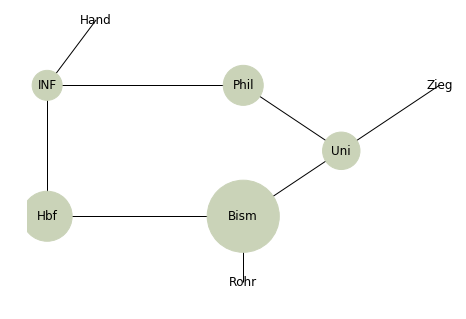

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 190. Mal
Länge der Queue: 26 aktion:load, time:55.True, bm:zykel1.True; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.

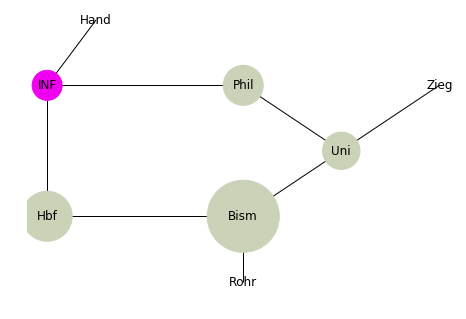

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 9 Plätze frei
9
ExitTime: 63, ListExit: [5, 5]
ExitTime: 73, ListExit: [5, 5, 5, 5]
ExitTime: 58, ListExit: [5]
ExitTime: 58, ListExit: [5]
ExitTime: 58, ListExit: [5]
ExitTime: 73, ListExit: [5, 5, 5, 5]
ExitTime: 63, ListExit: [5, 5]
ExitTime: 73, ListExit: [5, 5, 5, 5]
ExitTime: 58, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 191. Mal
Länge der Queue: 35 aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:

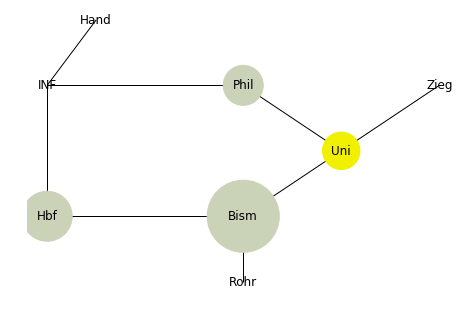

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 58
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [58, 58, 58, 58, 58, 58, 58, 58, 63, 63, 63, 63, 73, 73, 73]
Event BM: zykel0 CList: [58, 58, 68, 58, 58, 68, 78, 68, 68, 68, 78, 78, 78, 78]
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 192. Mal
Länge der Queue: 34 aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:6

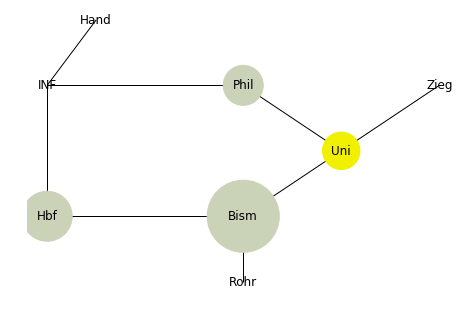

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 58
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [58, 58, 58, 58, 58, 58, 58, 58, 63, 63, 63, 63, 73, 73, 73]
Event BM: zykel0 CList: [58, 58, 68, 58, 68, 68, 78, 68, 68, 78, 78, 78, 78]
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 193. Mal
Länge der Queue: 33 aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.T

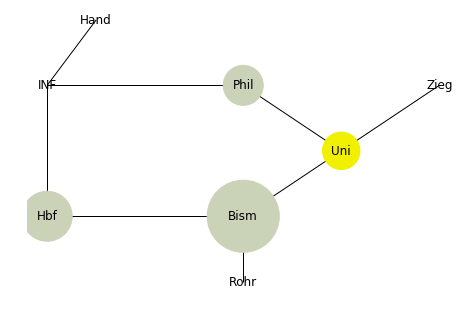

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 58
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [58, 58, 58, 58, 58, 58, 58, 58, 63, 63, 63, 63, 73, 73, 73]
Event BM: zykel0 CList: [58, 58, 68, 68, 68, 68, 78, 68, 78, 78, 78, 78]
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 194. Mal
Länge der Queue: 32 aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True

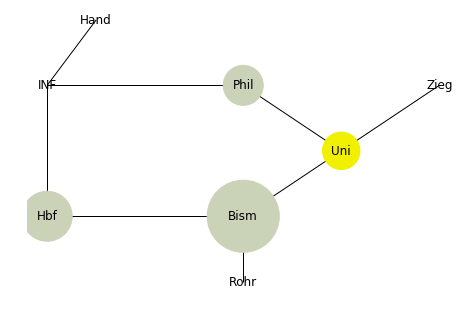

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 58
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [58, 58, 58, 58, 58, 58, 58, 58, 63, 63, 63, 63, 73, 73, 73]
Event BM: zykel0 CList: [58, 68, 68, 68, 78, 68, 78, 68, 78, 78, 78]
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 195. Mal
Länge der Queue: 31 aktion:exit, time:58.False, bm:zykel0.False; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:z

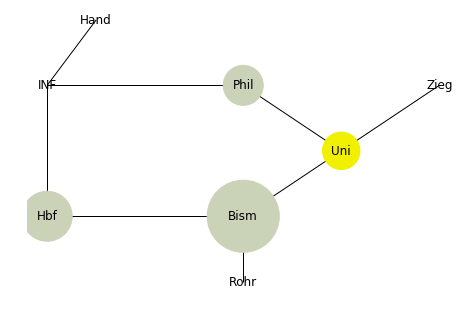

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 58
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [58, 58, 58, 58, 58, 58, 58, 58, 63, 63, 63, 63, 73, 73, 73]
Event BM: zykel0 CList: [68, 68, 68, 68, 78, 78, 78, 68, 78, 78]
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 196. Mal
Länge der Queue: 30 aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.

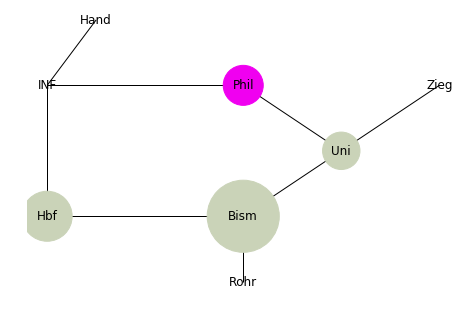

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 197. Mal
Länge der Queue: 29 aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time

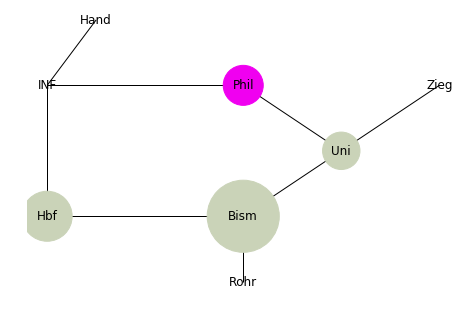

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 198. Mal
Länge der Queue: 28 aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, ti

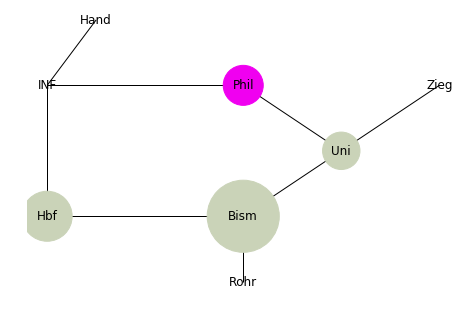

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 199. Mal
Länge der Queue: 27 aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, 

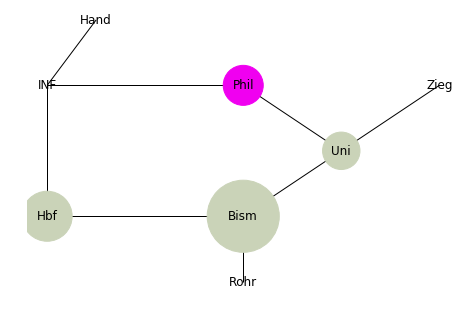

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 200. Mal
Länge der Queue: 26 aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit

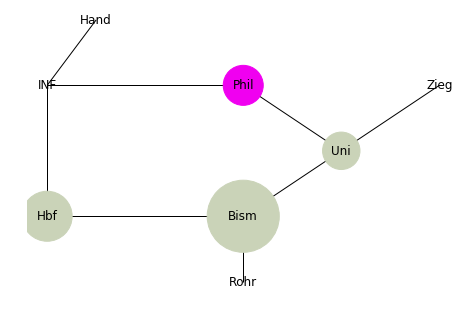

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 201. Mal
Länge der Queue: 25 aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:ex

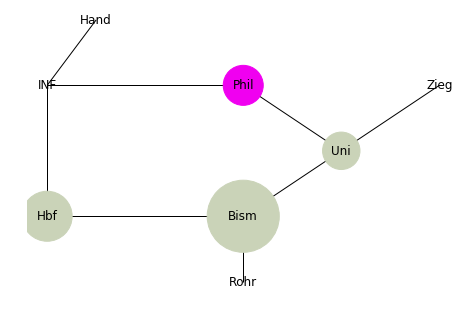

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 202. Mal
Länge der Queue: 24 aktion:exit, time:58.True, bm:zykel1.True; aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:73.True, bm:zykel1.True; aktion:exi

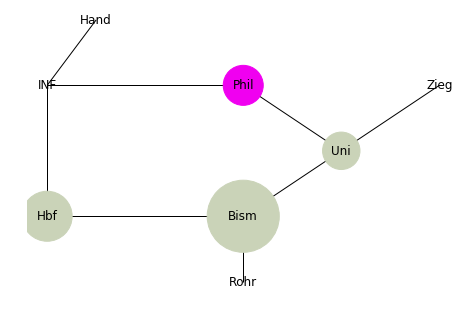

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 203. Mal
Länge der Queue: 23 aktion:exit, time:58.True, bm:zykel1.True; aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exi

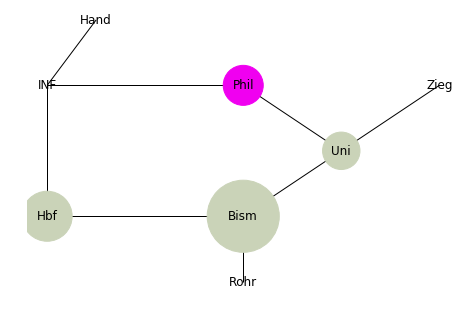

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 58
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 204. Mal
Länge der Queue: 22 aktion:load, time:60.True, bm:zubinger0.True; aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exi

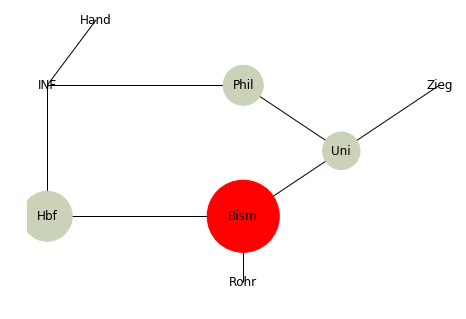

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
52
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 205. Mal
Länge der Queue: 22 aktion:load, time:60.True, bm:zubinger1.True; aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zyke

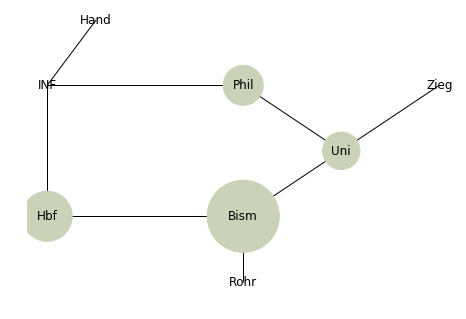

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 206. Mal
Länge der Queue: 22 aktion:load, time:60.True, bm:zubinger2.True; aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.Fal

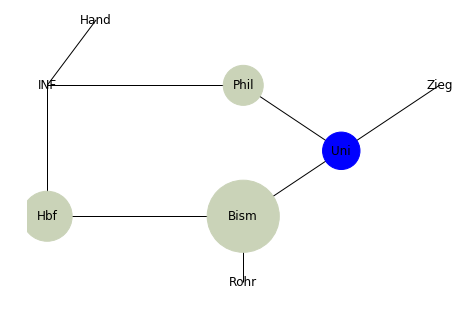

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
14
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5], [3, 7]]
Es warten noch 14 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 207. Mal
Länge der Queue: 22 aktion:load, time:60.True, bm:zykel0.True; aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, 

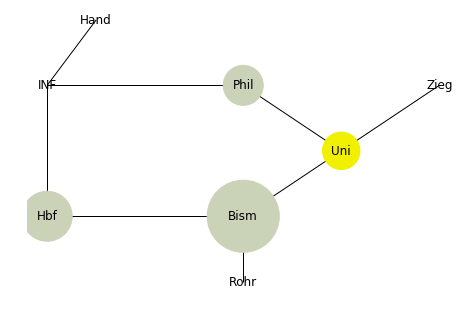

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 5 Plätze frei
14
ExitTime: 98, ListExit: [10, 10, 10, 10]
ExitTime: 68, ListExit: [10]
ExitTime: 88, ListExit: [10, 10, 10]
ExitTime: 88, ListExit: [10, 10, 10]
ExitTime: 78, ListExit: [10, 10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 9 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 208. Mal
Länge der Queue: 27 aktion:load, time:60.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True;

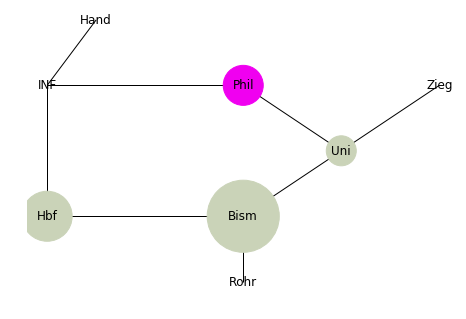

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 8 Plätze frei
16
ExitTime: 73, ListExit: [5, 5, 5]
ExitTime: 73, ListExit: [5, 5, 5]
ExitTime: 63, ListExit: [5]
ExitTime: 78, ListExit: [5, 5, 5, 5]
ExitTime: 63, ListExit: [5]
ExitTime: 63, ListExit: [5]
ExitTime: 78, ListExit: [5, 5, 5, 5]
ExitTime: 73, ListExit: [5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 8 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 209. Mal
Länge der Queue: 35 aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:ex

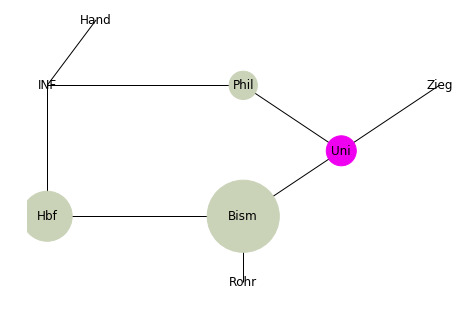

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 63
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 210. Mal
Länge der Queue: 34 aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:ex

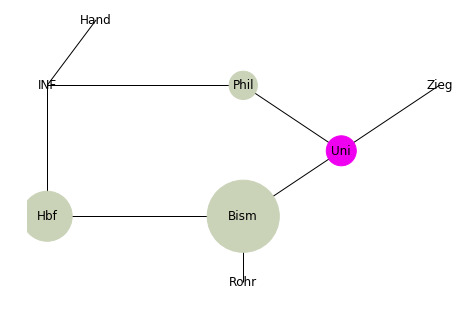

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 63
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 211. Mal
Länge der Queue: 33 aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:ex

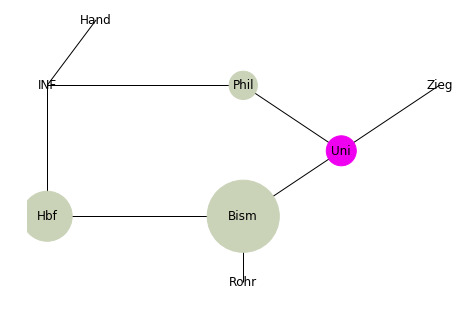

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 63
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 212. Mal
Länge der Queue: 32 aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:ex

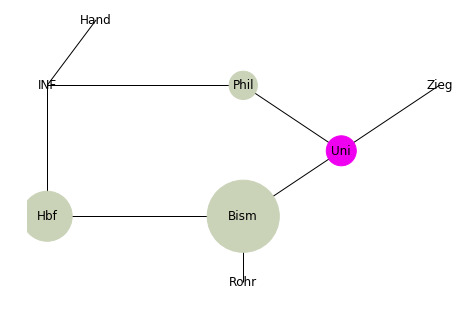

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 63
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 213. Mal
Länge der Queue: 31 aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:ex

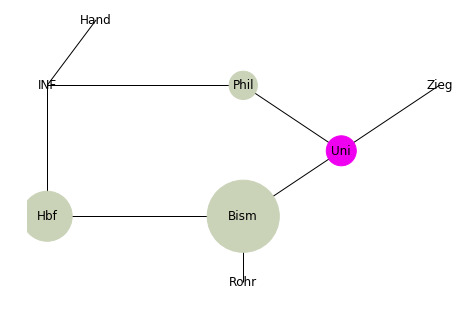

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 63
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 214. Mal
Länge der Queue: 30 aktion:exit, time:63.True, bm:zykel1.True; aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:ex

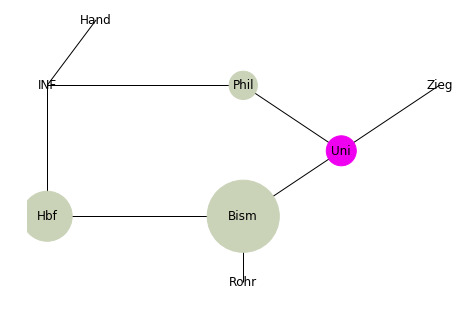

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 63
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 215. Mal
Länge der Queue: 29 aktion:exit, time:63.True, bm:zykel1.True; aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exi

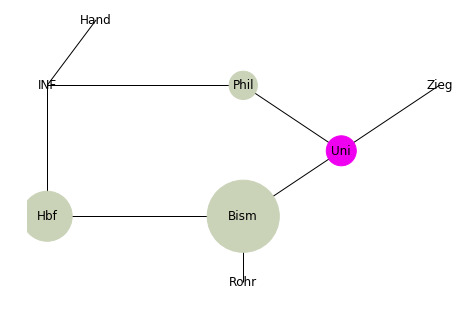

PassagierStation:3, PassagierTime:63, steigt aus, EventTime 63
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 216. Mal
Länge der Queue: 28 aktion:load, time:65.True, bm:zubinger0.True; aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exi

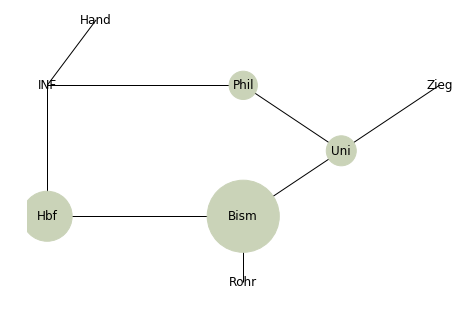

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 217. Mal
Länge der Queue: 28 aktion:load, time:65.True, bm:zubinger1.True; aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.Fa

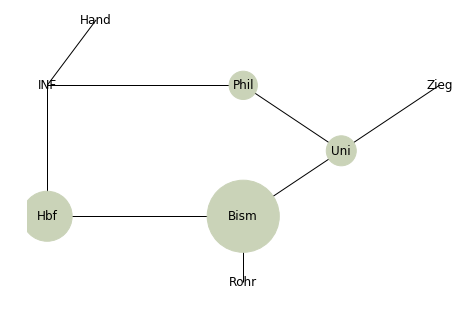

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 218. Mal
Länge der Queue: 28 aktion:load, time:65.True, bm:zubinger2.True; aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.Fa

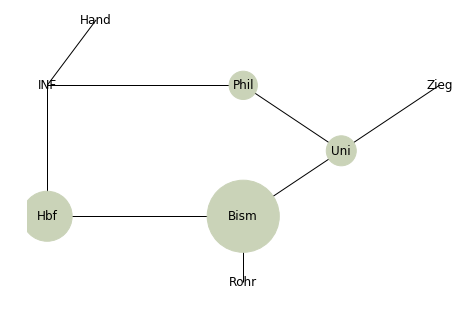

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 219. Mal
Länge der Queue: 28 aktion:load, time:65.True, bm:zykel1.True; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.True, bm:zykel0.True; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.Fa

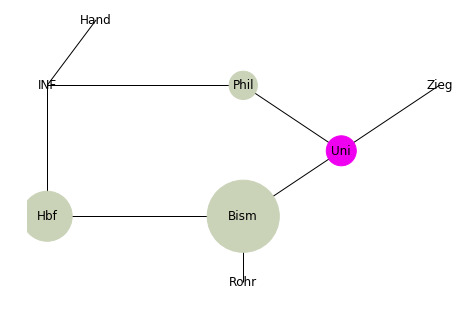

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 7 Plätze frei
9
ExitTime: 83, ListExit: [5, 5, 5, 5]
ExitTime: 73, ListExit: [5, 5]
ExitTime: 83, ListExit: [5, 5, 5, 5]
ExitTime: 83, ListExit: [5, 5, 5, 5]
ExitTime: 73, ListExit: [5, 5]
ExitTime: 78, ListExit: [5, 5, 5]
ExitTime: 78, ListExit: [5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 2 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 220. Mal
Länge der Queue: 35 aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73

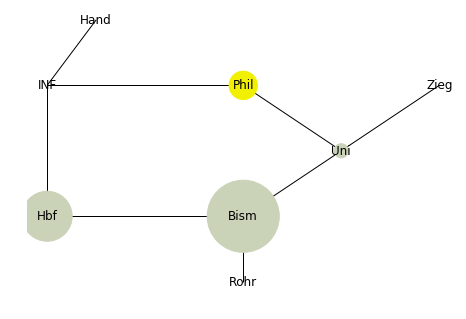

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 68
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [73, 73, 73, 73, 73, 73, 73, 73, 78, 78, 78, 78, 83, 83, 83]
Event BM: zykel0 CList: [68, 68, 68, 68, 68, 78, 78, 78, 78, 78, 78, 98, 88, 88]
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 221. Mal
Länge der Queue: 34 aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit

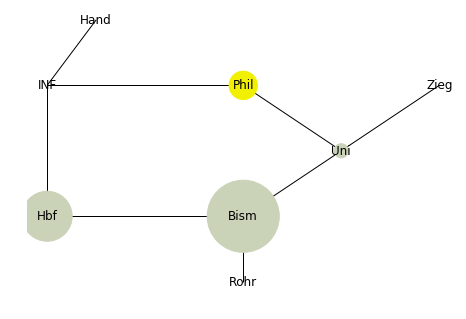

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 68
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [73, 73, 73, 73, 73, 73, 73, 73, 78, 78, 78, 78, 83, 83, 83]
Event BM: zykel0 CList: [68, 68, 78, 68, 68, 78, 88, 78, 78, 78, 78, 98, 88]
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 222. Mal
Länge der Queue: 33 aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time

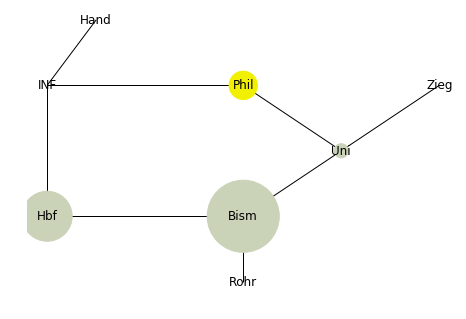

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 68
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [73, 73, 73, 73, 73, 73, 73, 73, 78, 78, 78, 78, 83, 83, 83]
Event BM: zykel0 CList: [68, 68, 78, 68, 78, 78, 88, 78, 78, 78, 88, 98]
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 223. Mal
Länge der Queue: 32 aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.Tr

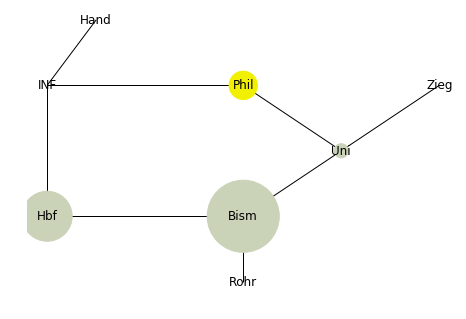

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 68
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [73, 73, 73, 73, 73, 73, 73, 73, 78, 78, 78, 78, 83, 83, 83]
Event BM: zykel0 CList: [68, 68, 78, 78, 78, 78, 88, 78, 98, 78, 88]
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 224. Mal
Länge der Queue: 31 aktion:exit, time:68.False, bm:zykel0.False; aktion:exit, time:68.False, bm:zykel0.False; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm

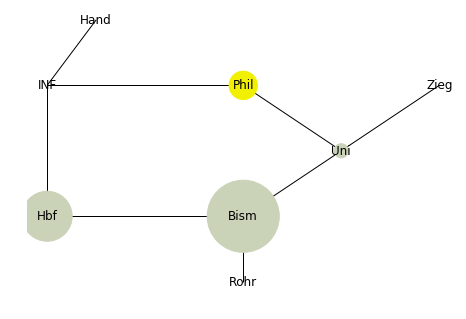

PassagierStation:2, PassagierTime:58, steigt aus, EventTime 68
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [73, 73, 73, 73, 73, 73, 73, 73, 78, 78, 78, 78, 83, 83, 83]
Event BM: zykel0 CList: [68, 78, 78, 78, 78, 78, 88, 78, 98, 88]
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 225. Mal
Länge der Queue: 30 aktion:exit, time:68.False, bm:zykel0.False; aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel

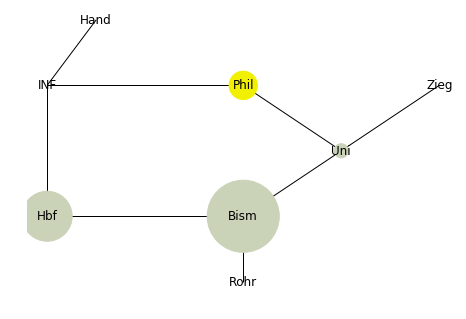

PassagierStation:2, PassagierTime:83, steigt aus, EventTime 68
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [73, 73, 73, 73, 73, 73, 73, 73, 78, 78, 78, 78, 83, 83, 83]
Event BM: zykel0 CList: [78, 78, 78, 78, 78, 88, 88, 78, 98]
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 226. Mal
Länge der Queue: 29 aktion:load, time:70.True, bm:zubinger0.True; aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.Fals

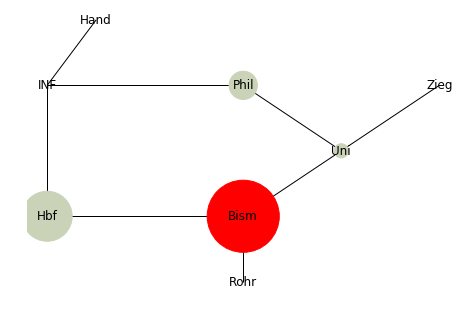

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
52
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 227. Mal
Länge der Queue: 29 aktion:load, time:70.True, bm:zubinger1.True; aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:load, time:75.True, bm:zubinger0.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.

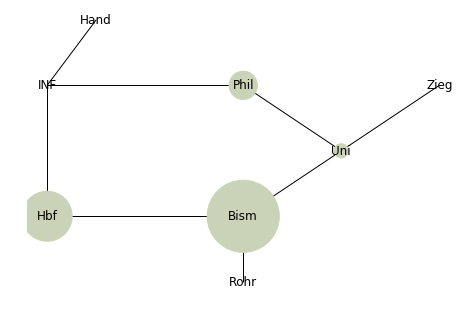

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 228. Mal
Länge der Queue: 29 aktion:load, time:70.True, bm:zubinger2.True; aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False

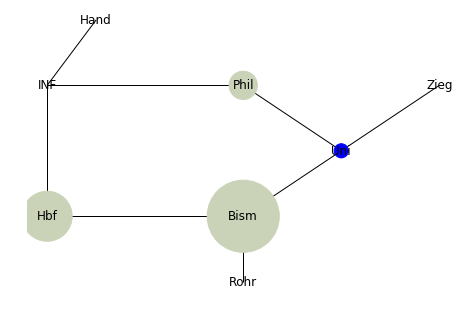

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
2
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[3, 7]]
Es warten noch 2 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 229. Mal
Länge der Queue: 29 aktion:load, time:70.True, bm:zykel0.True; aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.Fal

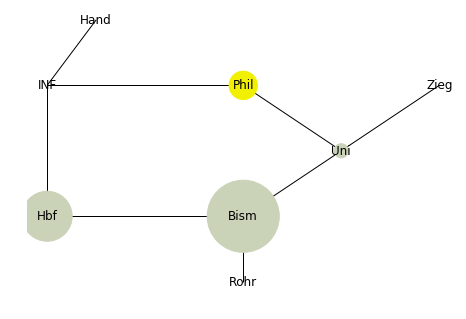

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 6 Plätze frei
8
ExitTime: 108, ListExit: [10, 10, 10, 10]
ExitTime: 108, ListExit: [10, 10, 10, 10]
ExitTime: 108, ListExit: [10, 10, 10, 10]
ExitTime: 88, ListExit: [10, 10]
ExitTime: 88, ListExit: [10, 10]
ExitTime: 88, ListExit: [10, 10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 2 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 230. Mal
Länge der Queue: 35 aktion:load, time:70.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:exit, time:78.False, bm:zykel0.Fal

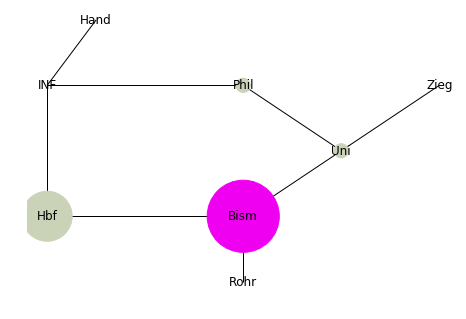

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 0 Plätze frei
52
Berechne, wer zukünftig umsteigen soll
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 231. Mal
Länge der Queue: 35 aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.Fa

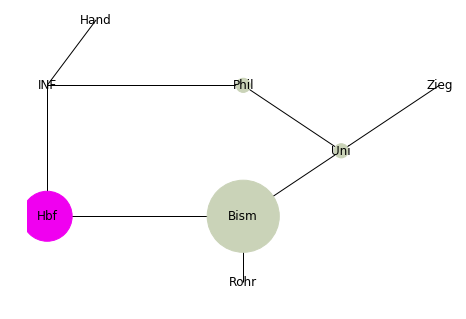

PassagierStation:0, PassagierTime:73, steigt aus, EventTime 73
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 232. Mal
Länge der Queue: 34 aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; ak

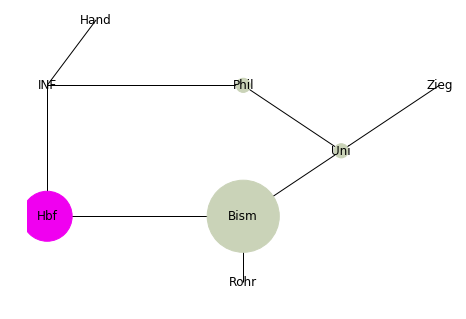

PassagierStation:0, PassagierTime:73, steigt aus, EventTime 73
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 233. Mal
Länge der Queue: 33 aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; ak

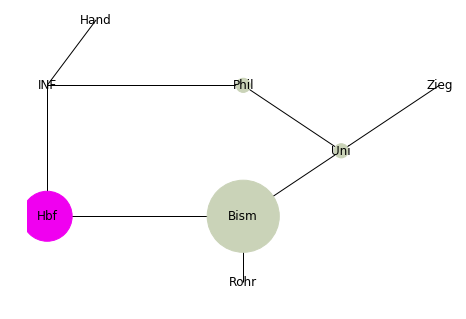

PassagierStation:0, PassagierTime:73, steigt aus, EventTime 73
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 234. Mal
Länge der Queue: 32 aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; ak

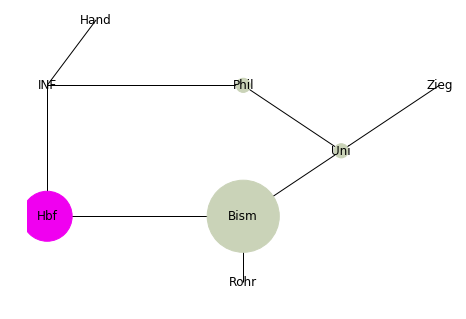

PassagierStation:0, PassagierTime:73, steigt aus, EventTime 73
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 235. Mal
Länge der Queue: 31 aktion:exit, time:73.True, bm:zykel1.True; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; ak

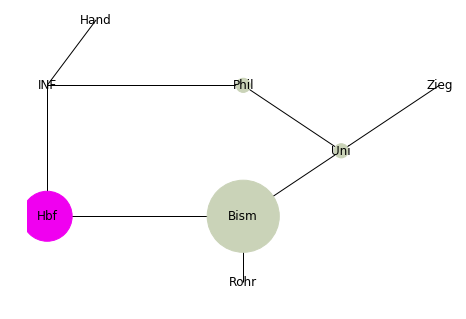

PassagierStation:0, PassagierTime:73, steigt aus, EventTime 73
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 236. Mal
Länge der Queue: 30 aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; ak

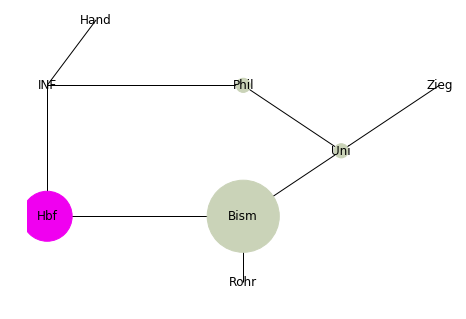

PassagierStation:0, PassagierTime:88, steigt aus, EventTime 73
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [78, 78, 78, 78, 78, 78, 88, 88, 88, 88, 88, 98, 108, 108, 108]
Event BM: zykel1 CList: [73, 73, 78, 78, 78, 83, 83, 83, 78]
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 237. Mal
Länge der Queue: 29 aktion:exit, time:73.False, bm:zykel1.False; aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.Tru

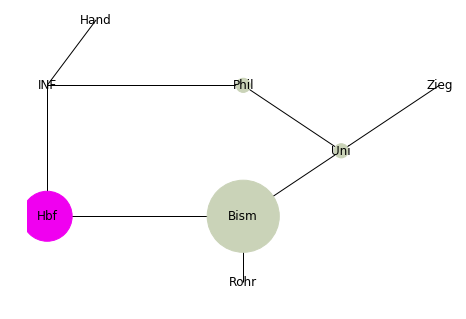

PassagierStation:0, PassagierTime:88, steigt aus, EventTime 73
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [78, 78, 78, 78, 78, 78, 88, 88, 88, 88, 88, 98, 108, 108, 108]
Event BM: zykel1 CList: [73, 78, 78, 78, 78, 83, 83, 83]
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 238. Mal
Länge der Queue: 28 aktion:exit, time:73.False, bm:zykel1.False; aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:

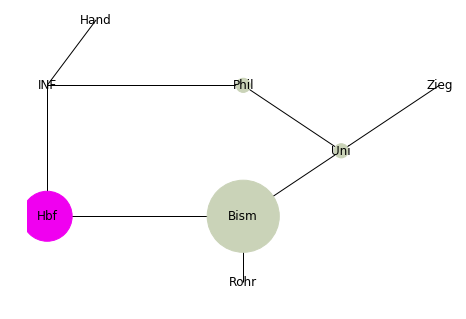

PassagierStation:0, PassagierTime:88, steigt aus, EventTime 73
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [78, 78, 78, 78, 78, 78, 88, 88, 88, 88, 88, 98, 108, 108, 108]
Event BM: zykel1 CList: [78, 78, 83, 78, 78, 83, 83]
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 239. Mal
Länge der Queue: 27 aktion:load, time:75.True, bm:zubinger0.True; aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1

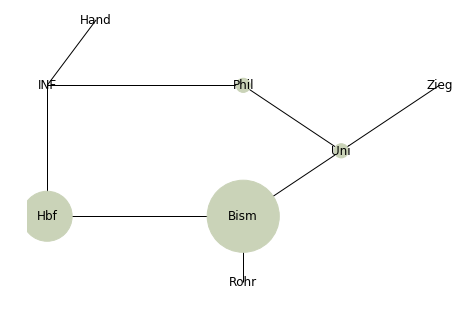

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 240. Mal
Länge der Queue: 27 aktion:load, time:75.True, bm:zubinger1.True; aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zykel0.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.Tr

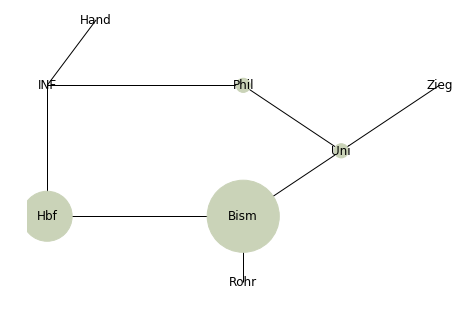

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 241. Mal
Länge der Queue: 27 aktion:load, time:75.True, bm:zubinger2.True; aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zykel0.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.Tr

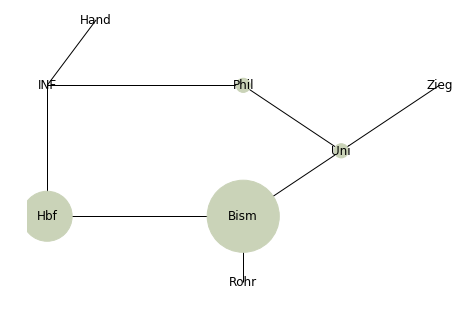

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 242. Mal
Länge der Queue: 27 aktion:load, time:75.True, bm:zykel1.True; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.False, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.Tr

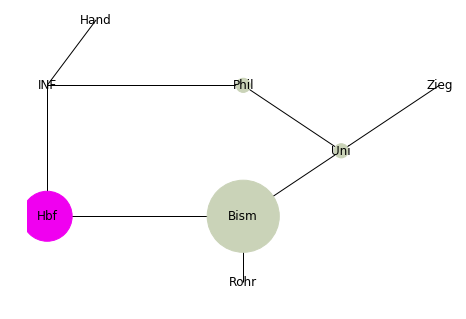

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 8 Plätze frei
25
ExitTime: 78, ListExit: [5]
ExitTime: 78, ListExit: [5]
ExitTime: 78, ListExit: [5]
ExitTime: 88, ListExit: [5, 5, 5]
ExitTime: 78, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[1, 6]]
path  [1]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger1']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
dummy
[1]
Temp:  [[1, 6]]
exit_node  1
ExitTime: 79, ListExit: [5]
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
dummy
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 94, ListExit: [5, 5, 5, 5]
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zykel1
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 94, ListExit: [5, 5, 5, 5]
Es warten noch 17 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 243. Mal
Länge der Queue: 35 aktion:exit, time:78.T

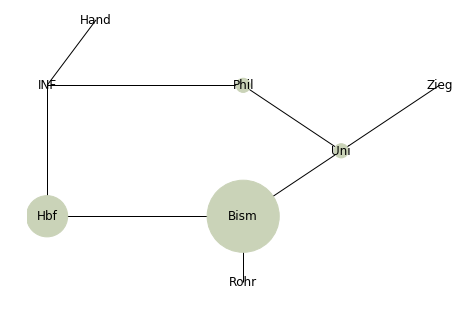

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 244. Mal
Länge der Queue: 34 aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, t

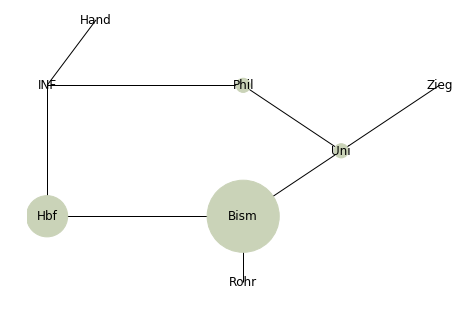

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 245. Mal
Länge der Queue: 33 aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, ti

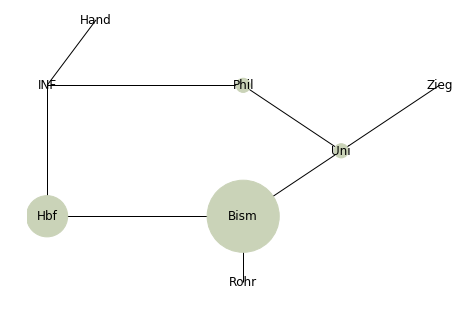

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 246. Mal
Länge der Queue: 32 aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, tim

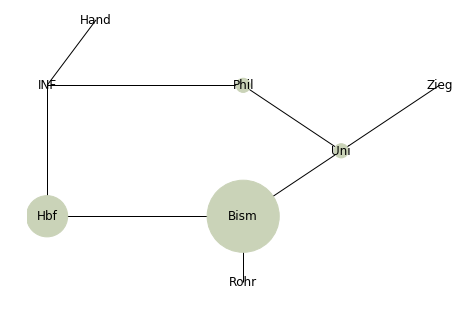

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 247. Mal
Länge der Queue: 31 aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time

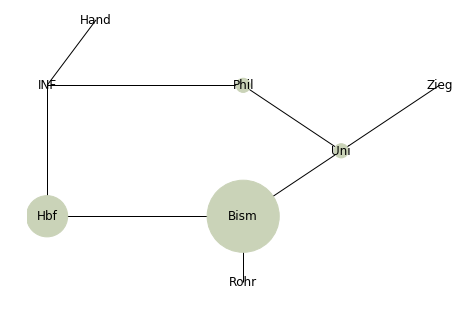

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 248. Mal
Länge der Queue: 30 aktion:exit, time:78.True, bm:zykel0.False; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:

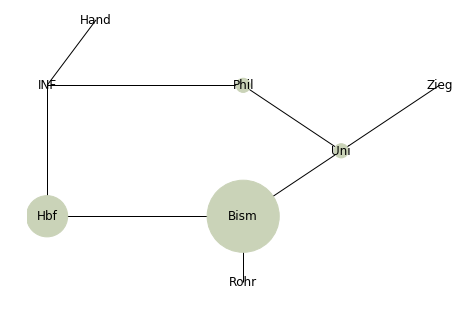

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 249. Mal
Länge der Queue: 29 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88

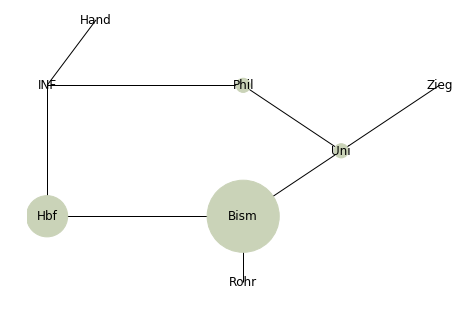

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 250. Mal
Länge der Queue: 28 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time

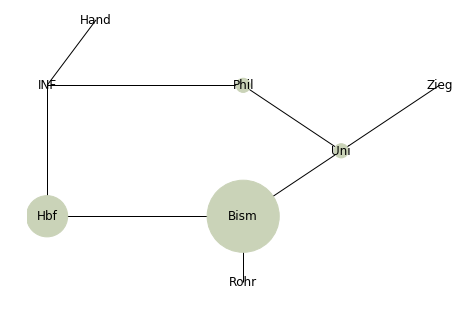

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 251. Mal
Länge der Queue: 27 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, ti

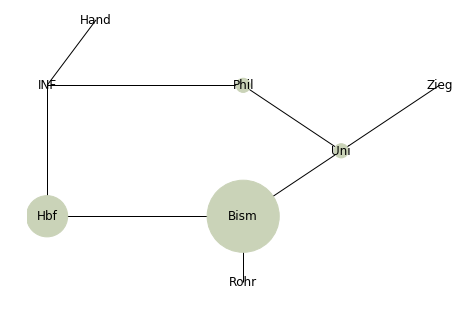

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 252. Mal
Länge der Queue: 26 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, ti

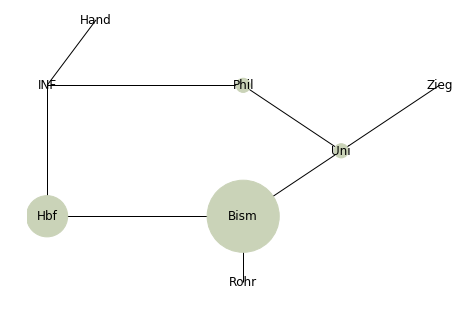

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 253. Mal
Länge der Queue: 25 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, ti

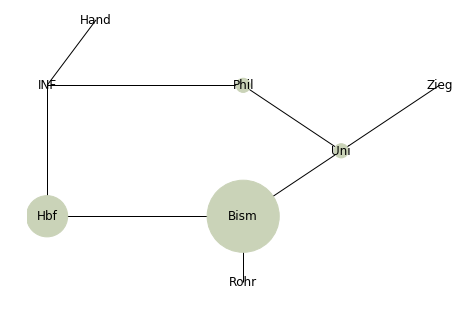

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 254. Mal
Länge der Queue: 24 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, ti

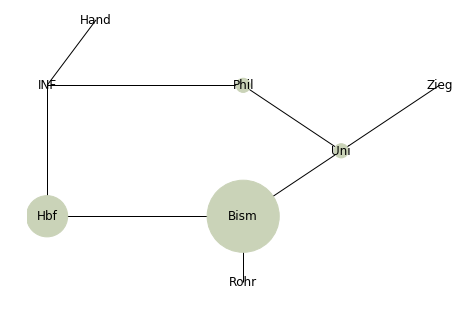

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 255. Mal
Länge der Queue: 23 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:exit, tim

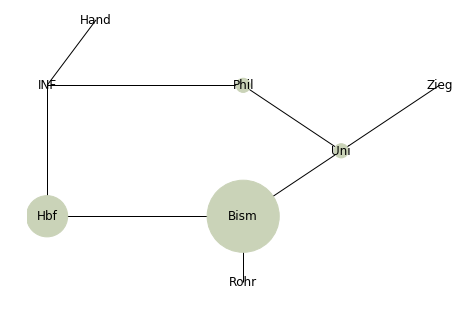

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 256. Mal
Länge der Queue: 22 aktion:exit, time:78.True, bm:zykel1.True; aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, tim

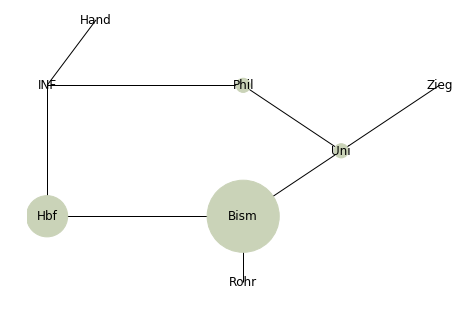

PassagierStation:1, PassagierTime:78, steigt aus, EventTime 78
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 257. Mal
Länge der Queue: 21 aktion:exit, time:79.True, bm:zykel1.True; aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, tim

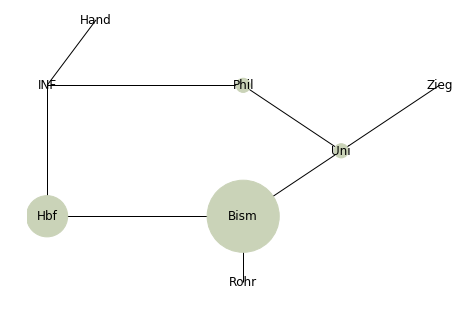

PassagierStation:6, PassagierTime:79, steigt aus, EventTime 79
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 6 steigt um.
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 258. Mal
Länge der Queue: 20 aktion:load, time:80.True, bm:zubinger0.True; aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True,

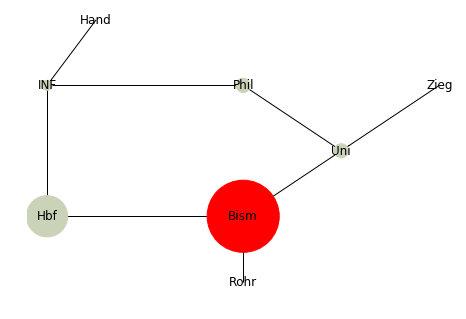

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
52
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 259. Mal
Länge der Queue: 20 aktion:load, time:80.True, bm:zubinger1.True; aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.Tru

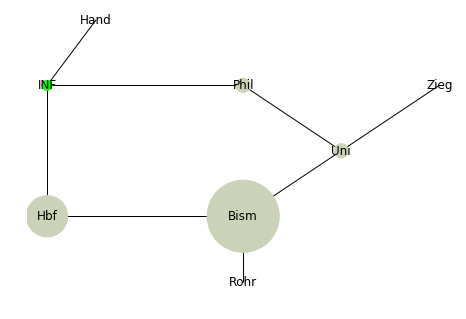

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
1
ExitTime: 83, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 260. Mal
Länge der Queue: 21 aktion:load, time:80.True, bm:zubinger2.True; aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zubinger1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, tim

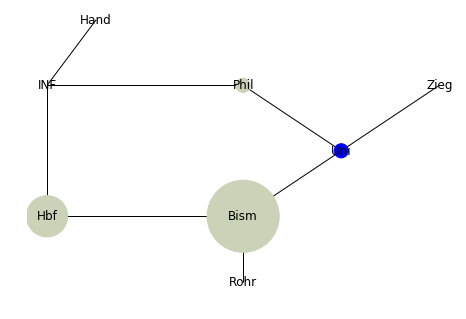

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
2
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[3, 7]]
Es warten noch 2 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 261. Mal
Länge der Queue: 21 aktion:load, time:80.True, bm:zykel0.True; aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zubinger1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.Tru

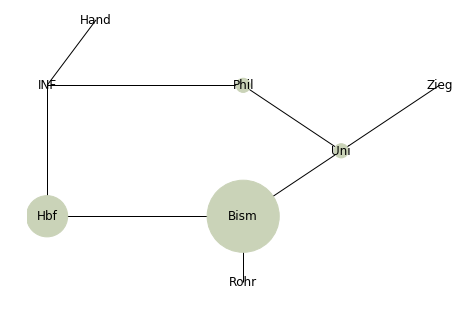

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 6 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 262. Mal
Länge der Queue: 21 aktion:load, time:80.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zubinger1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:e

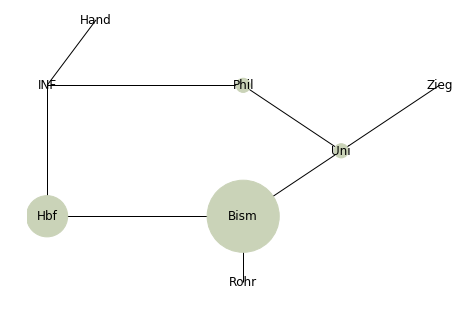

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 9 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 263. Mal
Länge der Queue: 21 aktion:exit, time:83.True, bm:zubinger1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:e

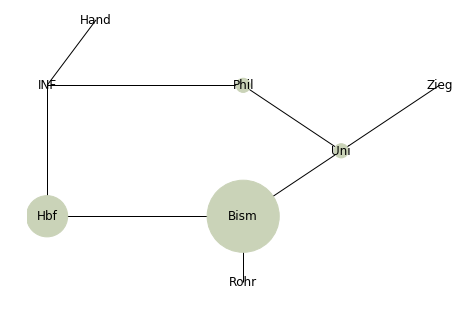

PassagierStation:6, PassagierTime:83, steigt aus, EventTime 83
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 264. Mal
Länge der Queue: 20 aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, tim

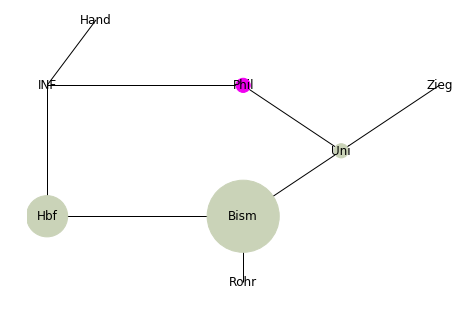

PassagierStation:2, PassagierTime:83, steigt aus, EventTime 83
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 265. Mal
Länge der Queue: 19 aktion:exit, time:83.True, bm:zykel1.True; aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, ti

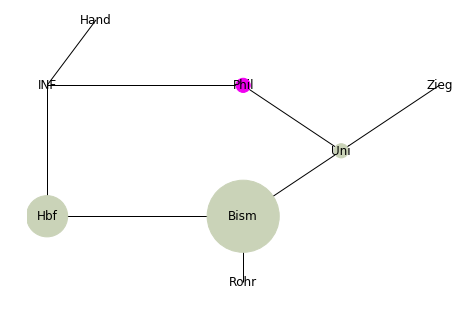

PassagierStation:2, PassagierTime:83, steigt aus, EventTime 83
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 266. Mal
Länge der Queue: 18 aktion:exit, time:83.True, bm:zykel1.True; aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, t

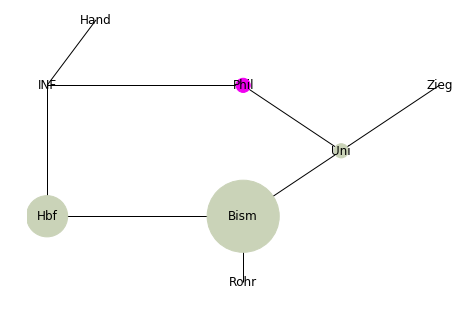

PassagierStation:2, PassagierTime:83, steigt aus, EventTime 83
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 267. Mal
Länge der Queue: 17 aktion:load, time:85.True, bm:zubinger0.True; aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zub

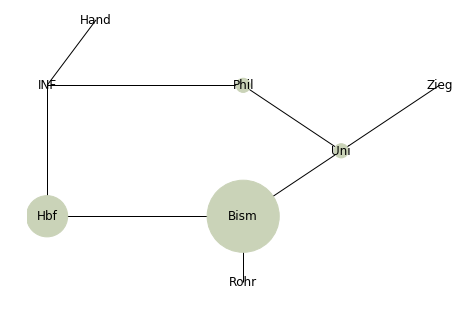

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 268. Mal
Länge der Queue: 17 aktion:load, time:85.True, bm:zubinger1.True; aktion:load, time:85.True, bm:zubinger2.True; aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zubinger1 ist am Knoten Hand, der

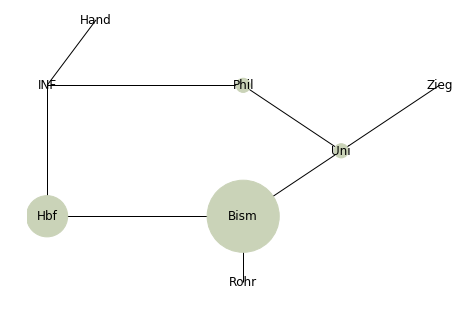

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 269. Mal
Länge der Queue: 17 aktion:load, time:85.True, bm:zubinger2.True; aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der

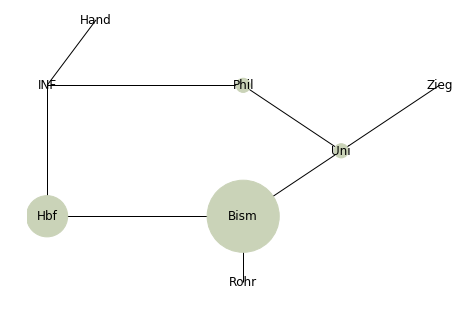

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 270. Mal
Länge der Queue: 17 aktion:load, time:85.True, bm:zykel1.True; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel0.True; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Phil, der nä

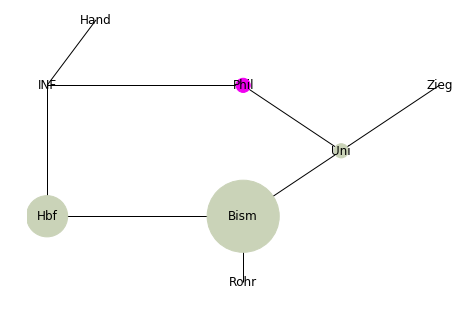

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 12 Plätze frei
2
ExitTime: 98, ListExit: [5, 5, 5]
ExitTime: 103, ListExit: [5, 5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 271. Mal
Länge der Queue: 19 aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, tim

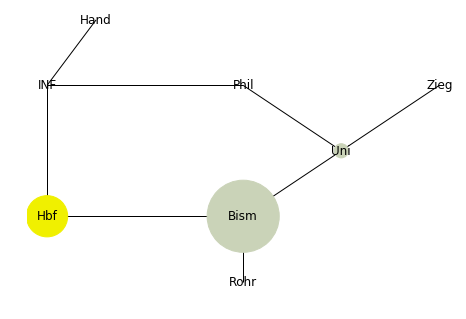

PassagierStation:0, PassagierTime:73, steigt aus, EventTime 88
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [88, 94, 94, 98, 103]
Event BM: zykel0 CList: [88, 88, 98, 88, 108, 108, 108, 88]
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 272. Mal
Länge der Queue: 18 aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:

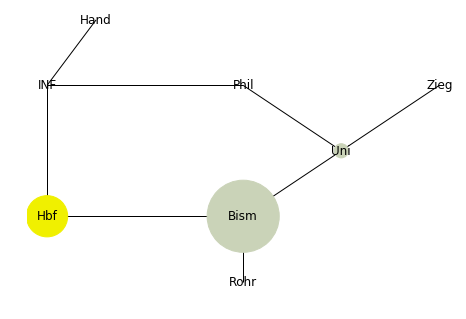

PassagierStation:0, PassagierTime:73, steigt aus, EventTime 88
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [88, 94, 94, 98, 103]
Event BM: zykel0 CList: [88, 88, 98, 88, 108, 108, 108]
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 273. Mal
Länge der Queue: 17 aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel

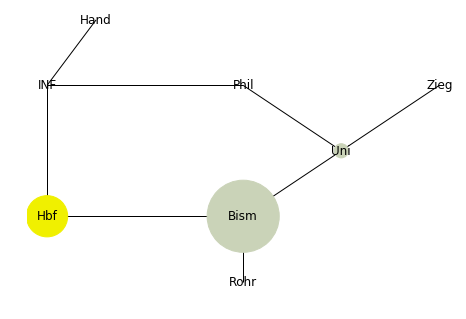

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 88
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [88, 94, 94, 98, 103]
Event BM: zykel0 CList: [88, 88, 98, 108, 108, 108]
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 274. Mal
Länge der Queue: 16 aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.Tru

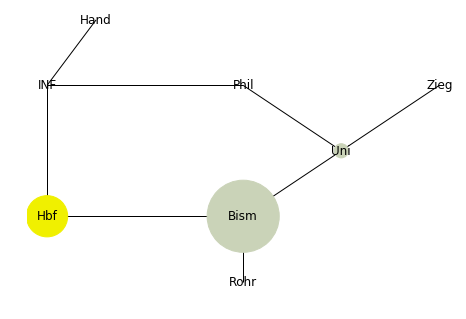

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 88
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [88, 94, 94, 98, 103]
Event BM: zykel0 CList: [88, 108, 98, 108, 108]
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 275. Mal
Länge der Queue: 15 aktion:exit, time:88.False, bm:zykel0.False; aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
F

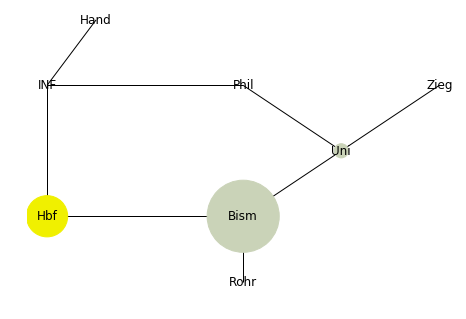

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 88
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [88, 94, 94, 98, 103]
Event BM: zykel0 CList: [98, 108, 108, 108]
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 276. Mal
Länge der Queue: 14 aktion:exit, time:88.True, bm:zykel1.True; aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Hal

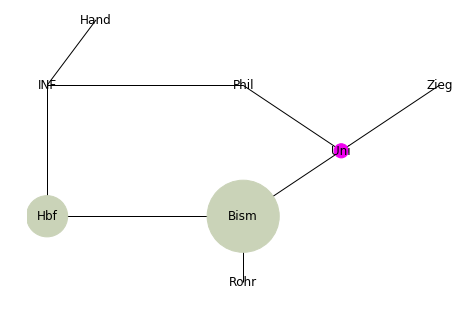

PassagierStation:3, PassagierTime:88, steigt aus, EventTime 88
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 277. Mal
Länge der Queue: 13 aktion:load, time:90.True, bm:zubinger0.True; aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zubinger0 ist am Knoten Bism, der nächste Halt Rohr, die aktuelle Zeit: 90
und zubinger0 Stopp zum 18. Mal, Runden: 9, Rest: 0
Graph gespeichert als file00090.png, wird in imglis

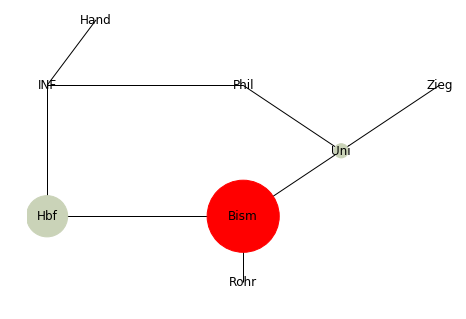

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
52
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[4, 5]]
Es warten noch 52 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 278. Mal
Länge der Queue: 13 aktion:load, time:90.True, bm:zubinger1.True; aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:load, time:95.True, bm:zubinger0.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zubinger1 ist am Knoten INF, der nächste Halt Hand, die aktuelle Zeit: 90
und zubinger1 Stopp zum 18. Mal, Runden: 9, Rest: 0
Graph gespeichert als file00090.p

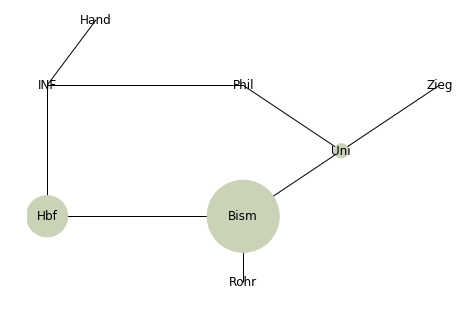

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 279. Mal
Länge der Queue: 13 aktion:load, time:90.True, bm:zubinger2.True; aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:load, time:95.True, bm:zubinger0.True; aktion:load, time:95.True, bm:zubinger1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Uni, der nächste Halt Zieg, die aktuelle Zeit: 90
und zubinger2 Stopp zum 18. Mal, Runden: 9, Rest: 0
Graph gespeichert als file00090.png, wird in imglist hinzugefügt


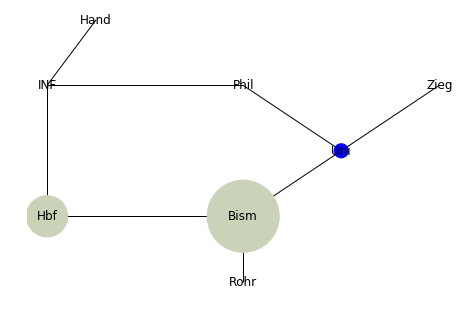

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
2
Berechne, wer zukünftig umsteigen soll
Protect:  ['zykel0', 'zykel1']
Temp:  [[3, 7]]
Es warten noch 2 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 280. Mal
Länge der Queue: 13 aktion:load, time:90.True, bm:zykel0.True; aktion:load, time:90.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:exit, time:94.True, bm:zykel1.True; aktion:load, time:95.True, bm:zubinger0.True; aktion:load, time:95.True, bm:zubinger1.True; aktion:load, time:95.True, bm:zubinger2.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; 
Fahrzeug zykel0 ist am Knoten Hbf, der nächste Halt Bism, die aktuelle Zeit: 90
und zykel0 Stopp zum 9. Mal, Runden: 1, Rest: 4
Graph gespeichert als file00090.png, wird i

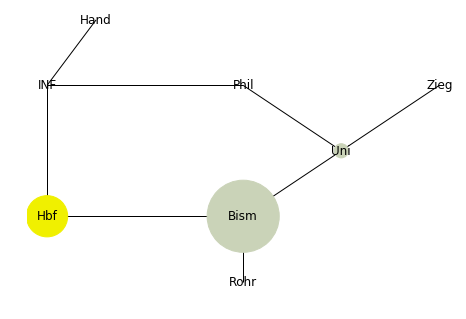

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 11 Plätze frei
17
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zykel1
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 99, ListExit: [10]
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zykel0
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 99, ListExit: [10]
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zykel0
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 99, ListExit: [10]
Protect:  []
Temp:  [[1, 6]]
path  [1]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger1']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zubinger1
[1]
Temp:  [[1, 6]]
exit_node  1
ExitTime: 129, ListExit: [10, 10, 10, 10]
Protect:  []
Temp:  [[1, 6]]
path  [1]
path1 [0]
PATH0  [['zykel0'

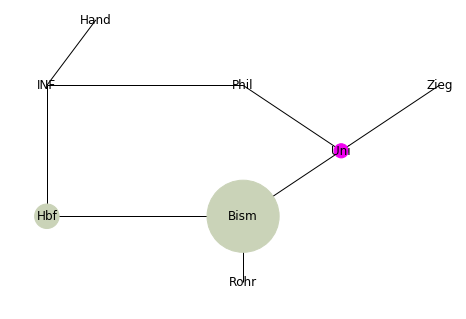

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 11 Plätze frei
2
ExitTime: 98, ListExit: [5, 5]
ExitTime: 108, ListExit: [5, 5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 282. Mal
Länge der Queue: 26 aktion:exit, time:94.False, bm:zykel1.False; aktion:exit, time:94.False, bm:zykel1.False; aktion:load, time:95.True, bm:zubinger0.True; aktion:load, time:95.True, bm:zubinger1.True; aktion:load, time:95.True, bm:zubinger2.True; aktion:load, time:95.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel0.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.Tru

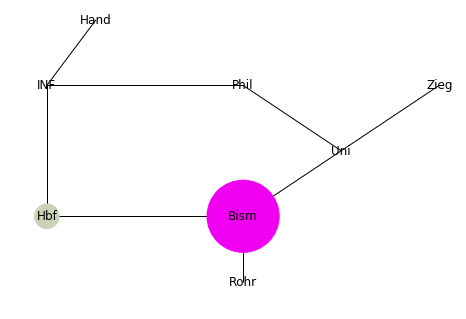

PassagierStation:5, PassagierTime:99, steigt aus, EventTime 94
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [98, 99, 99, 99, 99, 99, 108, 108, 108, 129, 129, 129, 129, 129, 129]
Event BM: zykel1 CList: [94, 98, 98, 108, 103]
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 5 steigt um.
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 283. Mal
Länge der Queue: 25 aktion:exit, time:94.False, bm:zykel1.False; aktion:load, time:95.True, bm:zubinger0.True; aktion:load, time:95.True, bm:zubinger1.True; aktion:load, time:95.True, bm:zubinger2.True; aktion:load, time:95.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load,

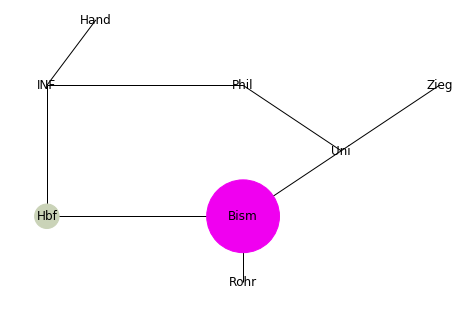

PassagierStation:5, PassagierTime:99, steigt aus, EventTime 94
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [98, 99, 99, 99, 99, 99, 108, 108, 108, 129, 129, 129, 129, 129, 129]
Event BM: zykel1 CList: [98, 98, 103, 108]
Passagier am richtigen Ort: [False, False]
zykel0 zykel1
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 284. Mal
Länge der Queue: 24 aktion:load, time:95.True, bm:zubinger0.True; aktion:load, time:95.True, bm:zubinger1.True; aktion:load, time:95.True, bm:zubinger2.True; aktion:load, time:95.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zy

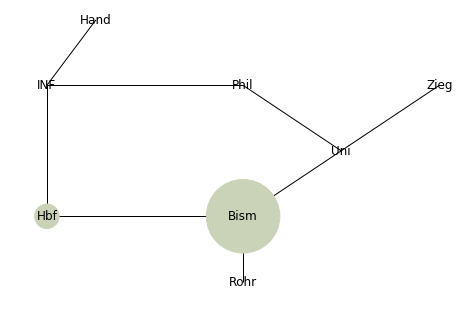

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 285. Mal
Länge der Queue: 24 aktion:load, time:95.True, bm:zubinger1.True; aktion:load, time:95.True, bm:zubinger2.True; aktion:load, time:95.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zykel0.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; 

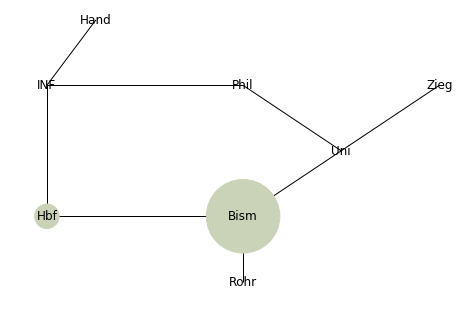

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 286. Mal
Länge der Queue: 24 aktion:load, time:95.True, bm:zubinger2.True; aktion:load, time:95.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zykel0.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True;

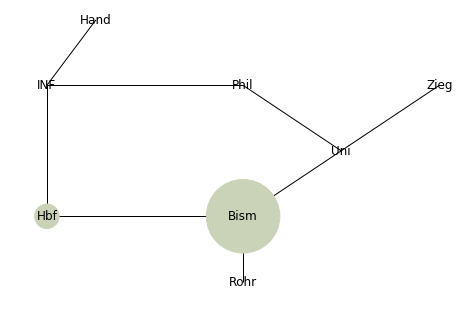

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 287. Mal
Länge der Queue: 24 aktion:load, time:95.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True

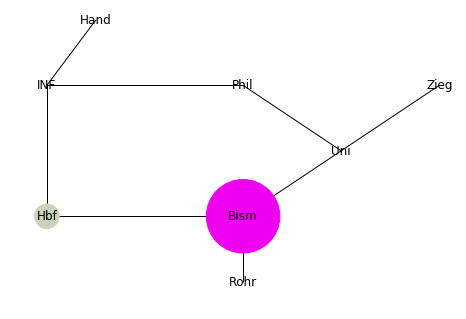

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 11 Plätze frei
54
ExitTime: 98, ListExit: [5]
ExitTime: 108, ListExit: [5, 5, 5]
ExitTime: 98, ListExit: [5]
ExitTime: 113, ListExit: [5, 5, 5, 5]
ExitTime: 98, ListExit: [5]
ExitTime: 98, ListExit: [5]
ExitTime: 113, ListExit: [5, 5, 5, 5]
ExitTime: 103, ListExit: [5, 5]
ExitTime: 98, ListExit: [5]
ExitTime: 98, ListExit: [5]
ExitTime: 108, ListExit: [5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 43 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 288. Mal
Länge der Queue: 35 aktion:exit, time:98.True, bm:zykel0.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:

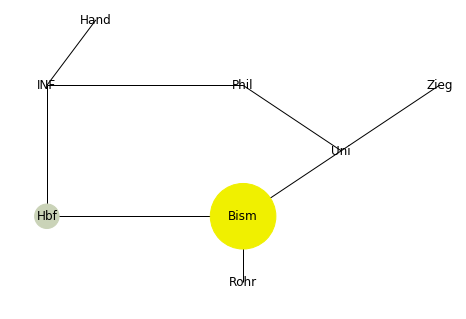

PassagierStation:4, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 289. Mal
Länge der Queue: 34 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, ti

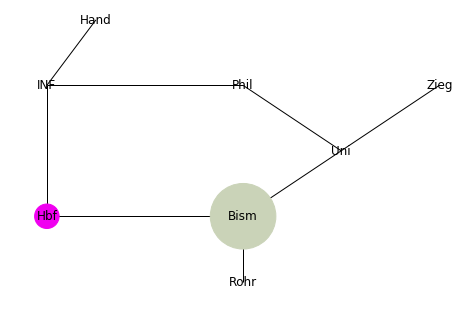

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 290. Mal
Länge der Queue: 33 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, t

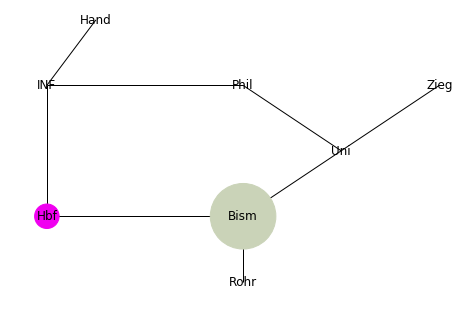

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 291. Mal
Länge der Queue: 32 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, 

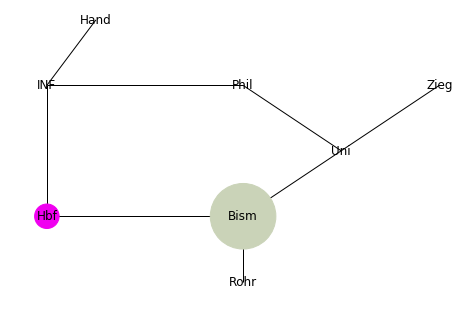

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 292. Mal
Länge der Queue: 31 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit,

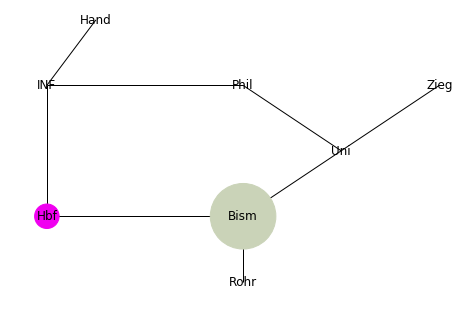

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 293. Mal
Länge der Queue: 30 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit

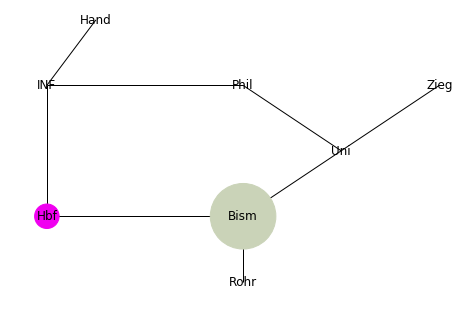

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 294. Mal
Länge der Queue: 29 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exi

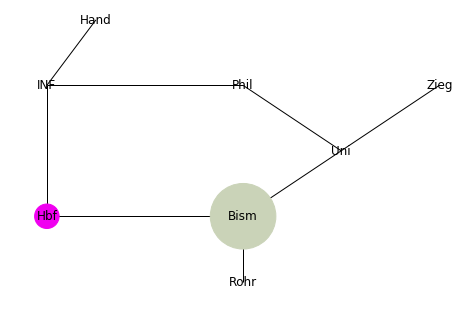

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 295. Mal
Länge der Queue: 28 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exi

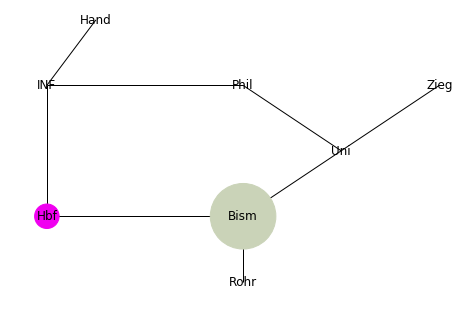

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 296. Mal
Länge der Queue: 27 aktion:exit, time:98.True, bm:zykel1.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:ex

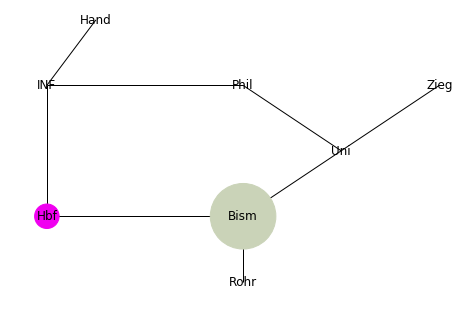

PassagierStation:0, PassagierTime:98, steigt aus, EventTime 98
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 297. Mal
Länge der Queue: 26 aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:e

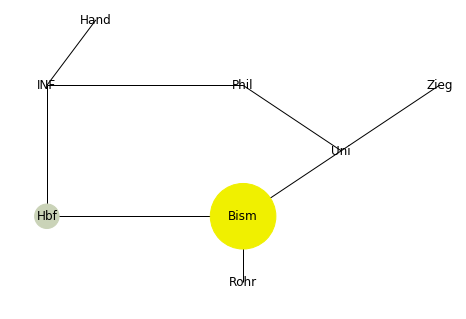

PassagierStation:5, PassagierTime:99, steigt aus, EventTime 99
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 298. Mal
Länge der Queue: 25 aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zy

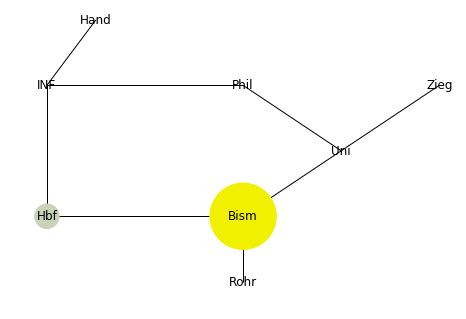

PassagierStation:5, PassagierTime:99, steigt aus, EventTime 99
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 299. Mal
Länge der Queue: 24 aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:z

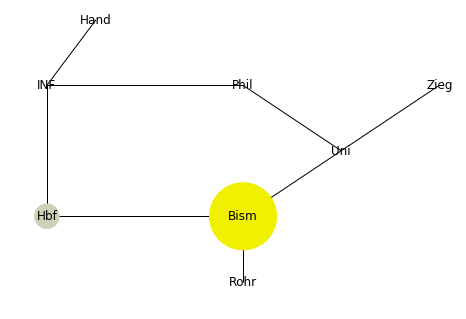

PassagierStation:5, PassagierTime:99, steigt aus, EventTime 99
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 300. Mal
Länge der Queue: 23 aktion:exit, time:99.True, bm:zykel0.True; aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:113.True, bm:

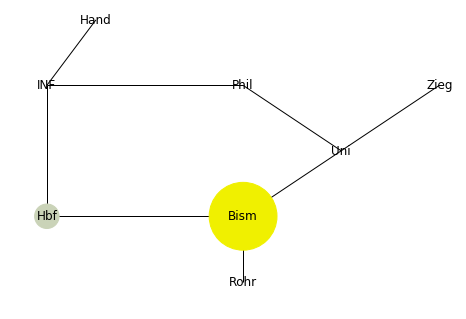

PassagierStation:5, PassagierTime:99, steigt aus, EventTime 99
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 301. Mal
Länge der Queue: 22 aktion:exit, time:99.True, bm:zykel0.True; aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:113.True, bm:zykel1.True; aktion:exit, time:113.True, bm

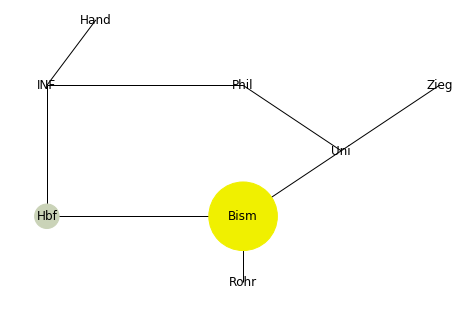

PassagierStation:5, PassagierTime:99, steigt aus, EventTime 99
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 302. Mal
Länge der Queue: 21 aktion:load, time:100.True, bm:zubinger0.True; aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:113.True, bm:zykel1.True; aktion:exit, time:113.True, bm:zykel1.True; aktion:exit, time:129.True, bm

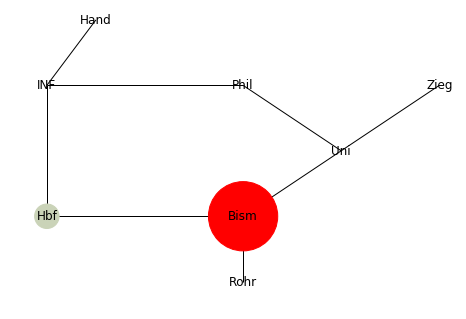

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
48
ExitTime: 103, ListExit: [5]
ExitTime: 103, ListExit: [5]
ExitTime: 103, ListExit: [5]
ExitTime: 103, ListExit: [5]
ExitTime: 103, ListExit: [5]
ExitTime: 103, ListExit: [5]
ExitTime: 103, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
dummy
Es warten noch 41 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 303. Mal
Länge der Queue: 28 aktion:load, time:100.True, bm:zubinger1.True; aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm

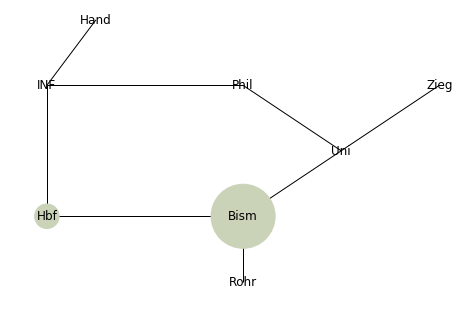

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 304. Mal
Länge der Queue: 28 aktion:load, time:100.True, bm:zubinger2.True; aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, 

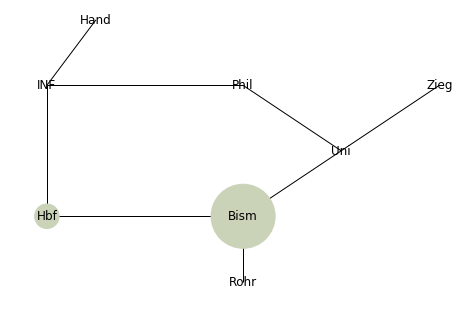

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 305. Mal
Länge der Queue: 28 aktion:load, time:100.True, bm:zykel0.True; aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, 

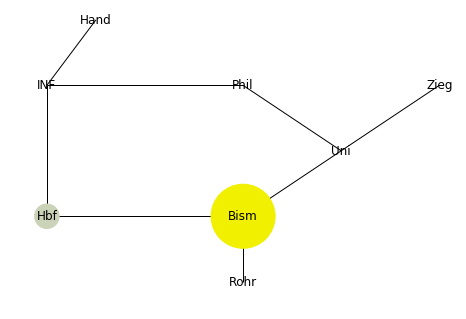

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 6 Plätze frei
41
ExitTime: 108, ListExit: [10]
ExitTime: 138, ListExit: [10, 10, 10, 10]
ExitTime: 108, ListExit: [10]
ExitTime: 138, ListExit: [10, 10, 10, 10]
ExitTime: 138, ListExit: [10, 10, 10, 10]
ExitTime: 118, ListExit: [10, 10]
Berechne, wer zukünftig umsteigen soll
Es warten noch 35 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 306. Mal
Länge der Queue: 34 aktion:load, time:100.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zubinger0.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:10

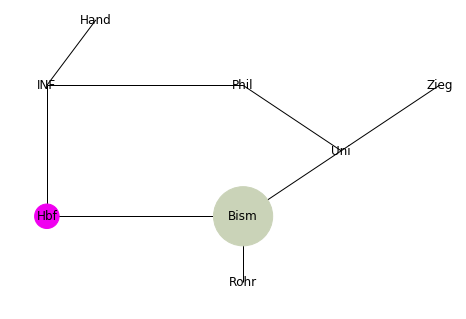

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 8 Plätze frei
6
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zubinger0
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 119, ListExit: [5, 5, 5, 5]
Protect:  []
Temp:  [[4, 5]]
path  [4]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger0']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zykel1
[4]
Temp:  [[4, 5]]
exit_node  4
ExitTime: 119, ListExit: [5, 5, 5, 5]
Protect:  []
Temp:  [[1, 6]]
path  [1]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger1']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zykel0
[1]
Temp:  [[1, 6]]
exit_node  1
ExitTime: 104, ListExit: [5]
Protect:  []
Temp:  [[1, 6]]
path  [1]
path1 [0]
PATH0  [['zykel0', 'zykel1', 'zubinger1']]
PATH1  [['zykel0', 'zykel1']]
[True]
[True]
zykel1
[1]
Temp:  [[1, 6]]
exit_node  1
ExitTime: 104, ListExit: [5]
Protect:  []
Temp:  [[1, 6]]
path  [1]
path1 [0]
PATH0  [['zyke

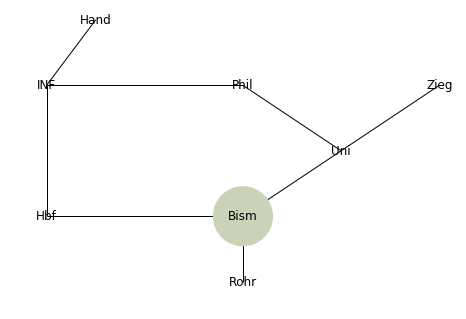

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 103
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [103, 103, 104, 104, 104, 108, 108, 108, 113, 113, 119, 119, 119]
Event BM: zubinger0 CList: [103, 103, 103, 103, 103, 103]
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 308. Mal
Länge der Queue: 39 aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True

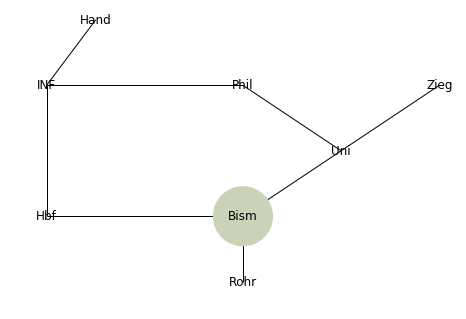

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 103
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [103, 103, 104, 104, 104, 108, 108, 108, 113, 113, 119, 119, 119]
Event BM: zubinger0 CList: [103, 103, 103, 103, 103]
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 309. Mal
Länge der Queue: 38 aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktio

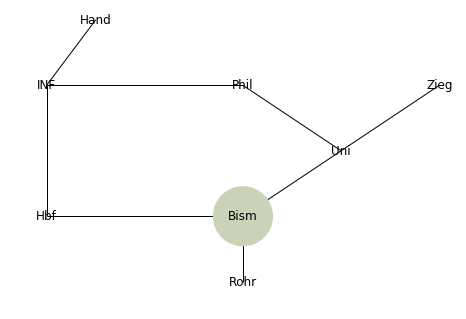

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 103
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [103, 103, 104, 104, 104, 108, 108, 108, 113, 113, 119, 119, 119]
Event BM: zubinger0 CList: [103, 103, 103, 103]
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 310. Mal
Länge der Queue: 37 aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, ti

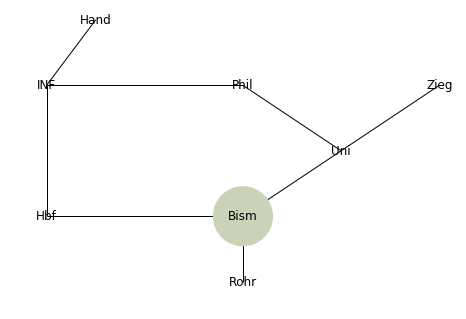

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 103
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [103, 103, 104, 104, 104, 108, 108, 108, 113, 113, 119, 119, 119]
Event BM: zubinger0 CList: [103, 103, 103]
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 311. Mal
Länge der Queue: 36 aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.Tru

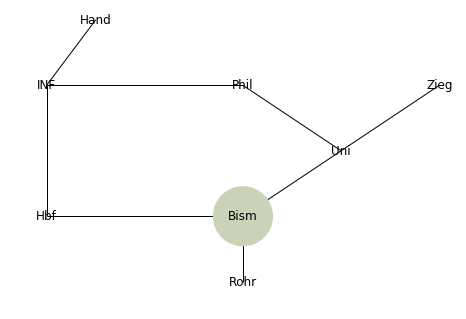

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 103
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [103, 103, 104, 104, 104, 108, 108, 108, 113, 113, 119, 119, 119]
Event BM: zubinger0 CList: [103, 103]
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 312. Mal
Länge der Queue: 35 aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zyke

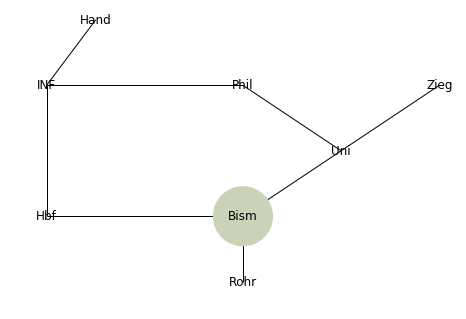

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 103
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [103, 103, 104, 104, 104, 108, 108, 108, 113, 113, 119, 119, 119]
Event BM: zubinger0 CList: [103]
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 313. Mal
Länge der Queue: 34 aktion:exit, time:103.False, bm:zubinger0.False; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; a

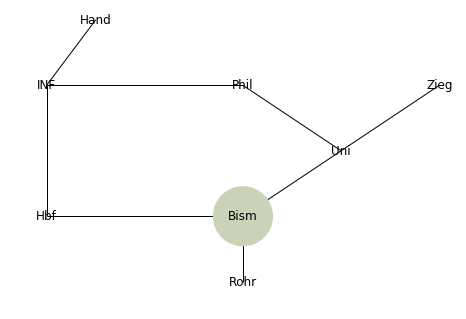

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 103
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [103, 103, 104, 104, 104, 108, 108, 108, 113, 113, 119, 119, 119]
Event BM: zubinger0 CList: []
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 314. Mal
Länge der Queue: 33 aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:ex

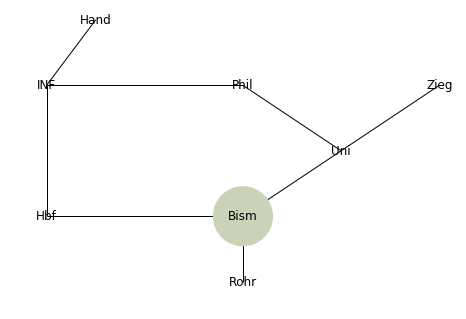

PassagierStation:1, PassagierTime:103, steigt aus, EventTime 103
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 315. Mal
Länge der Queue: 32 aktion:exit, time:103.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zykel0.Tr

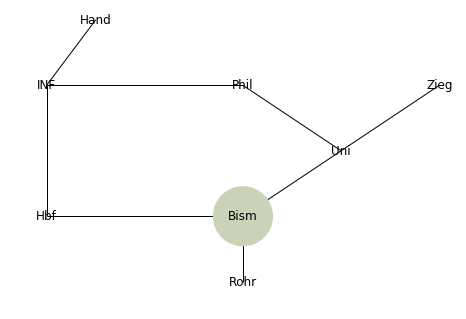

PassagierStation:1, PassagierTime:103, steigt aus, EventTime 103
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 316. Mal
Länge der Queue: 31 aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zykel0.True; aktion:exit, time:113.False, bm:zykel1.F

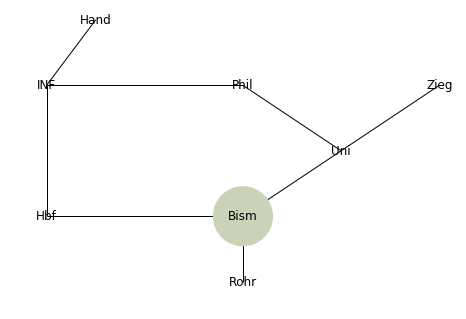

PassagierStation:6, PassagierTime:104, steigt aus, EventTime 104
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 6 steigt um.
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 317. Mal
Länge der Queue: 30 aktion:exit, time:104.True, bm:zykel1.True; aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zykel0.True; aktion:exit, time:113.False, bm:zykel1.False; aktio

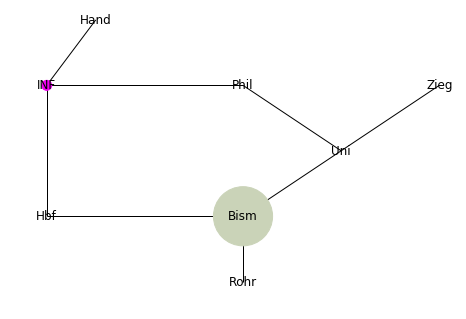

PassagierStation:6, PassagierTime:104, steigt aus, EventTime 104
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel1 zykel1
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 318. Mal
Länge der Queue: 29 aktion:exit, time:104.True, bm:zykel1.True; aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zykel0.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.

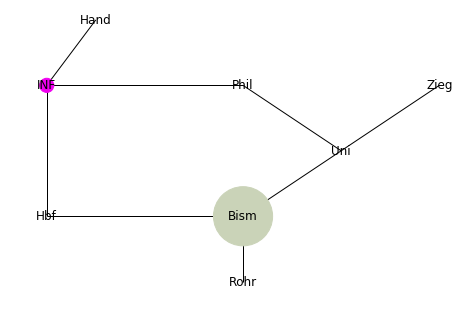

PassagierStation:6, PassagierTime:104, steigt aus, EventTime 104
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel1 zykel1
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 319. Mal
Länge der Queue: 28 aktion:load, time:105.True, bm:zubinger0.True; aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zykel0.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:11

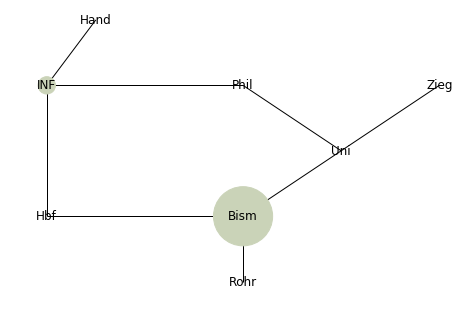

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 320. Mal
Länge der Queue: 28 aktion:load, time:105.True, bm:zubinger1.True; aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zykel0.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.Tru

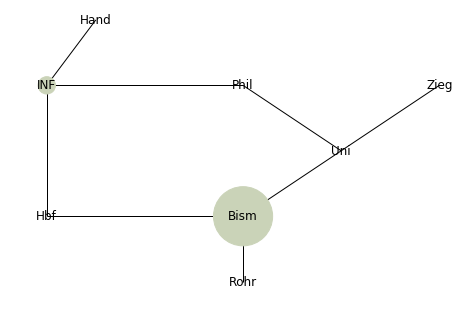

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 321. Mal
Länge der Queue: 28 aktion:load, time:105.True, bm:zubinger2.True; aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zykel0.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.Tru

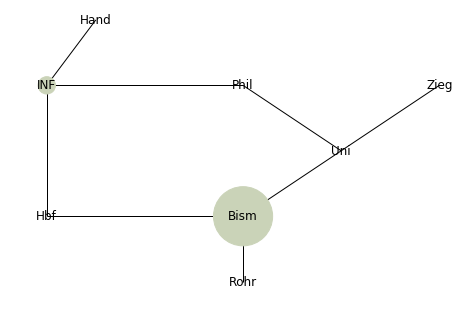

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 322. Mal
Länge der Queue: 28 aktion:load, time:105.True, bm:zykel1.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.Tru

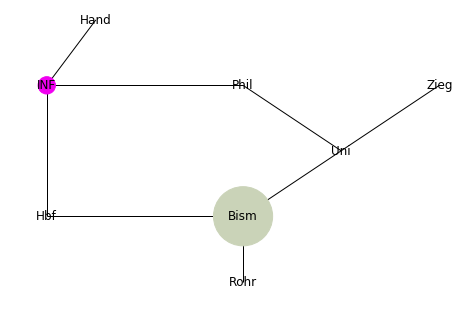

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 7 Plätze frei
3
Berechne, wer zukünftig umsteigen soll
Protect:  ['zubinger1']
Temp:  [[1, 6]]
Es warten noch 3 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 323. Mal
Länge der Queue: 28 aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1

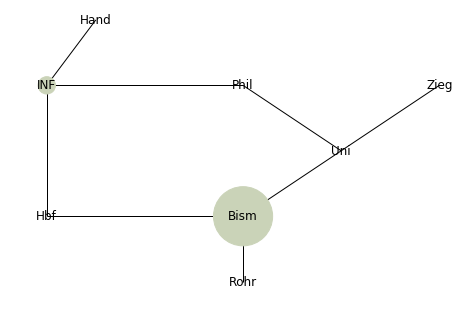

PassagierStation:3, PassagierTime:108, steigt aus, EventTime 108
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 324. Mal
Länge der Queue: 27 aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel

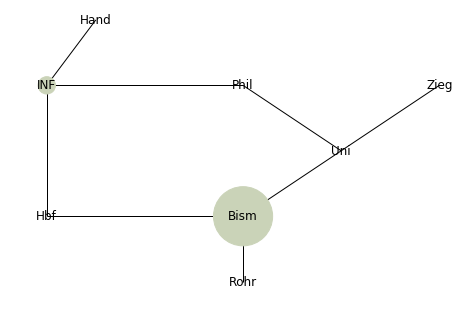

PassagierStation:3, PassagierTime:108, steigt aus, EventTime 108
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 325. Mal
Länge der Queue: 26 aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel

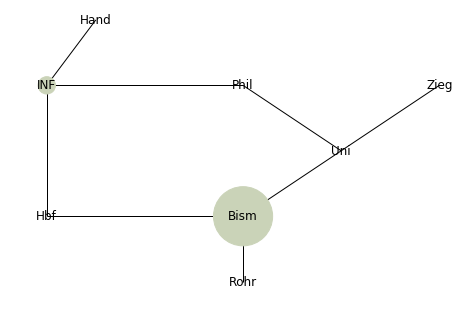

PassagierStation:3, PassagierTime:108, steigt aus, EventTime 108
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 326. Mal
Länge der Queue: 25 aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zyke

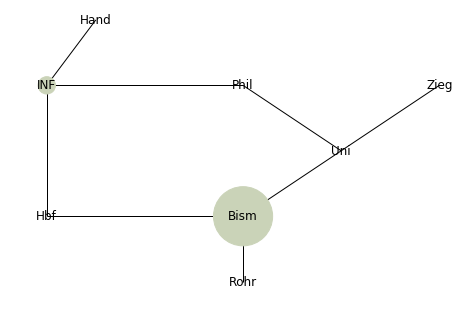

PassagierStation:3, PassagierTime:108, steigt aus, EventTime 108
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 327. Mal
Länge der Queue: 24 aktion:exit, time:108.True, bm:zykel0.True; aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zy

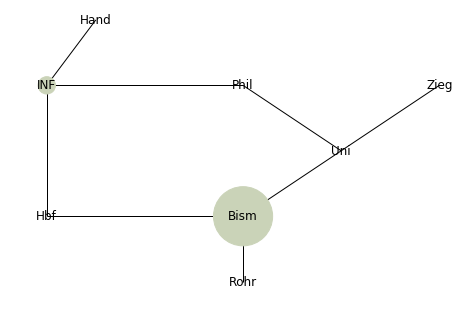

PassagierStation:3, PassagierTime:108, steigt aus, EventTime 108
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 328. Mal
Länge der Queue: 23 aktion:exit, time:108.True, bm:zykel1.True; aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:

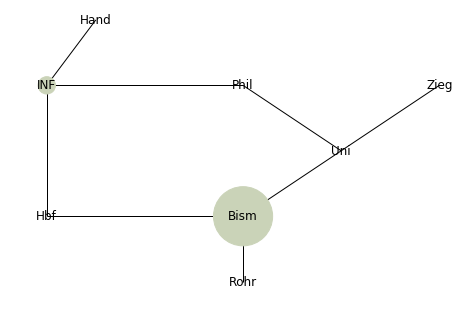

PassagierStation:2, PassagierTime:108, steigt aus, EventTime 108
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 329. Mal
Länge der Queue: 22 aktion:exit, time:108.False, bm:zykel1.False; aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm

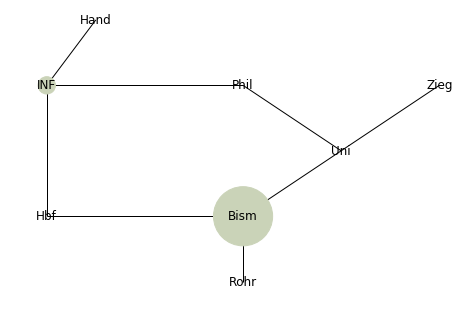

PassagierStation:2, PassagierTime:118, steigt aus, EventTime 108
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [118, 129, 129, 129, 129, 129, 138, 129, 138, 138]
Event BM: zykel1 CList: [108, 113, 119, 113, 119, 119]
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 330. Mal
Länge der Queue: 21 aktion:exit, time:108.False, bm:zykel1.False; aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zyk

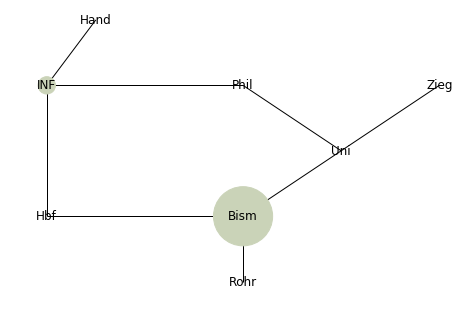

PassagierStation:2, PassagierTime:118, steigt aus, EventTime 108
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [118, 129, 129, 129, 129, 129, 138, 129, 138, 138]
Event BM: zykel1 CList: [113, 113, 119, 119, 119]
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 331. Mal
Länge der Queue: 20 aktion:load, time:110.True, bm:zubinger0.True; aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.F

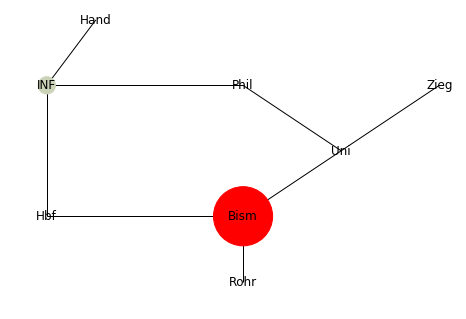

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
35
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zubinger0
Es warten noch 35 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 332. Mal
Länge der Queue: 20 aktion:load, time:110.True, bm:zubinger1.True; aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:ex

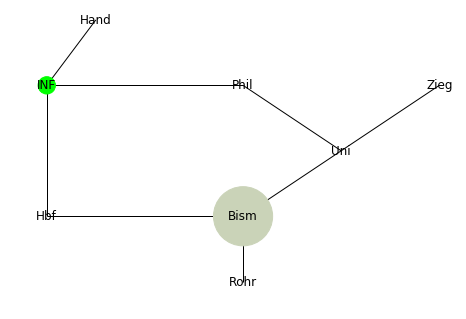

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
3
ExitTime: 113, ListExit: [5]
ExitTime: 113, ListExit: [5]
ExitTime: 113, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 333. Mal
Länge der Queue: 23 aktion:load, time:110.True, bm:zubinger2.True; aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:12

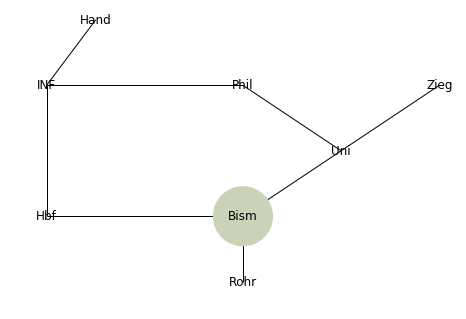

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 334. Mal
Länge der Queue: 23 aktion:load, time:110.True, bm:zykel0.True; aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, ti

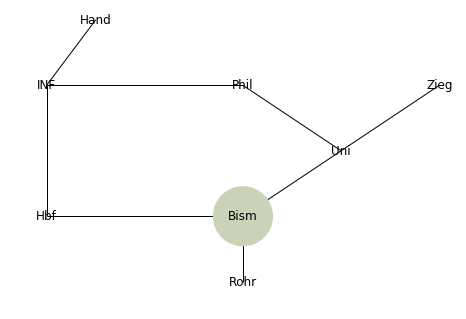

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 5 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 335. Mal
Länge der Queue: 23 aktion:load, time:110.True, bm:zykel1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.

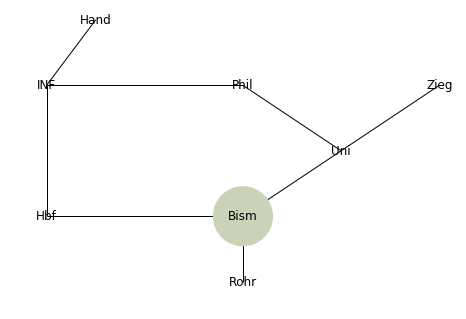

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 10 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 336. Mal
Länge der Queue: 23 aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:12

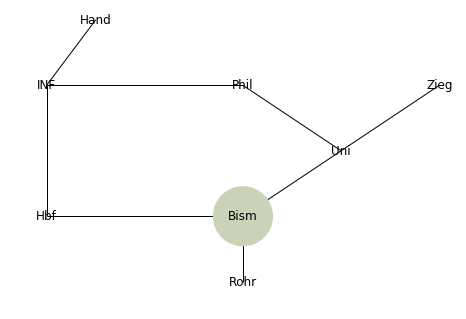

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 113
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 337. Mal
Länge der Queue: 22 aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, 

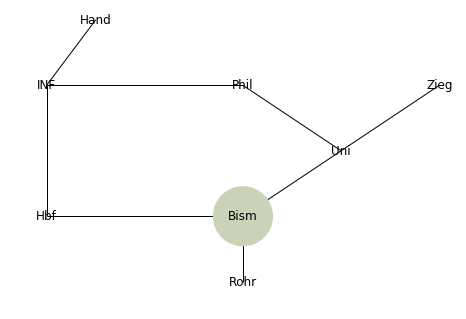

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 113
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 338. Mal
Länge der Queue: 21 aktion:exit, time:113.True, bm:zubinger1.True; aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, b

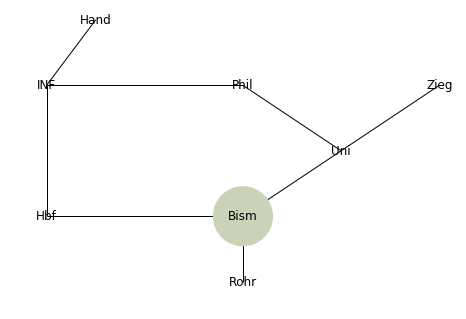

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 113
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 339. Mal
Länge der Queue: 20 aktion:exit, time:113.False, bm:zykel1.False; aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm

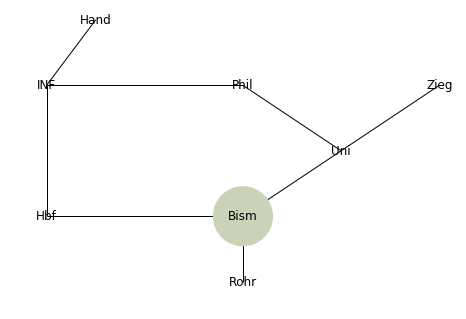

PassagierStation:3, PassagierTime:108, steigt aus, EventTime 113
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [118, 129, 129, 129, 129, 129, 138, 129, 138, 138]
Event BM: zykel1 CList: [113, 119, 119, 119]
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 340. Mal
Länge der Queue: 19 aktion:exit, time:113.False, bm:zykel1.False; aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False;

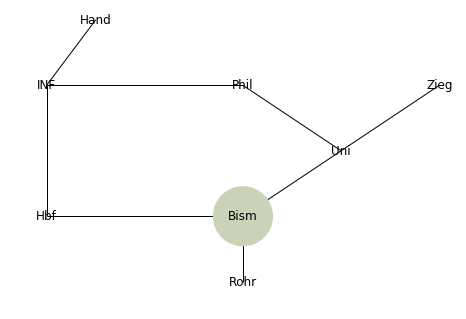

PassagierStation:3, PassagierTime:108, steigt aus, EventTime 113
Ist EventTime == PassagierTime: False
Passenger BM:zykel0 CList: [118, 129, 129, 129, 129, 129, 138, 129, 138, 138]
Event BM: zykel1 CList: [119, 119, 119]
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 341. Mal
Länge der Queue: 18 aktion:load, time:115.True, bm:zubinger0.True; aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; akti

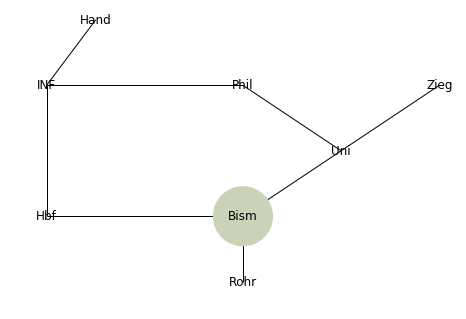

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 342. Mal
Länge der Queue: 18 aktion:load, time:115.True, bm:zubinger1.True; aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138

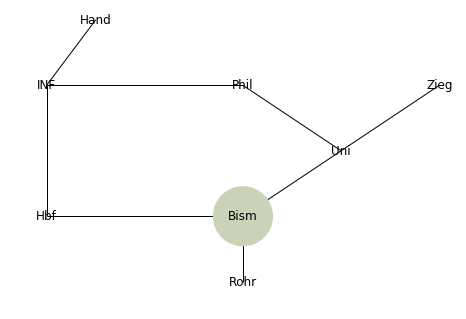

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 343. Mal
Länge der Queue: 18 aktion:load, time:115.True, bm:zubinger2.True; aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138

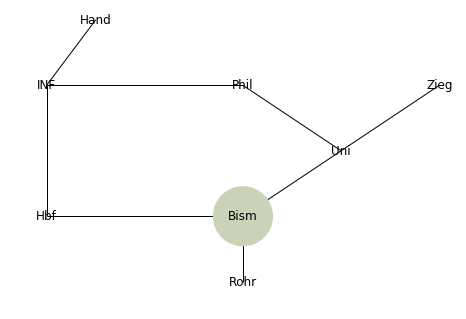

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 344. Mal
Länge der Queue: 18 aktion:load, time:115.True, bm:zykel1.True; aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138

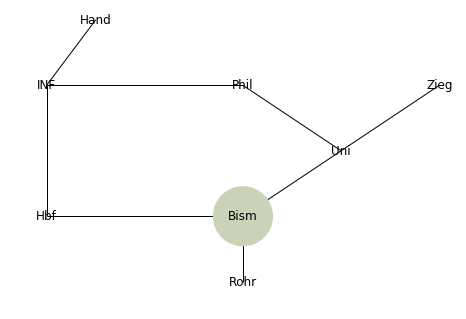

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 12 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 345. Mal
Länge der Queue: 18 aktion:exit, time:118.True, bm:zykel0.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, 

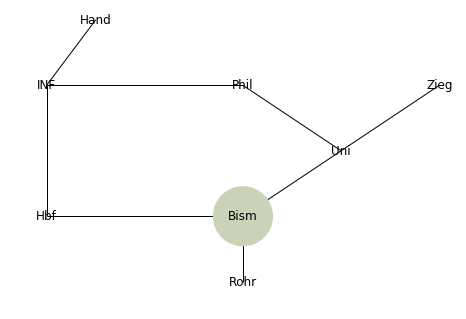

PassagierStation:2, PassagierTime:118, steigt aus, EventTime 118
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 346. Mal
Länge der Queue: 17 aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zy

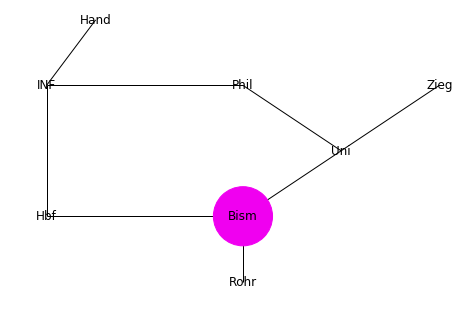

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 119
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 5 steigt um.
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 347. Mal
Länge der Queue: 16 aktion:exit, time:119.True, bm:zykel1.True; aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; 

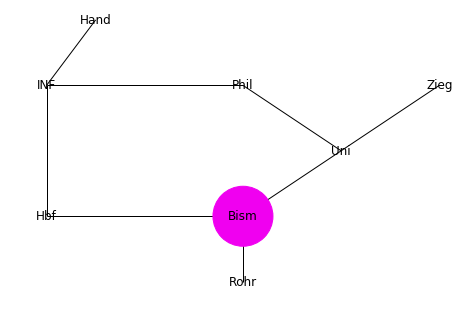

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 119
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel1 zykel1
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 348. Mal
Länge der Queue: 15 aktion:exit, time:119.True, bm:zykel1.True; aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; 
Fahrzeug zykel1

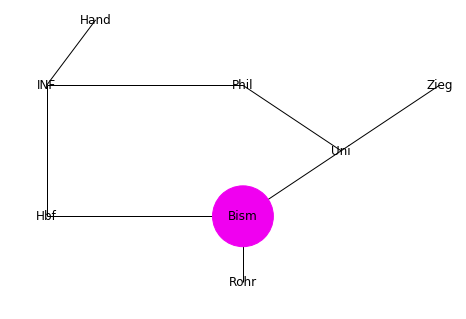

PassagierStation:5, PassagierTime:119, steigt aus, EventTime 119
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel1 zykel1
Passagier mit Ziel: 5 wurde falsch berechnet.
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 349. Mal
Länge der Queue: 14 aktion:load, time:120.True, bm:zubinger0.True; aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; 
Fahrzeug zubinger0 ist am Knoten Bism, der nächste Halt Roh

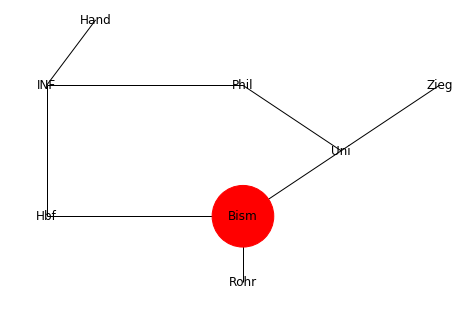

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
38
ExitTime: 123, ListExit: [5]
ExitTime: 123, ListExit: [5]
ExitTime: 123, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zubinger0
Es warten noch 35 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 350. Mal
Länge der Queue: 17 aktion:load, time:120.True, bm:zubinger1.True; aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; akt

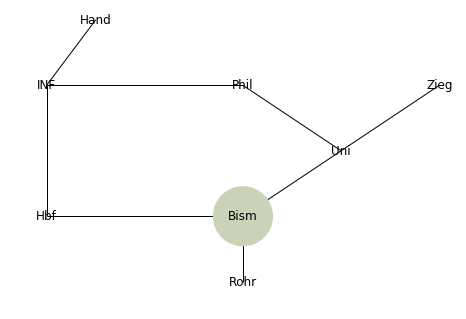

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 351. Mal
Länge der Queue: 17 aktion:load, time:120.True, bm:zubinger2.True; aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; 
Fahrzeug zub

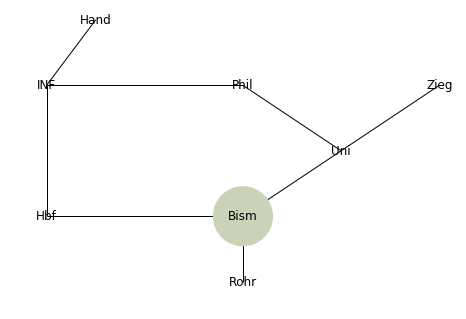

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 352. Mal
Länge der Queue: 17 aktion:load, time:120.True, bm:zykel0.True; aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; 
Fahrzeug zyk

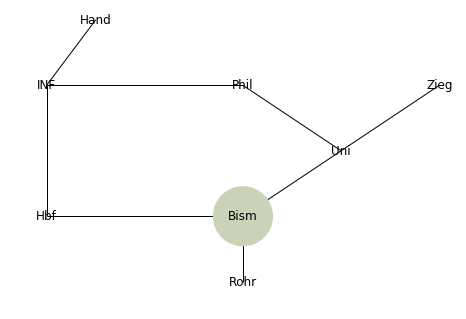

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 6 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 353. Mal
Länge der Queue: 17 aktion:load, time:120.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; aktion:exit, time:138.True, bm:zykel0.True; 
Fahrzeug zykel1 is

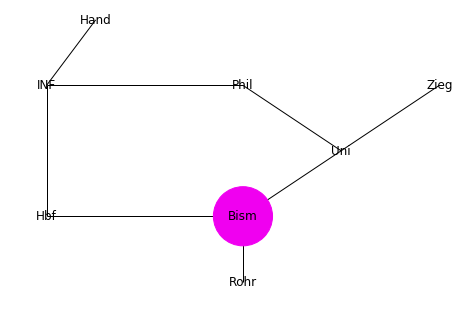

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 15 Plätze frei
35
ExitTime: 128, ListExit: [5, 5]
ExitTime: 123, ListExit: [5]
ExitTime: 138, ListExit: [5, 5, 5, 5]
ExitTime: 123, ListExit: [5]
ExitTime: 138, ListExit: [5, 5, 5, 5]
ExitTime: 133, ListExit: [5, 5, 5]
ExitTime: 133, ListExit: [5, 5, 5]
ExitTime: 123, ListExit: [5]
ExitTime: 128, ListExit: [5, 5]
ExitTime: 128, ListExit: [5, 5]
ExitTime: 138, ListExit: [5, 5, 5, 5]
ExitTime: 123, ListExit: [5]
ExitTime: 123, ListExit: [5]
ExitTime: 133, ListExit: [5, 5, 5]
ExitTime: 133, ListExit: [5, 5, 5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 20 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 354. Mal
Länge der Queue: 32 aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True

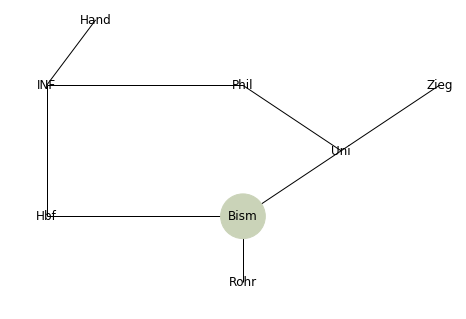

PassagierStation:5, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 355. Mal
Länge der Queue: 31 aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zyk

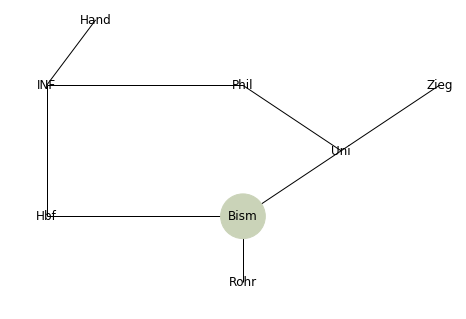

PassagierStation:5, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 356. Mal
Länge der Queue: 30 aktion:exit, time:123.True, bm:zubinger0.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zyke

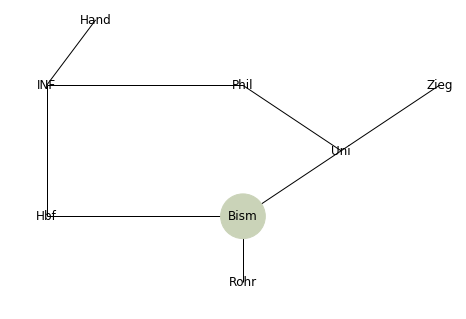

PassagierStation:5, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 357. Mal
Länge der Queue: 29 aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel

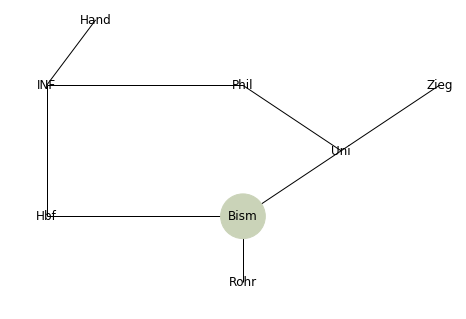

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 358. Mal
Länge der Queue: 28 aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zy

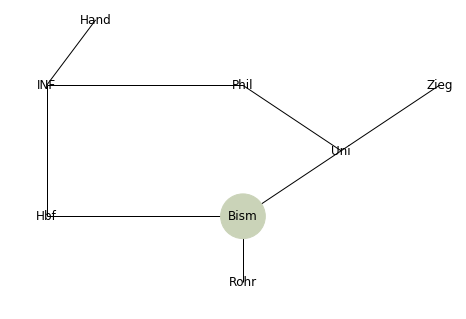

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 359. Mal
Länge der Queue: 27 aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:z

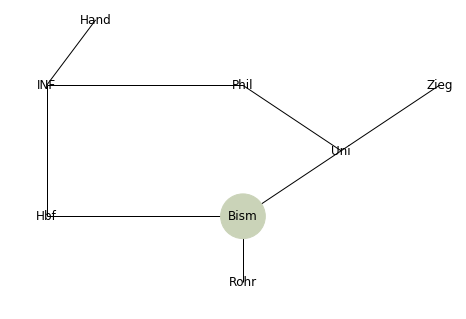

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 360. Mal
Länge der Queue: 26 aktion:exit, time:123.True, bm:zykel1.True; aktion:exit, time:123.True, bm:zykel1.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zykel0.True; aktion:exit, time:133.True, bm:z

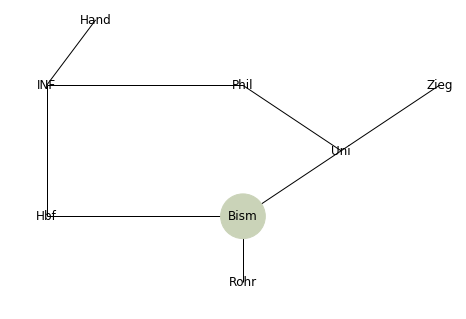

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 361. Mal
Länge der Queue: 25 aktion:exit, time:123.True, bm:zykel1.True; aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zykel0.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:z

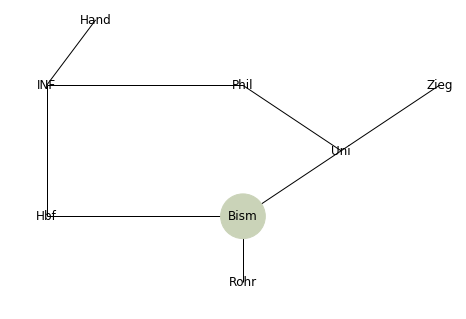

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 123
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 362. Mal
Länge der Queue: 24 aktion:load, time:125.True, bm:zubinger0.True; aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zykel0.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:z

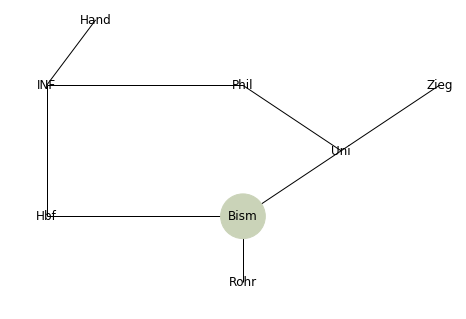

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 363. Mal
Länge der Queue: 24 aktion:load, time:125.True, bm:zubinger1.True; aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zykel0.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133

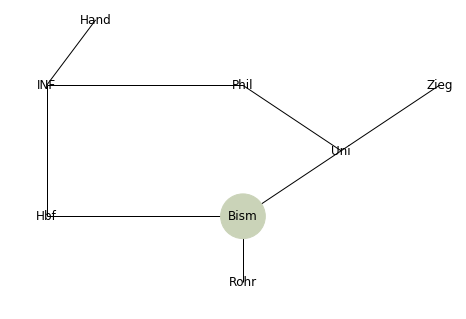

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 364. Mal
Länge der Queue: 24 aktion:load, time:125.True, bm:zubinger2.True; aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zykel0.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133

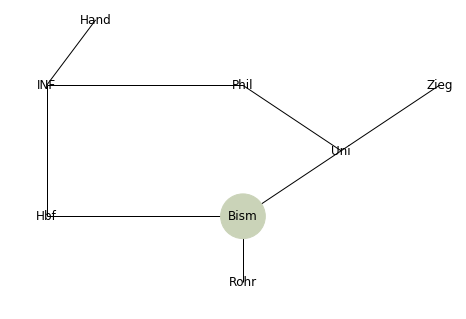

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 365. Mal
Länge der Queue: 24 aktion:load, time:125.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133

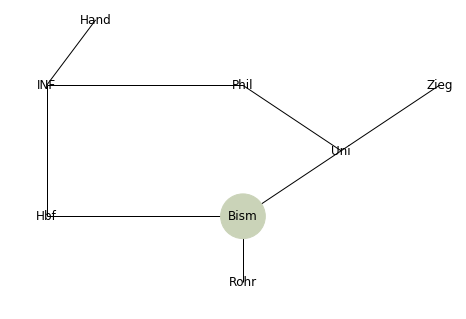

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 5 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 366. Mal
Länge der Queue: 24 aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, b

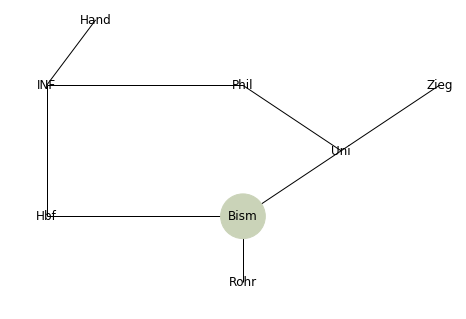

PassagierStation:1, PassagierTime:128, steigt aus, EventTime 128
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 367. Mal
Länge der Queue: 23 aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zy

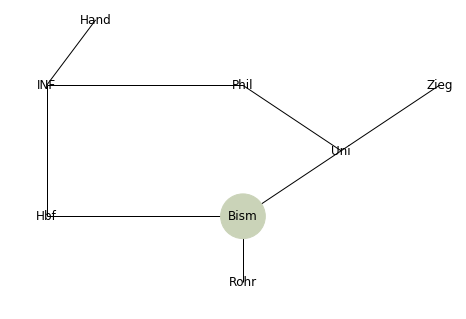

PassagierStation:1, PassagierTime:128, steigt aus, EventTime 128
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 368. Mal
Länge der Queue: 22 aktion:exit, time:128.True, bm:zykel1.True; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:138.False, bm:z

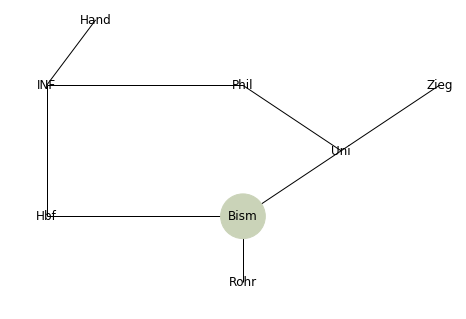

PassagierStation:1, PassagierTime:128, steigt aus, EventTime 128
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 369. Mal
Länge der Queue: 21 aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm

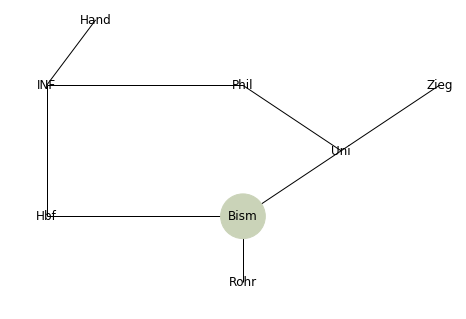

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 129
Ist EventTime == PassagierTime: False
Passenger BM:zubinger1 CList: []
Event BM: zykel0 CList: [129, 129, 138, 129, 129, 138, 138, 129]
Passagier am richtigen Ort: [False, False]
zubinger1 zykel0
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 370. Mal
Länge der Queue: 20 aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; akti

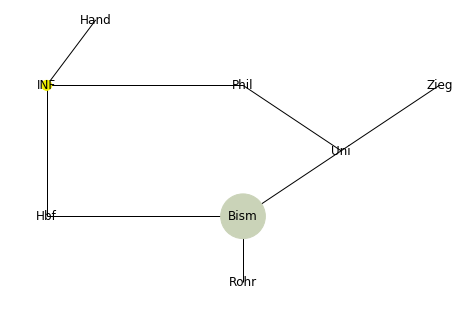

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 129
Ist EventTime == PassagierTime: False
Passenger BM:zubinger1 CList: []
Event BM: zykel0 CList: [129, 129, 138, 129, 129, 138, 138]
Passagier am richtigen Ort: [False, False]
zubinger1 zykel0
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 371. Mal
Länge der Queue: 19 aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit

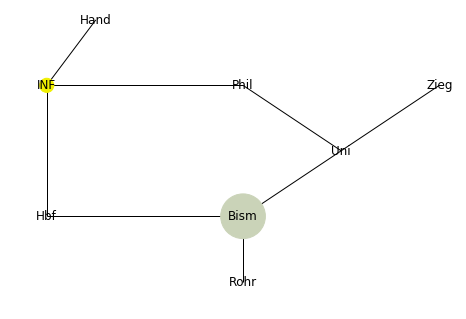

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 129
Ist EventTime == PassagierTime: False
Passenger BM:zubinger1 CList: []
Event BM: zykel0 CList: [129, 129, 138, 129, 138, 138]
Passagier am richtigen Ort: [False, False]
zubinger1 zykel0
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 372. Mal
Länge der Queue: 18 aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, tim

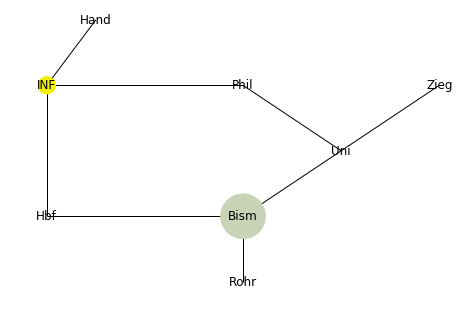

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 129
Ist EventTime == PassagierTime: False
Passenger BM:zubinger1 CList: []
Event BM: zykel0 CList: [129, 129, 138, 138, 138]
Passagier am richtigen Ort: [False, False]
zubinger1 zykel0
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 373. Mal
Länge der Queue: 17 aktion:exit, time:129.False, bm:zykel0.False; aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138

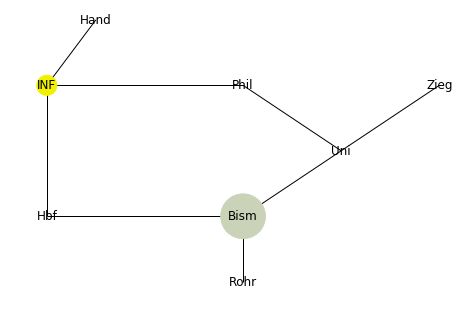

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 129
Ist EventTime == PassagierTime: False
Passenger BM:zubinger1 CList: []
Event BM: zykel0 CList: [129, 138, 138, 138]
Passagier am richtigen Ort: [False, False]
zubinger1 zykel0
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 374. Mal
Länge der Queue: 16 aktion:exit, time:129.False, bm:zykel0.False; aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True

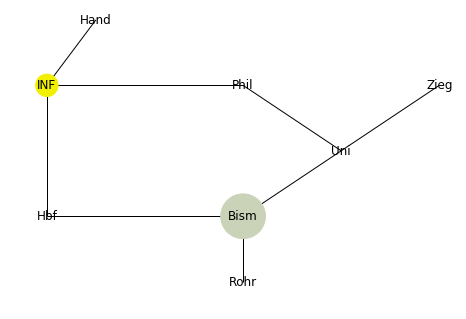

PassagierStation:6, PassagierTime:113, steigt aus, EventTime 129
Ist EventTime == PassagierTime: False
Passenger BM:zubinger1 CList: []
Event BM: zykel0 CList: [138, 138, 138]
Passagier am richtigen Ort: [False, False]
zubinger1 zykel0
Passagier mit Ziel: 6 wurde falsch berechnet.
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 375. Mal
Länge der Queue: 15 aktion:load, time:130.True, bm:zubinger0.True; aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zy

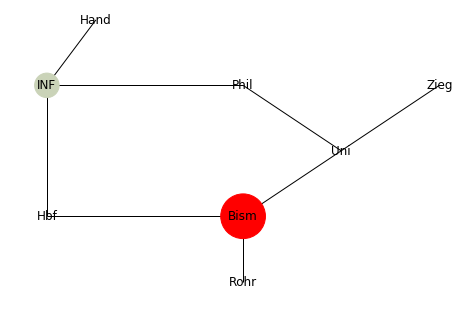

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
20
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zubinger0
Es warten noch 20 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 376. Mal
Länge der Queue: 15 aktion:load, time:130.True, bm:zubinger1.True; aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:ex

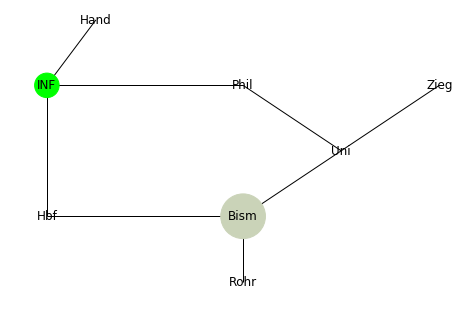

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
6
ExitTime: 133, ListExit: [5]
ExitTime: 133, ListExit: [5]
ExitTime: 133, ListExit: [5]
ExitTime: 133, ListExit: [5]
ExitTime: 133, ListExit: [5]
ExitTime: 133, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 377. Mal
Länge der Queue: 21 aktion:load, time:130.True, bm:zubinger2.True; aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.Tr

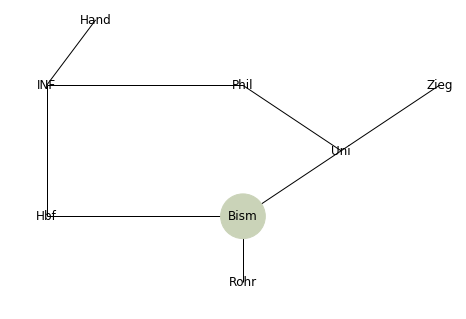

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 378. Mal
Länge der Queue: 21 aktion:load, time:130.True, bm:zykel0.True; aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit,

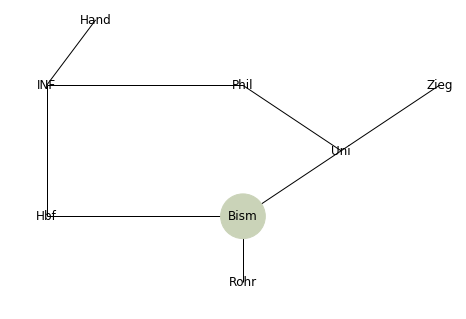

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 12 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 379. Mal
Länge der Queue: 21 aktion:load, time:130.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, tim

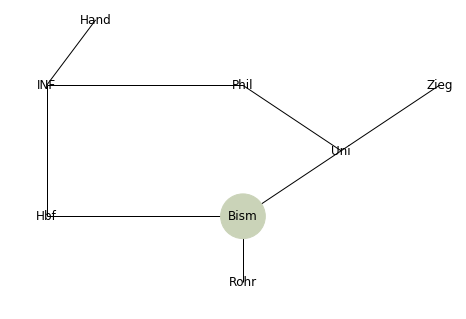

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 8 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 380. Mal
Länge der Queue: 21 aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time

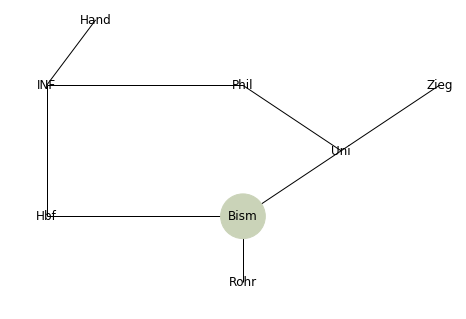

PassagierStation:6, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 381. Mal
Länge der Queue: 20 aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.Tr

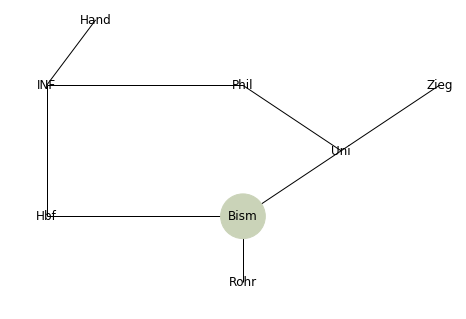

PassagierStation:6, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 382. Mal
Länge der Queue: 19 aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True,

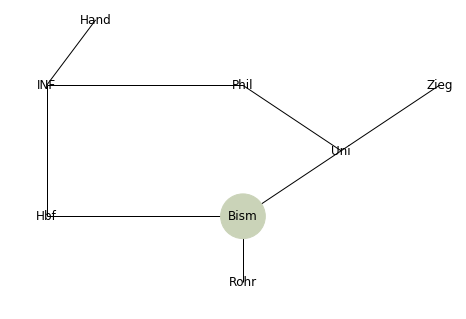

PassagierStation:6, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 383. Mal
Länge der Queue: 18 aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm

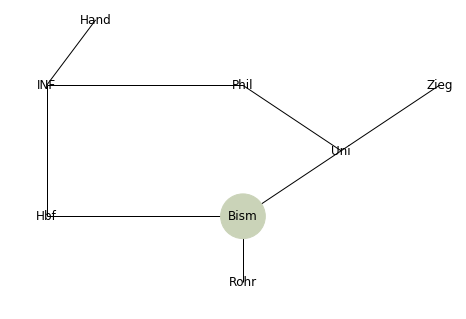

PassagierStation:6, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 384. Mal
Länge der Queue: 17 aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zy

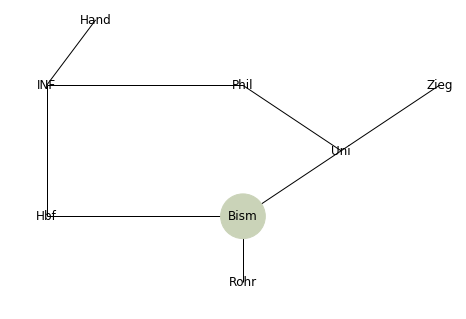

PassagierStation:6, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 385. Mal
Länge der Queue: 16 aktion:exit, time:133.True, bm:zubinger1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zubinger1 ist am Knoten Ha

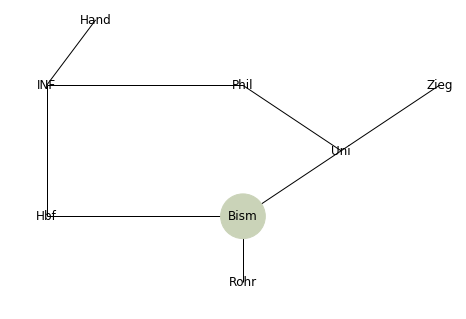

PassagierStation:6, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 386. Mal
Länge der Queue: 15 aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Phil, der nächste Halt Uni, die aktuelle Zeit: 133
u

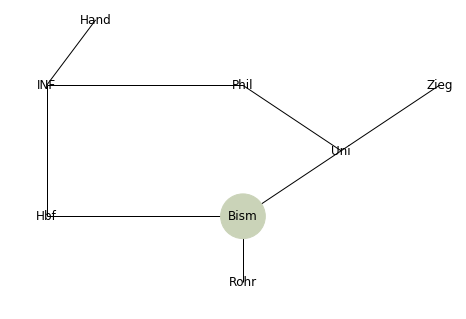

PassagierStation:2, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 387. Mal
Länge der Queue: 14 aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Phil, der nächste Halt Uni, die aktuelle Zeit: 133
und zykel1 Stopp zum 27. Mal, Runden: 5, Rest

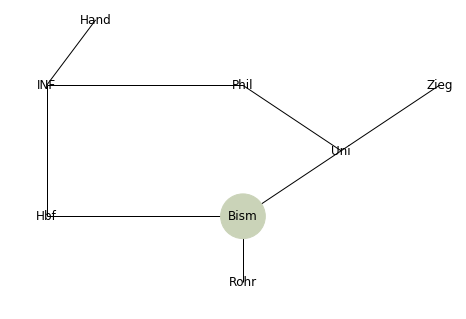

PassagierStation:2, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 388. Mal
Länge der Queue: 13 aktion:exit, time:133.True, bm:zykel1.True; aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Phil, der nächste Halt Uni, die aktuelle Zeit: 133
und zykel1 Stopp zum 27. Mal, Runden: 5, Rest: 2
Graph gespeichert als file00133.png, wir

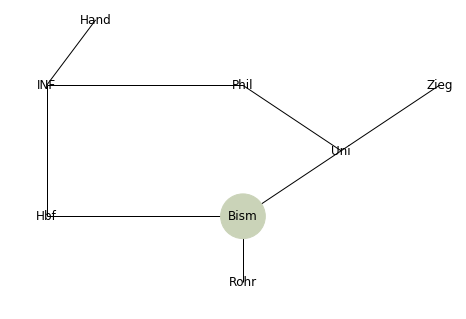

PassagierStation:2, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 389. Mal
Länge der Queue: 12 aktion:exit, time:133.True, bm:zykel1.True; aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Phil, der nächste Halt Uni, die aktuelle Zeit: 133
und zykel1 Stopp zum 27. Mal, Runden: 5, Rest: 2
Graph gespeichert als file00133.png, wird in imglist hinzugefügt


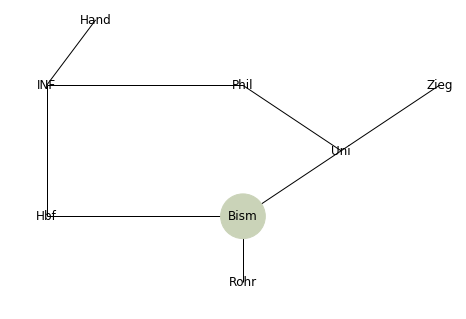

PassagierStation:2, PassagierTime:133, steigt aus, EventTime 133
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 390. Mal
Länge der Queue: 11 aktion:load, time:135.True, bm:zubinger0.True; aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zubinger0 ist am Knoten Rohr, der nächste Halt Bism, die aktuelle Zeit: 135
und zubinger0 Stopp zum 27. Mal, Runden: 13, Rest: 1
Graph gespeichert als file00135.png, wird in imglist hinzugefügt


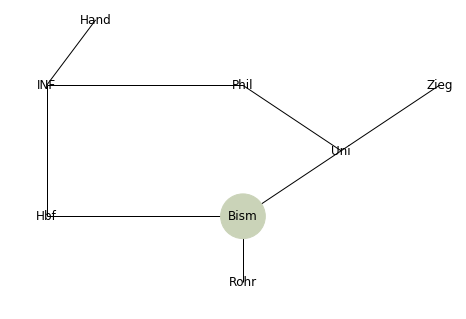

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 391. Mal
Länge der Queue: 11 aktion:load, time:135.True, bm:zubinger1.True; aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zubinger1 ist am Knoten Hand, der nächste Halt INF, die aktuelle Zeit: 135
und zubinger1 Stopp zum 27. Mal, Runden: 13, Rest: 1
Graph gespeichert als file00135.png, wird in imglist hinzugefügt


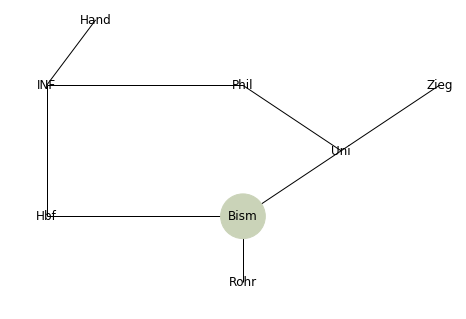

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 392. Mal
Länge der Queue: 11 aktion:load, time:135.True, bm:zubinger2.True; aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 135
und zubinger2 Stopp zum 27. Mal, Runden: 13, Rest: 1
Graph gespeichert als file00135.png, wird in imglist hinzugefügt


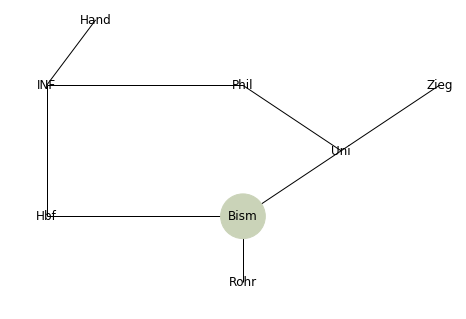

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 393. Mal
Länge der Queue: 11 aktion:load, time:135.True, bm:zykel1.True; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Phil, der nächste Halt Uni, die aktuelle Zeit: 135
und zykel1 Stopp zum 27. Mal, Runden: 5, Rest: 2
Graph gespeichert als file00135.png, wird in imglist hinzugefügt


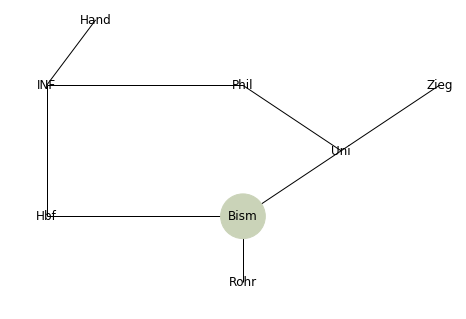

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 12 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 394. Mal
Länge der Queue: 11 aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; 
Fahrzeug zykel0 ist am Knoten Hbf, der nächste Halt Bism, die aktuelle Zeit: 138
und zykel0 Stopp zum 14. Mal, Runden: 2, Rest: 4
Graph gespeichert als file00138.png, wird in imglist hinzugefügt


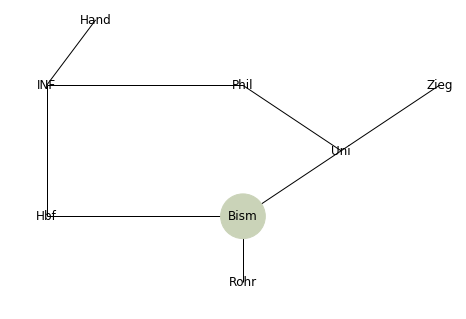

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 138
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [138, 138, 138]
Event BM: zykel0 CList: [138, 138]
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 395. Mal
Länge der Queue: 10 aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; 
Fahrzeug zykel0 ist am Knoten Hbf, der nächste Halt Bism, die aktuelle Zeit: 138
und zykel0 Stopp zum 14. Mal, Runden: 2, Rest: 4
Graph gespeichert als file00138.png, wird in imglist hinzugefügt


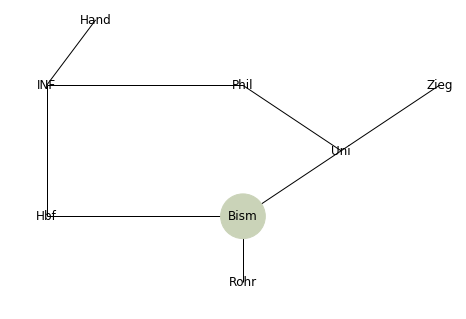

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 138
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [138, 138, 138]
Event BM: zykel0 CList: [138]
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 396. Mal
Länge der Queue: 9 aktion:exit, time:138.False, bm:zykel0.False; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; 
Fahrzeug zykel0 ist am Knoten Hbf, der nächste Halt Bism, die aktuelle Zeit: 138
und zykel0 Stopp zum 14. Mal, Runden: 2, Rest: 4
Graph gespeichert als file00138.png, wird in imglist hinzugefügt


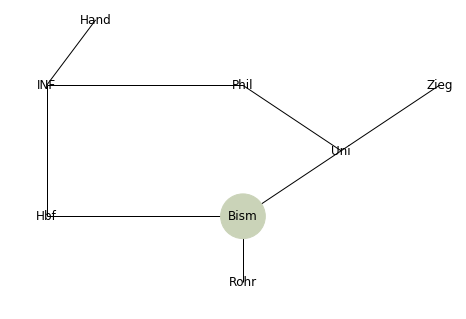

PassagierStation:0, PassagierTime:123, steigt aus, EventTime 138
Ist EventTime == PassagierTime: False
Passenger BM:zykel1 CList: [138, 138, 138]
Event BM: zykel0 CList: []
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 397. Mal
Länge der Queue: 8 aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 138
und zykel1 Stopp zum 28. Mal, Runden: 5, Rest: 3
Graph gespeichert als file00138.png, wird in imglist hinzugefügt


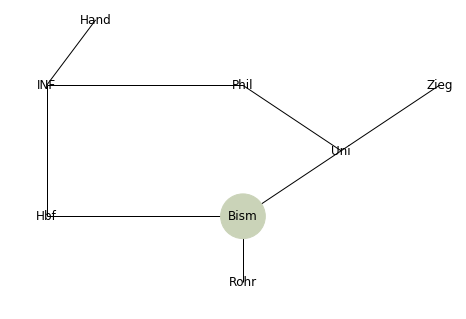

PassagierStation:3, PassagierTime:138, steigt aus, EventTime 138
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 398. Mal
Länge der Queue: 7 aktion:exit, time:138.True, bm:zykel1.True; aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 138
und zykel1 Stopp zum 28. Mal, Runden: 5, Rest: 3
Graph gespeichert als file00138.png, wird in imglist hinzugefügt


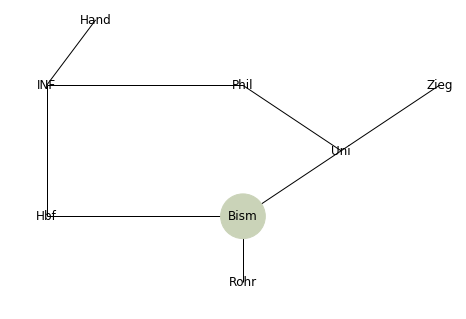

PassagierStation:3, PassagierTime:138, steigt aus, EventTime 138
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 399. Mal
Länge der Queue: 6 aktion:exit, time:138.True, bm:zykel1.True; aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 138
und zykel1 Stopp zum 28. Mal, Runden: 5, Rest: 3
Graph gespeichert als file00138.png, wird in imglist hinzugefügt


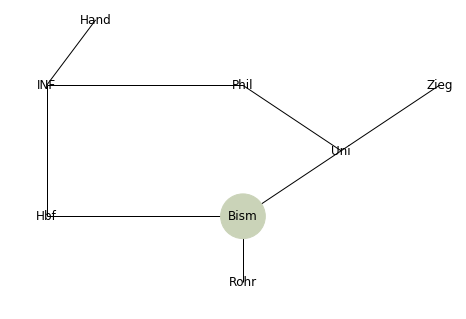

PassagierStation:3, PassagierTime:138, steigt aus, EventTime 138
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 400. Mal
Länge der Queue: 5 aktion:load, time:140.True, bm:zubinger0.True; aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; 
Fahrzeug zubinger0 ist am Knoten Bism, der nächste Halt Rohr, die aktuelle Zeit: 140
und zubinger0 Stopp zum 28. Mal, Runden: 14, Rest: 0
Graph gespeichert als file00140.png, wird in imglist hinzugefügt


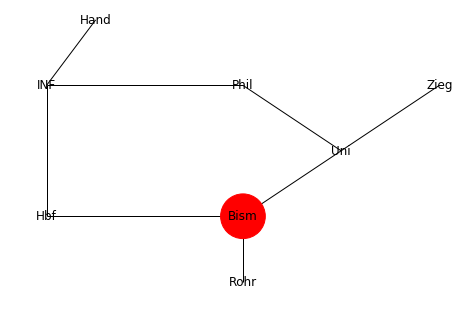

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
20
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zubinger0
Es warten noch 20 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 401. Mal
Länge der Queue: 5 aktion:load, time:140.True, bm:zubinger1.True; aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; aktion:load, time:145.True, bm:zubinger0.True; 
Fahrzeug zubinger1 ist am Knoten INF, der nächste Halt Hand, die aktuelle Zeit: 140
und zubinger1 Stopp zum 28. Mal, Runden: 14, Rest: 0
Graph gespeichert als file00140.png, wird in imglist hinzugefügt


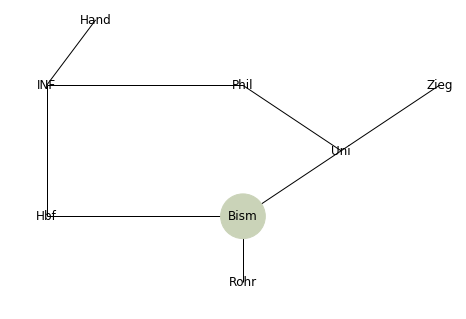

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 402. Mal
Länge der Queue: 5 aktion:load, time:140.True, bm:zubinger2.True; aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; aktion:load, time:145.True, bm:zubinger0.True; aktion:load, time:145.True, bm:zubinger1.True; 
Fahrzeug zubinger2 ist am Knoten Uni, der nächste Halt Zieg, die aktuelle Zeit: 140
und zubinger2 Stopp zum 28. Mal, Runden: 14, Rest: 0
Graph gespeichert als file00140.png, wird in imglist hinzugefügt


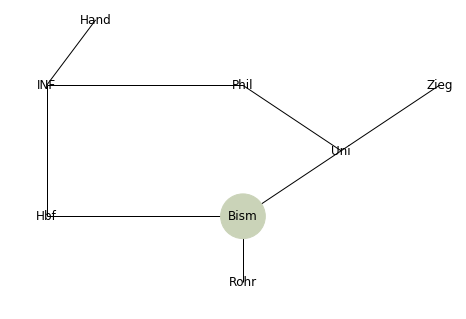

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 403. Mal
Länge der Queue: 5 aktion:load, time:140.True, bm:zykel0.True; aktion:load, time:140.True, bm:zykel1.True; aktion:load, time:145.True, bm:zubinger0.True; aktion:load, time:145.True, bm:zubinger1.True; aktion:load, time:145.True, bm:zubinger2.True; 
Fahrzeug zykel0 ist am Knoten Hbf, der nächste Halt Bism, die aktuelle Zeit: 140
und zykel0 Stopp zum 14. Mal, Runden: 2, Rest: 4
Graph gespeichert als file00140.png, wird in imglist hinzugefügt


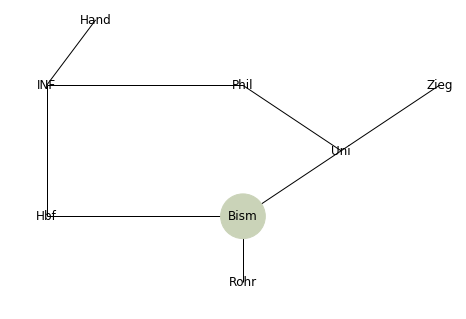

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 404. Mal
Länge der Queue: 5 aktion:load, time:140.True, bm:zykel1.True; aktion:load, time:145.True, bm:zubinger0.True; aktion:load, time:145.True, bm:zubinger1.True; aktion:load, time:145.True, bm:zubinger2.True; aktion:load, time:150.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 140
und zykel1 Stopp zum 28. Mal, Runden: 5, Rest: 3
Graph gespeichert als file00140.png, wird in imglist hinzugefügt


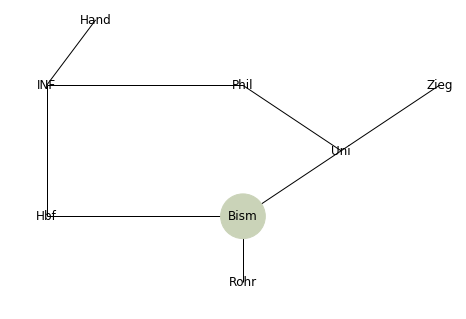

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 405. Mal
Länge der Queue: 5 aktion:load, time:145.True, bm:zubinger0.True; aktion:load, time:145.True, bm:zubinger1.True; aktion:load, time:145.True, bm:zubinger2.True; aktion:load, time:145.True, bm:zykel1.True; aktion:load, time:150.True, bm:zykel0.True; 
Fahrzeug zubinger0 ist am Knoten Rohr, der nächste Halt Bism, die aktuelle Zeit: 145
und zubinger0 Stopp zum 29. Mal, Runden: 14, Rest: 1
Graph gespeichert als file00145.png, wird in imglist hinzugefügt


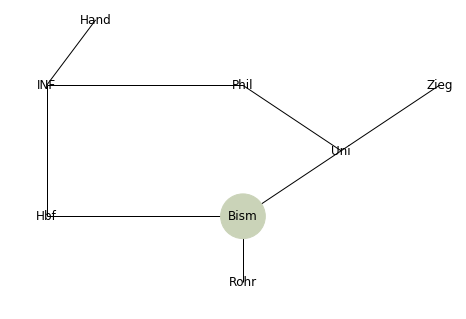

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 406. Mal
Länge der Queue: 5 aktion:load, time:145.True, bm:zubinger1.True; aktion:load, time:145.True, bm:zubinger2.True; aktion:load, time:145.True, bm:zykel1.True; aktion:load, time:150.True, bm:zubinger0.True; aktion:load, time:150.True, bm:zykel0.True; 
Fahrzeug zubinger1 ist am Knoten Hand, der nächste Halt INF, die aktuelle Zeit: 145
und zubinger1 Stopp zum 29. Mal, Runden: 14, Rest: 1
Graph gespeichert als file00145.png, wird in imglist hinzugefügt


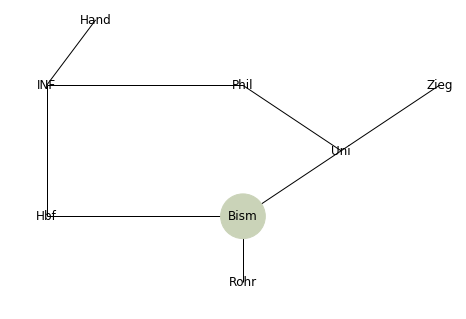

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 407. Mal
Länge der Queue: 5 aktion:load, time:145.True, bm:zubinger2.True; aktion:load, time:145.True, bm:zykel1.True; aktion:load, time:150.True, bm:zubinger0.True; aktion:load, time:150.True, bm:zubinger1.True; aktion:load, time:150.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 145
und zubinger2 Stopp zum 29. Mal, Runden: 14, Rest: 1
Graph gespeichert als file00145.png, wird in imglist hinzugefügt


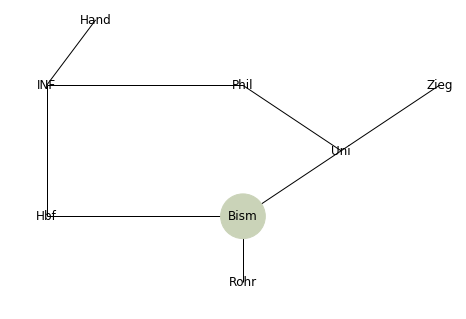

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 408. Mal
Länge der Queue: 5 aktion:load, time:145.True, bm:zykel1.True; aktion:load, time:150.True, bm:zubinger0.True; aktion:load, time:150.True, bm:zubinger1.True; aktion:load, time:150.True, bm:zubinger2.True; aktion:load, time:150.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Bism, der nächste Halt Hbf, die aktuelle Zeit: 145
und zykel1 Stopp zum 29. Mal, Runden: 5, Rest: 4
Graph gespeichert als file00145.png, wird in imglist hinzugefügt


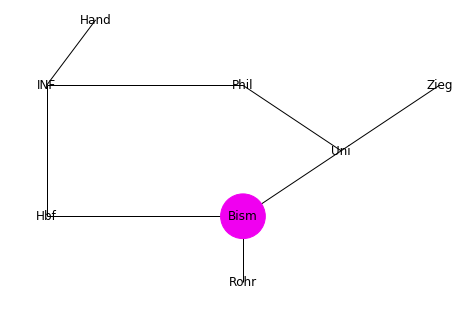

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 15 Plätze frei
20
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zubinger0
[4, 3]
[4, 3]
Temp:  [[4, 5], [3, 7]]
exit_node  3
ExitTime: 164, ListExit: [5, 5, 5, 5]
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
dummy
[4, 3]
[4, 3]
Temp:  [[4, 5], [3, 7]]
exit_node  3
ExitTime: 164, ListExit: [5, 5, 5, 5]
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zykel1
[4, 3]
[4, 3]
Temp:  [[

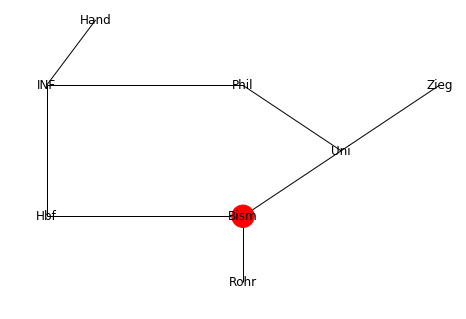

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
5
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zykel1
Es warten noch 5 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 410. Mal
Länge der Queue: 20 aktion:load, time:150.True, bm:zubinger1.True; aktion:load, time:150.True, bm:zubinger2.True; aktion:load, time:150.True, bm:zykel0.True; aktion:load, time:150.True, bm:zykel1.True; aktion:load, time:155.True, bm:zubinger0.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:16

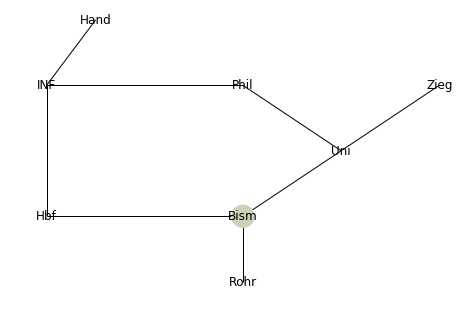

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 411. Mal
Länge der Queue: 20 aktion:load, time:150.True, bm:zubinger2.True; aktion:load, time:150.True, bm:zykel0.True; aktion:load, time:150.True, bm:zykel1.True; aktion:load, time:155.True, bm:zubinger0.True; aktion:load, time:155.True, bm:zubinger1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zyk

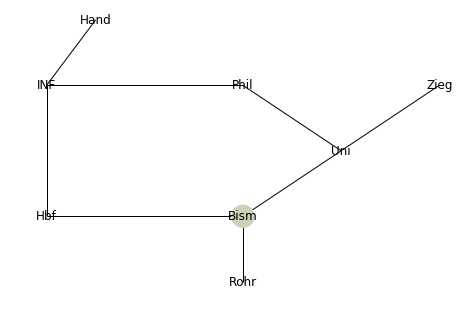

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 412. Mal
Länge der Queue: 20 aktion:load, time:150.True, bm:zykel0.True; aktion:load, time:150.True, bm:zykel1.True; aktion:load, time:155.True, bm:zubinger0.True; aktion:load, time:155.True, bm:zubinger1.True; aktion:load, time:155.True, bm:zubinger2.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zykel1.True; aktion:exit, time:164.True, bm:zyk

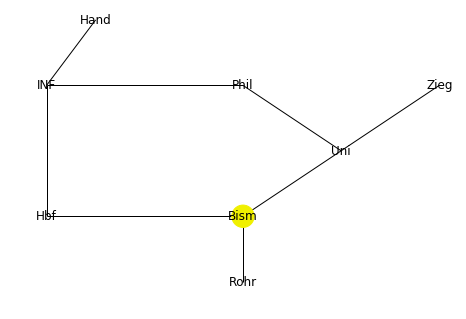

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 15 Plätze frei
5
Berechne, wer zukünftig umsteigen soll
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zykel1
[4, 3]
[4, 3]
Temp:  [[4, 5], [3, 7]]
exit_node  3
ExitTime: 159, ListExit: [10]
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zykel0
[4, 3]
[4, 3]
Temp:  [[4, 5], [3, 7]]
exit_node  3
ExitTime: 159, ListExit: [10]
Protect:  []
Temp:  [[4, 5], [3, 7]]
path  [5, 3]
path1 [4, 3]
PATH0  [['zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
PATH1  [['zykel0', 'zykel1', 'zubinger0'], ['zykel0', 'zykel1', 'zubinger2']]
[False, True]
[True, True]
zykel0
[4, 3]
[4, 3]
Temp:  [[4, 5], [3, 7]]
exit

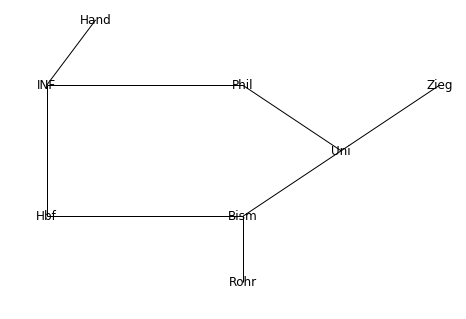

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 0 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hbf

 Durchläuft die While-Schleife zum 414. Mal
Länge der Queue: 25 aktion:load, time:155.True, bm:zubinger0.True; aktion:load, time:155.True, bm:zubinger1.True; aktion:load, time:155.True, bm:zubinger2.True; aktion:load, time:155.True, bm:zykel1.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel0.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False

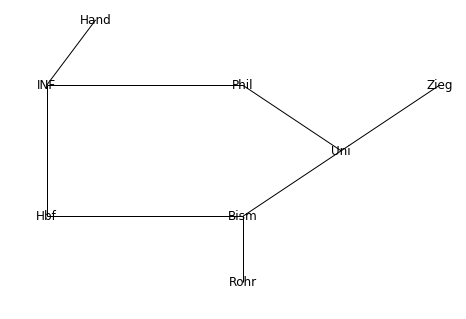

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 415. Mal
Länge der Queue: 25 aktion:load, time:155.True, bm:zubinger1.True; aktion:load, time:155.True, bm:zubinger2.True; aktion:load, time:155.True, bm:zykel1.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zykel0.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:1

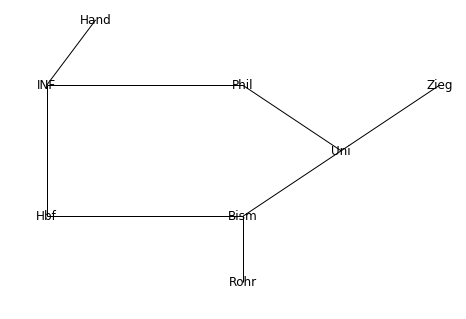

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 416. Mal
Länge der Queue: 25 aktion:load, time:155.True, bm:zubinger2.True; aktion:load, time:155.True, bm:zykel1.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zykel0.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:1

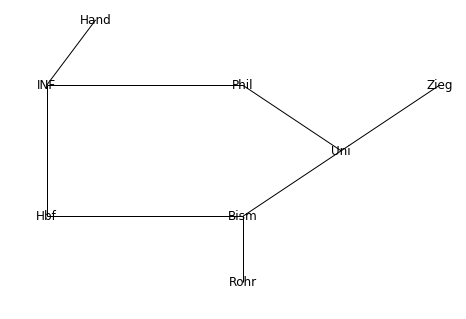

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 417. Mal
Länge der Queue: 25 aktion:load, time:155.True, bm:zykel1.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:1

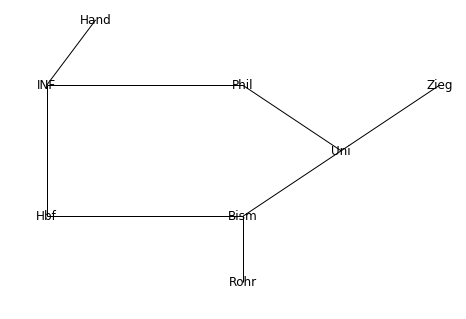

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 0 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 418. Mal
Länge der Queue: 25 aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False

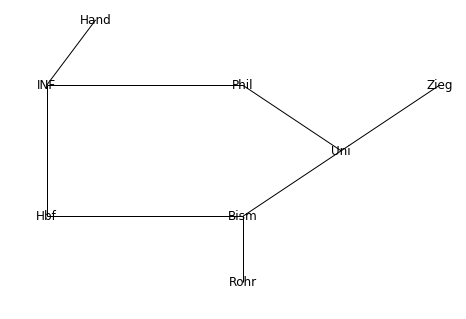

PassagierStation:7, PassagierTime:159, steigt aus, EventTime 159
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 7 steigt um.
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 419. Mal
Länge der Queue: 24 aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False

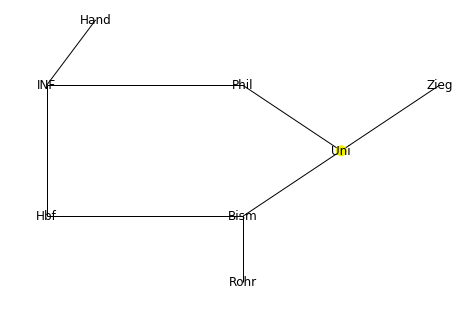

PassagierStation:7, PassagierTime:159, steigt aus, EventTime 159
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, True]
Passagier mit Ziel: 7 steigt um.
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 420. Mal
Länge der Queue: 23 aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.Fal

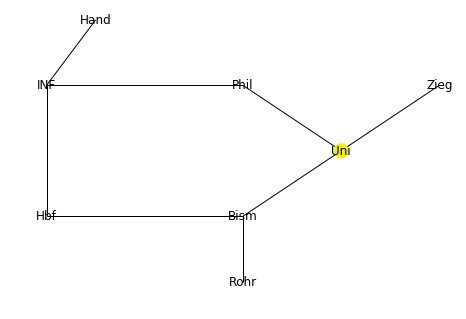

PassagierStation:7, PassagierTime:159, steigt aus, EventTime 159
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 421. Mal
Länge der Queue: 22 aktion:exit, time:159.True, bm:zykel0.True; aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit,

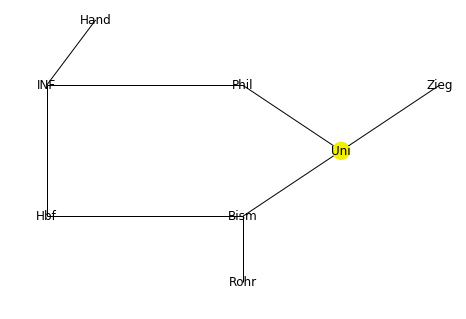

PassagierStation:7, PassagierTime:159, steigt aus, EventTime 159
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 422. Mal
Länge der Queue: 21 aktion:exit, time:159.True, bm:zykel0.True; aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exi

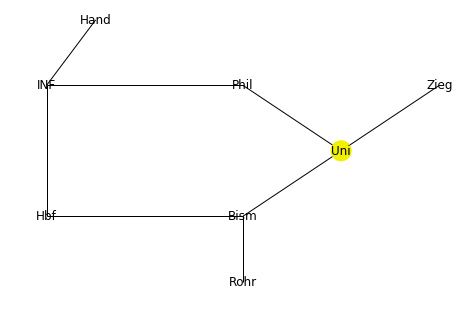

PassagierStation:7, PassagierTime:159, steigt aus, EventTime 159
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [False, False]
zykel0 zykel0
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 423. Mal
Länge der Queue: 20 aktion:load, time:160.True, bm:zubinger0.True; aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:e

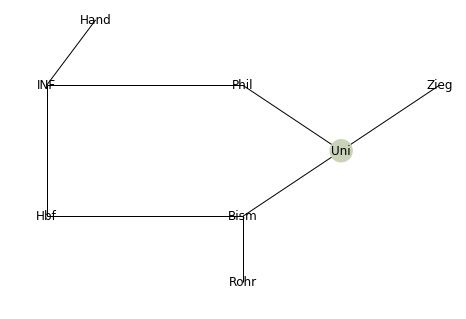

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 424. Mal
Länge der Queue: 20 aktion:load, time:160.True, bm:zubinger1.True; aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exi

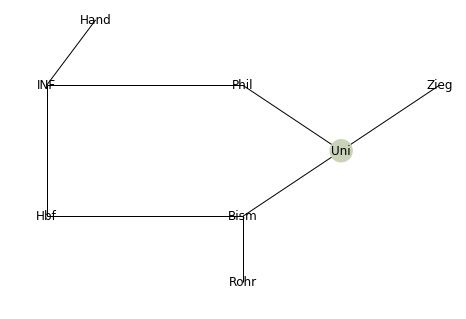

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 425. Mal
Länge der Queue: 20 aktion:load, time:160.True, bm:zubinger2.True; aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit,

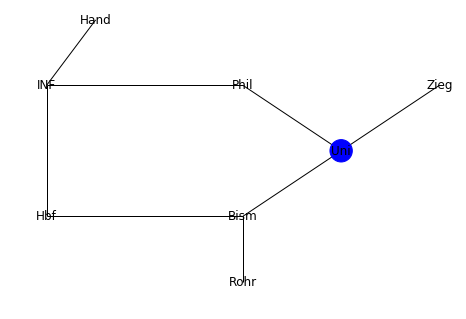

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
5
ExitTime: 163, ListExit: [5]
ExitTime: 163, ListExit: [5]
ExitTime: 163, ListExit: [5]
ExitTime: 163, ListExit: [5]
ExitTime: 163, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 426. Mal
Länge der Queue: 25 aktion:load, time:160.True, bm:zykel0.True; aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; a

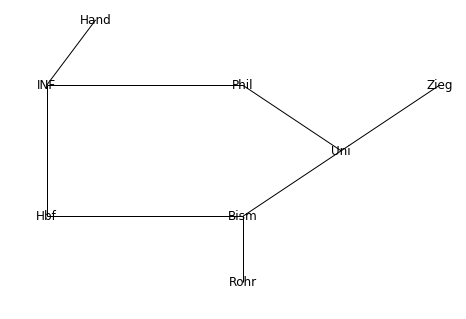

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 427. Mal
Länge der Queue: 25 aktion:load, time:160.True, bm:zykel1.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit,

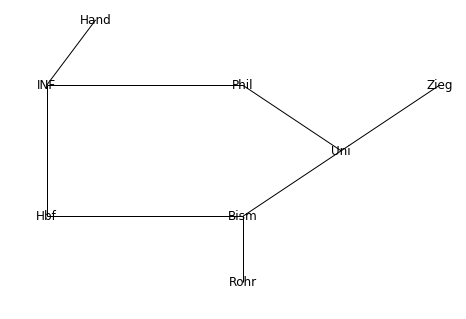

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 0 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 428. Mal
Länge der Queue: 25 aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exi

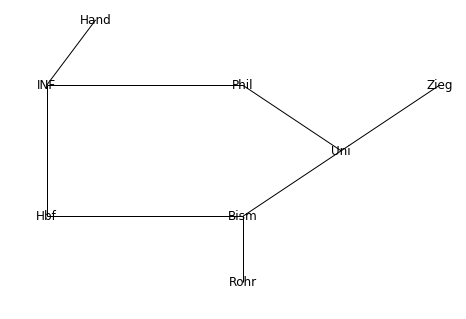

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 163
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 429. Mal
Länge der Queue: 24 aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:

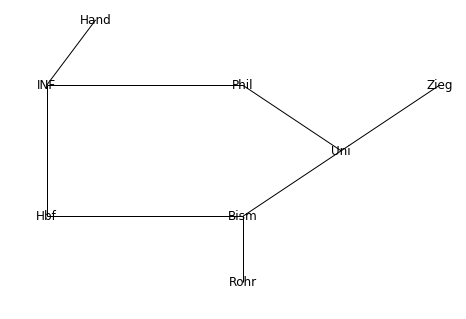

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 163
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 430. Mal
Länge der Queue: 23 aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:1

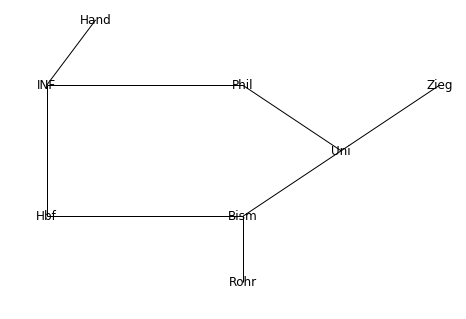

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 163
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 431. Mal
Länge der Queue: 22 aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:16

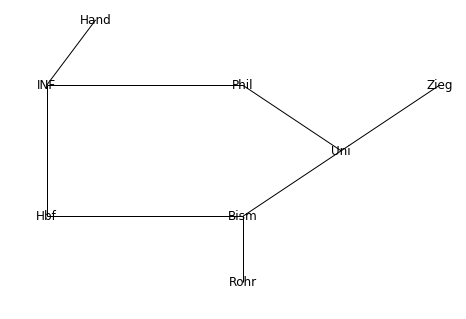

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 163
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 432. Mal
Länge der Queue: 21 aktion:exit, time:163.True, bm:zubinger2.True; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165

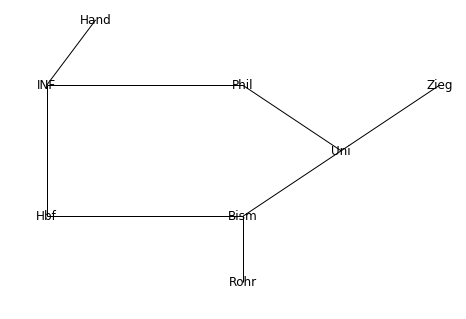

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 163
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 433. Mal
Länge der Queue: 20 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165

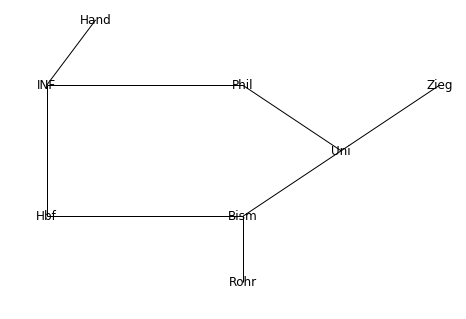

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 434. Mal
Länge der Queue: 19 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit,

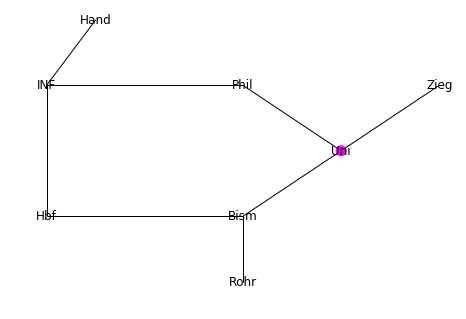

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 435. Mal
Länge der Queue: 18 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time

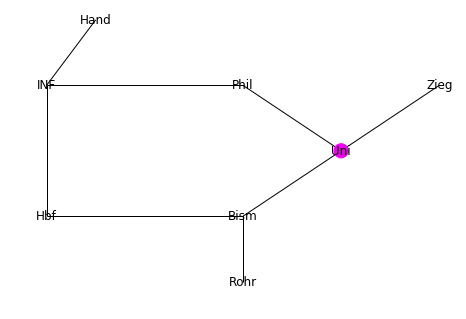

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 436. Mal
Länge der Queue: 17 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.

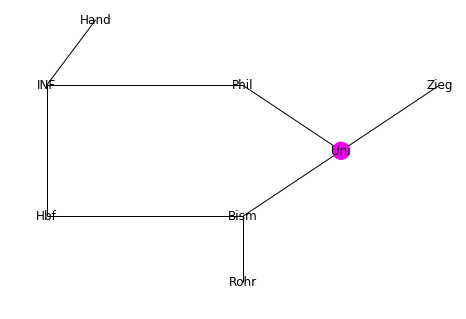

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 437. Mal
Länge der Queue: 16 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True

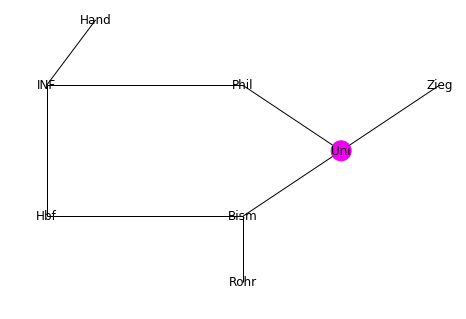

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 438. Mal
Länge der Queue: 15 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm

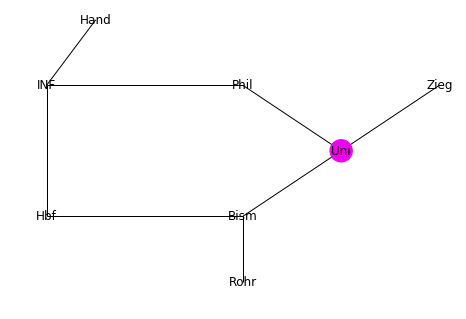

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 439. Mal
Länge der Queue: 14 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zyke

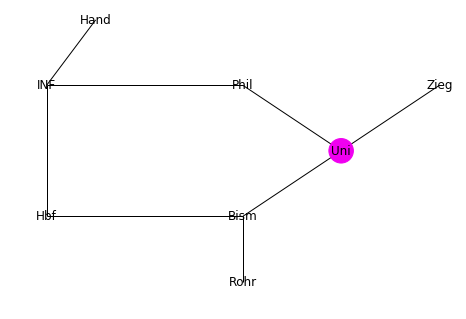

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 440. Mal
Länge der Queue: 13 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True

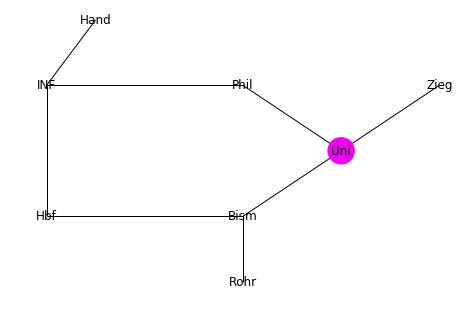

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 441. Mal
Länge der Queue: 12 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste H

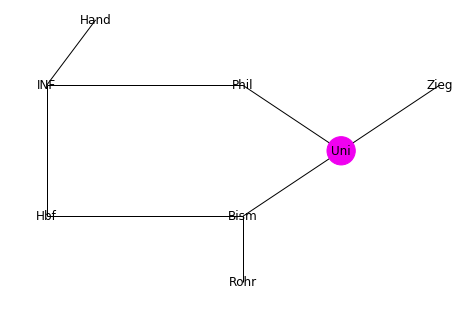

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 442. Mal
Länge der Queue: 11 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 164
und zykel1 Stopp z

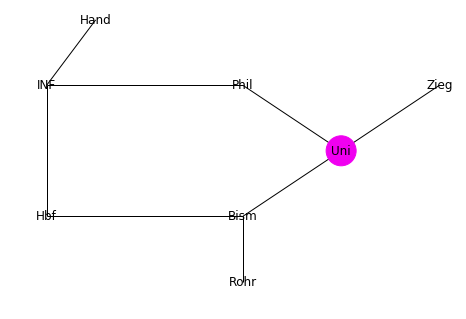

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 443. Mal
Länge der Queue: 10 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 164
und zykel1 Stopp zum 33. Mal, Runden: 6, Rest: 3
Graph gespeichert al

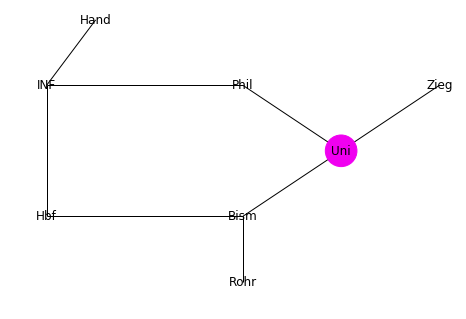

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 444. Mal
Länge der Queue: 9 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 164
und zykel1 Stopp zum 33. Mal, Runden: 6, Rest: 3
Graph gespeichert als file00164.png, wird in imglist hinzugefügt


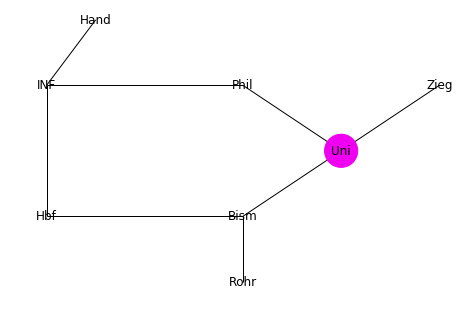

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 445. Mal
Länge der Queue: 8 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 164
und zykel1 Stopp zum 33. Mal, Runden: 6, Rest: 3
Graph gespeichert als file00164.png, wird in imglist hinzugefügt


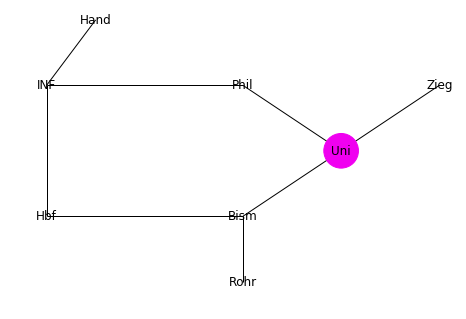

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164, 164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 446. Mal
Länge der Queue: 7 aktion:exit, time:164.False, bm:zykel1.False; aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 164
und zykel1 Stopp zum 33. Mal, Runden: 6, Rest: 3
Graph gespeichert als file00164.png, wird in imglist hinzugefügt


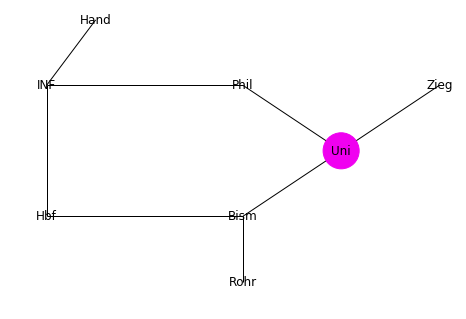

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: [164]
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 447. Mal
Länge der Queue: 6 aktion:exit, time:164.False, bm:zykel1.False; aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 164
und zykel1 Stopp zum 33. Mal, Runden: 6, Rest: 3
Graph gespeichert als file00164.png, wird in imglist hinzugefügt


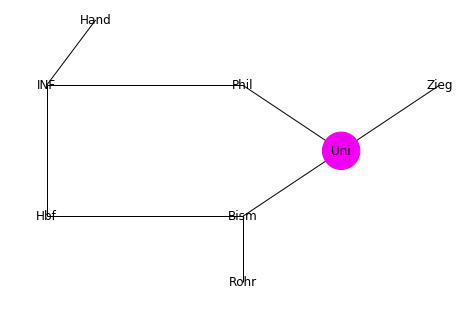

PassagierStation:7, PassagierTime:163, steigt aus, EventTime 164
Ist EventTime == PassagierTime: False
Passenger BM:zubinger2 CList: []
Event BM: zykel1 CList: []
Passagier am richtigen Ort: [False, False]
zubinger2 zykel1
Passagier mit Ziel: 7 wurde falsch berechnet.
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 448. Mal
Länge der Queue: 5 aktion:load, time:165.True, bm:zubinger0.True; aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zubinger0 ist am Knoten Rohr, der nächste Halt Bism, die aktuelle Zeit: 165
und zubinger0 Stopp zum 33. Mal, Runden: 16, Rest: 1
Graph gespeichert als file00165.png, wird in imglist hinzugefügt


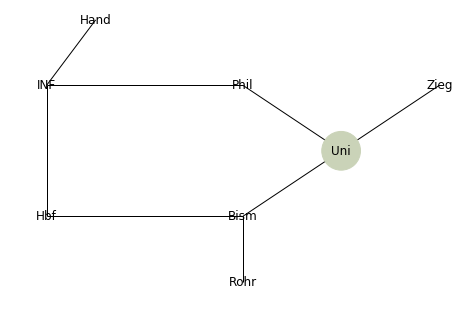

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Rohr

 Durchläuft die While-Schleife zum 449. Mal
Länge der Queue: 5 aktion:load, time:165.True, bm:zubinger1.True; aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zubinger0.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zubinger1 ist am Knoten Hand, der nächste Halt INF, die aktuelle Zeit: 165
und zubinger1 Stopp zum 33. Mal, Runden: 16, Rest: 1
Graph gespeichert als file00165.png, wird in imglist hinzugefügt


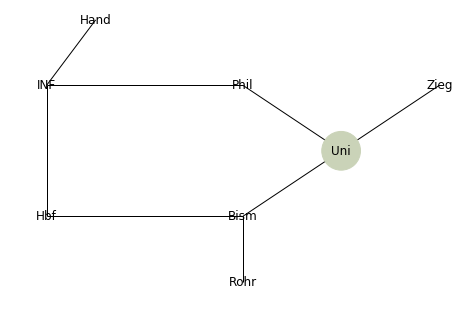

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Hand

 Durchläuft die While-Schleife zum 450. Mal
Länge der Queue: 5 aktion:load, time:165.True, bm:zubinger2.True; aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zubinger0.True; aktion:load, time:170.True, bm:zubinger1.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 165
und zubinger2 Stopp zum 33. Mal, Runden: 16, Rest: 1
Graph gespeichert als file00165.png, wird in imglist hinzugefügt


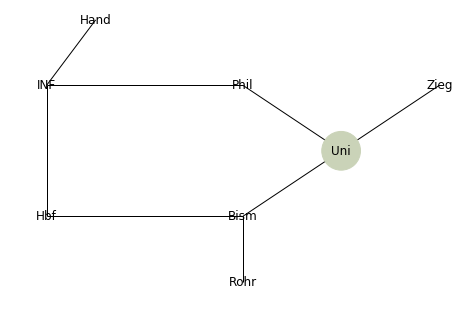

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Zieg

 Durchläuft die While-Schleife zum 451. Mal
Länge der Queue: 5 aktion:load, time:165.True, bm:zykel1.True; aktion:load, time:170.True, bm:zubinger0.True; aktion:load, time:170.True, bm:zubinger1.True; aktion:load, time:170.True, bm:zubinger2.True; aktion:load, time:170.True, bm:zykel0.True; 
Fahrzeug zykel1 ist am Knoten Uni, der nächste Halt Bism, die aktuelle Zeit: 165
und zykel1 Stopp zum 33. Mal, Runden: 6, Rest: 3
Graph gespeichert als file00165.png, wird in imglist hinzugefügt


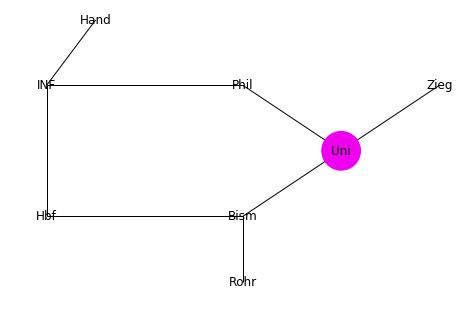

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 15 Plätze frei
15
Berechne, wer zukünftig umsteigen soll
Protect:  ['zubinger2']
Temp:  [[3, 7]]
Es warten noch 15 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 452. Mal
Länge der Queue: 5 aktion:load, time:170.True, bm:zubinger0.True; aktion:load, time:170.True, bm:zubinger1.True; aktion:load, time:170.True, bm:zubinger2.True; aktion:load, time:170.True, bm:zykel0.True; aktion:load, time:170.True, bm:zykel1.True; 
Fahrzeug zubinger0 ist am Knoten Bism, der nächste Halt Rohr, die aktuelle Zeit: 170
und zubinger0 Stopp zum 34. Mal, Runden: 17, Rest: 0
Graph gespeichert als file00170.png, wird in imglist hinzugefügt


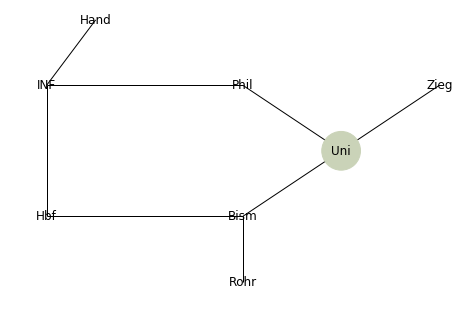

Fahrzeug zubinger0 load
Fahrzeug zubinger0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 453. Mal
Länge der Queue: 5 aktion:load, time:170.True, bm:zubinger1.True; aktion:load, time:170.True, bm:zubinger2.True; aktion:load, time:170.True, bm:zykel0.True; aktion:load, time:170.True, bm:zykel1.True; aktion:load, time:175.True, bm:zubinger0.True; 
Fahrzeug zubinger1 ist am Knoten INF, der nächste Halt Hand, die aktuelle Zeit: 170
und zubinger1 Stopp zum 34. Mal, Runden: 17, Rest: 0
Graph gespeichert als file00170.png, wird in imglist hinzugefügt


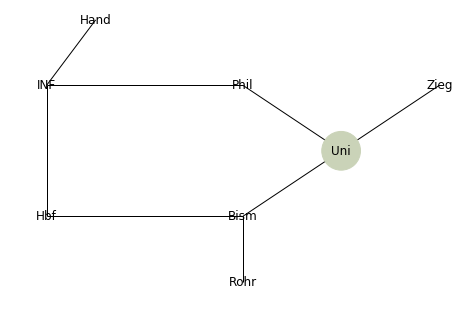

Fahrzeug zubinger1 load
Fahrzeug zubinger1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten INF

 Durchläuft die While-Schleife zum 454. Mal
Länge der Queue: 5 aktion:load, time:170.True, bm:zubinger2.True; aktion:load, time:170.True, bm:zykel0.True; aktion:load, time:170.True, bm:zykel1.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; 
Fahrzeug zubinger2 ist am Knoten Uni, der nächste Halt Zieg, die aktuelle Zeit: 170
und zubinger2 Stopp zum 34. Mal, Runden: 17, Rest: 0
Graph gespeichert als file00170.png, wird in imglist hinzugefügt


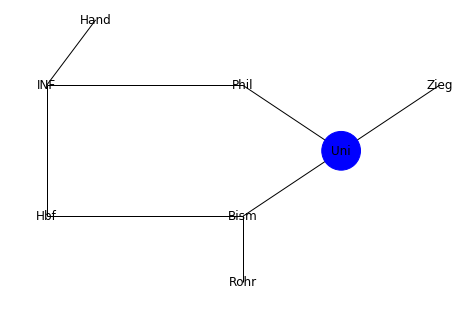

Fahrzeug zubinger2 load
Fahrzeug zubinger2 hat 15 Plätze frei
15
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
ExitTime: 173, ListExit: [5]
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Uni

 Durchläuft die While-Schleife zum 455. Mal
Länge der Queue: 20 aktion:load, time:170.True, bm:zykel0.True; aktion:load, time:170.True, bm:zykel1.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:z

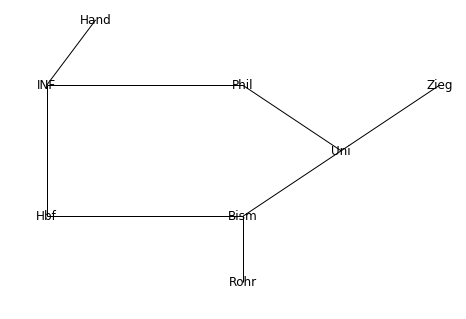

Fahrzeug zykel0 load
Fahrzeug zykel0 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Phil

 Durchläuft die While-Schleife zum 456. Mal
Länge der Queue: 20 aktion:load, time:170.True, bm:zykel1.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; 

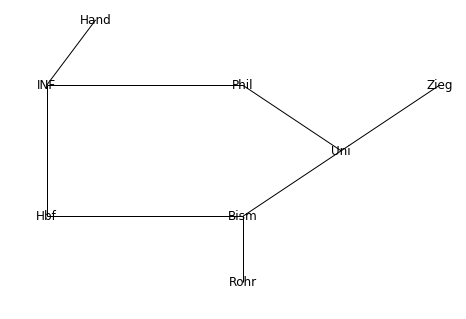

Fahrzeug zykel1 load
Fahrzeug zykel1 hat 15 Plätze frei
0
Berechne, wer zukünftig umsteigen soll
Es warten noch 0 Fahrgäste an Knoten Bism

 Durchläuft die While-Schleife zum 457. Mal
Länge der Queue: 20 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.Tru

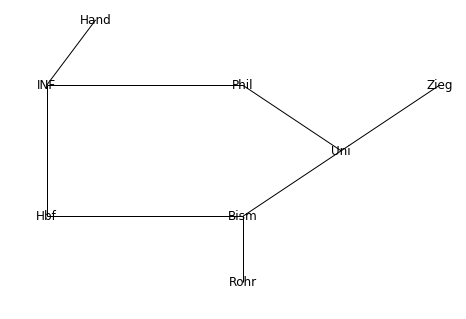

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 14 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 458. Mal
Länge der Queue: 19 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktio

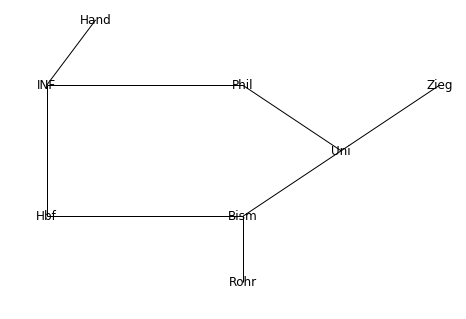

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 13 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 459. Mal
Länge der Queue: 18 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktio

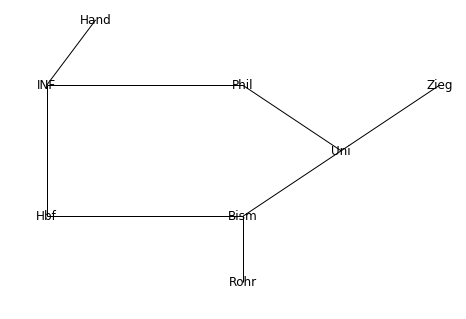

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 12 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 460. Mal
Länge der Queue: 17 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:l

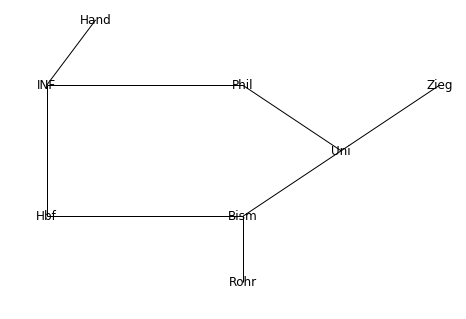

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 11 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 461. Mal
Länge der Queue: 16 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug z

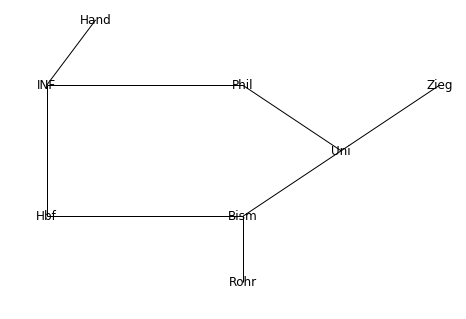

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 10 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 462. Mal
Länge der Queue: 15 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt U

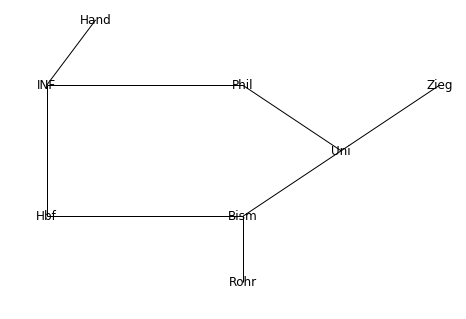

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 9 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 463. Mal
Länge der Queue: 14 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp z

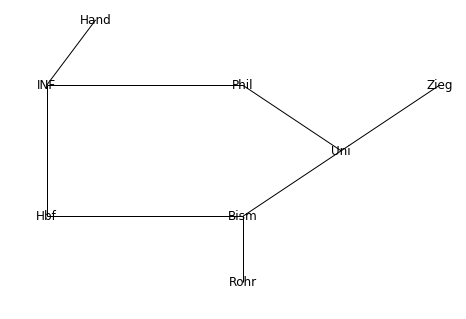

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 8 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 464. Mal
Länge der Queue: 13 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeiche

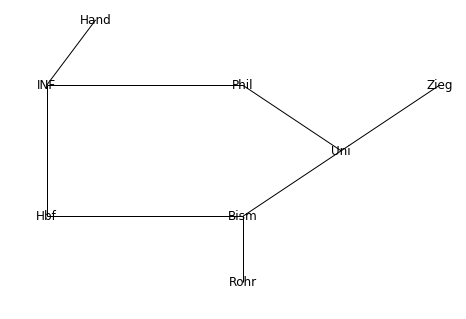

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 7 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 465. Mal
Länge der Queue: 12 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeichert als file00173.png, wird in imglist hinzugefü

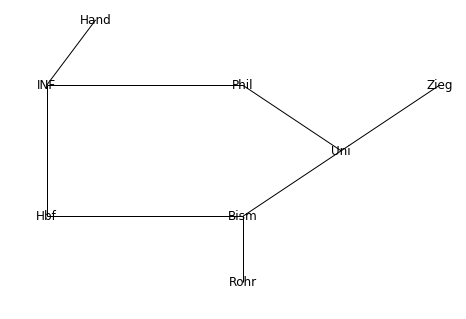

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 6 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 466. Mal
Länge der Queue: 11 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeichert als file00173.png, wird in imglist hinzugefügt


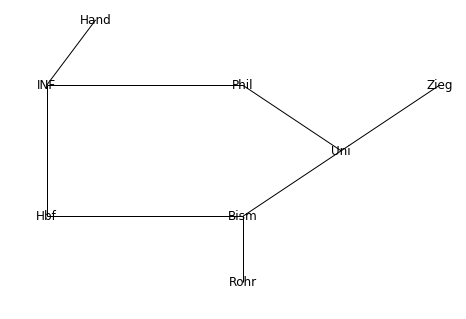

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 5 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 467. Mal
Länge der Queue: 10 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeichert als file00173.png, wird in imglist hinzugefügt


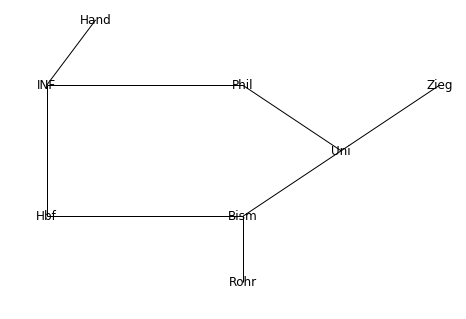

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 4 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 468. Mal
Länge der Queue: 9 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeichert als file00173.png, wird in imglist hinzugefügt


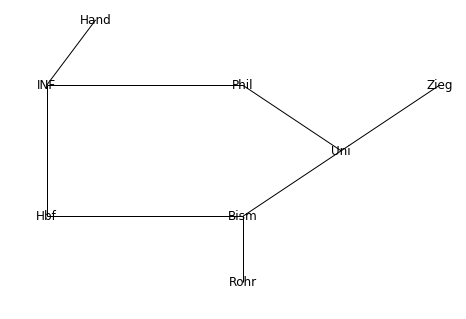

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 3 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 469. Mal
Länge der Queue: 8 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeichert als file00173.png, wird in imglist hinzugefügt


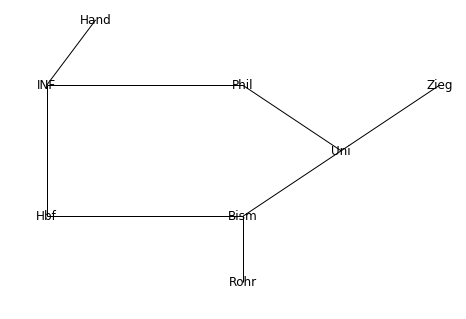

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 2 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 470. Mal
Länge der Queue: 7 aktion:exit, time:173.True, bm:zubinger2.True; aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeichert als file00173.png, wird in imglist hinzugefügt


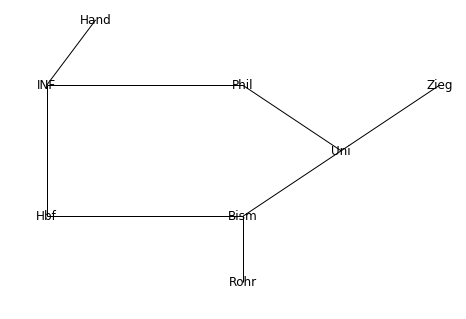

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 1 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 471. Mal
Länge der Queue: 6 aktion:exit, time:173.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
Fahrzeug zubinger2 ist am Knoten Zieg, der nächste Halt Uni, die aktuelle Zeit: 173
und zubinger2 Stopp zum 35. Mal, Runden: 17, Rest: 1
Graph gespeichert als file00173.png, wird in imglist hinzugefügt


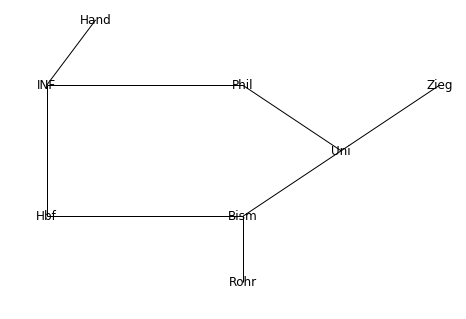

PassagierStation:7, PassagierTime:173, steigt aus, EventTime 173
Ist EventTime == PassagierTime: True
Passagier am richtigen Ort: [True, False]
Es sind 0 Passagiere in der Bahn

 Durchläuft die While-Schleife zum 472. Mal
Länge der Queue: 5 aktion:load, time:175.True, bm:zubinger0.True; aktion:load, time:175.True, bm:zubinger1.True; aktion:load, time:175.True, bm:zubinger2.True; aktion:load, time:175.True, bm:zykel1.True; aktion:load, time:180.True, bm:zykel0.True; 
ENDE


In [5]:
event0 = Event(0,'load','zykel0', Passagier(_))
event0.p.bm = event0.bm
event0.p.time = event0.time
event1 = Event(0,'load','zykel1', Passagier(_))
event1.p.bm = event1.bm
event1.p.time = event1.time
event2 = Event(0,'load','zubinger0', Passagier(_))
event2.p.bm = event2.bm
event2.p.time = event2.time
event3 = Event(0,'load','zubinger1', Passagier(_))
event3.p.bm = event3.bm
event3.p.time = event3.time
event4 = Event(0,'load','zubinger2', Passagier(_))
event4.p.bm = event4.bm
event4.p.time = event4.time
eventq = []
hq.heappush(eventq, event0)
hq.heappush(eventq, event1)
hq.heappush(eventq, event2)
hq.heappush(eventq, event3)
hq.heappush(eventq, event4)

list_of_img = solve(eventq, passengers, bms, graph)

cat *.png | ffmpeg -framerate 5 -f image2pipe -i - animation1.mkv